In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, auc, recall_score,r2_score
from scipy.stats import chisquare, chi2_contingency

## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_Step # 01 Fetch the dataset_

- Extract the data from xls file into Pandas

In [365]:
dt = pd.read_excel('default of credit card clients.xls', header=1)
dt['temp'] = dt['BILL_AMT1']+dt['BILL_AMT2']+ dt['BILL_AMT3'] + dt['BILL_AMT4']+ dt['BILL_AMT5'] + dt['BILL_AMT6']

- View the few rows of data 

In [366]:
dt.head(10)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,temp
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,7704
1,2,120000,2,2,2,26,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,17077
2,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,101653
3,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,231334
4,5,50000,1,2,1,57,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,109339
5,6,50000,1,1,2,37,0,0,0,0,...,19619,20024,2500,1815,657,1000,1000,800,0,238114
6,7,500000,1,1,2,29,0,0,0,0,...,483003,473944,55000,40000,38000,20239,13750,13770,0,2724595
7,8,100000,2,2,2,23,0,-1,-1,0,...,-159,567,380,601,0,581,1687,1542,0,13486
8,9,140000,2,3,1,28,0,0,2,0,...,11793,3719,3329,0,432,1000,1000,1000,0,65212
9,10,20000,1,3,2,35,-2,-2,-2,-2,...,13007,13912,0,0,0,13007,1122,0,0,26919


## &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;_Step # 02 Exploratory data Analysis_

1. How many features are there in the dataset?

In [4]:
dt.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'temp'],
      dtype='object')

In [5]:
len(dt.columns)

26

2. How many observation the dataset contains?

In [6]:
len(dt)

30000

**Separate datasets**: <br>
Separate out the __defaulters__ and __non-defaulters__ data from the actual (complete) dataset.

In [7]:
defaulters = dt[dt['default payment next month']==1]
non_defaulters = dt[dt['default payment next month']==0]

### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Features Exploration

- **Balance Limit** 

1. How the __balance limit__ is distributed?

In [8]:
bal_limit = dt['LIMIT_BAL']

In [9]:
bal_limit.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

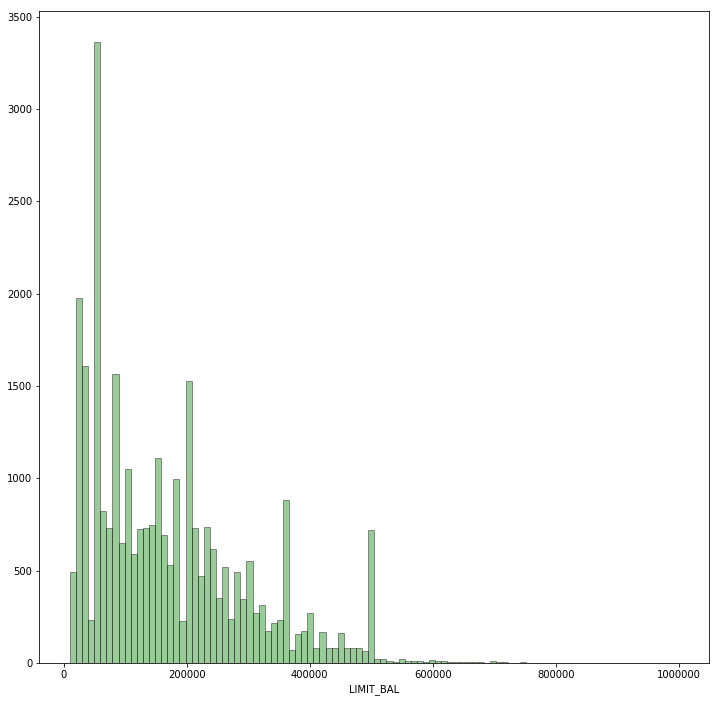

In [10]:
plt.figure(figsize=(12,12))
sns.distplot(bal_limit,hist=True,kde=False, color='Green',bins=100,hist_kws={'edgecolor':'black'})

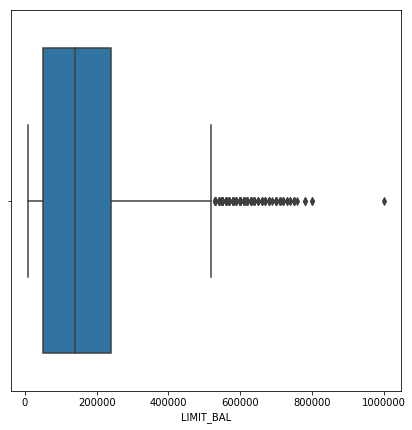

In [11]:
plt.figure(figsize=(7,7))
sns.boxplot(bal_limit)

2. How many instances have abnormal values? 

In [12]:
def IQR_func(column):
    Q1 = np.percentile(column.values, 25)
    Q3 = np.percentile(column.values, 75)
    IQR = Q3 - Q1 
    return IQR, Q1,Q3

In [13]:
IQR,Q1,Q3 = IQR_func(dt['LIMIT_BAL'])
low_quartile = Q1 - 1.5 * IQR
upp_quartile = Q3 + 1.5 * IQR

In [14]:
print('minimum range', low_quartile, '\nmaximum range', upp_quartile)

minimum range -235000.0 
maximum range 525000.0


In [15]:
(bal_limit > 525000).value_counts()/len(dt)*100

False    99.443333
True      0.556667
Name: LIMIT_BAL, dtype: float64

__Information__: The normal range of __balance limit__ is between __10,000__ to __0.2m__ while the __maximum value__ is __1m__. There are some outliers (about __0.55%__)in this feature given that the outliers are considered if balance limit is higher than __0.52m__(1.5 IQR).

3. Is there any **visual impact** on the distrubution of balance limit for **defaulter** and non **defaulters**?

i. De-faulters:

In [16]:
defaulters['LIMIT_BAL'].describe()

count      6636.000000
mean     130109.656420
std      115378.540571
min       10000.000000
25%       50000.000000
50%       90000.000000
75%      200000.000000
max      740000.000000
Name: LIMIT_BAL, dtype: float64

ii. Non-faulters:

In [17]:
non_defaulters['LIMIT_BAL'].describe()

count      23364.000000
mean      178099.726074
std       131628.359660
min        10000.000000
25%        70000.000000
50%       150000.000000
75%       250000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

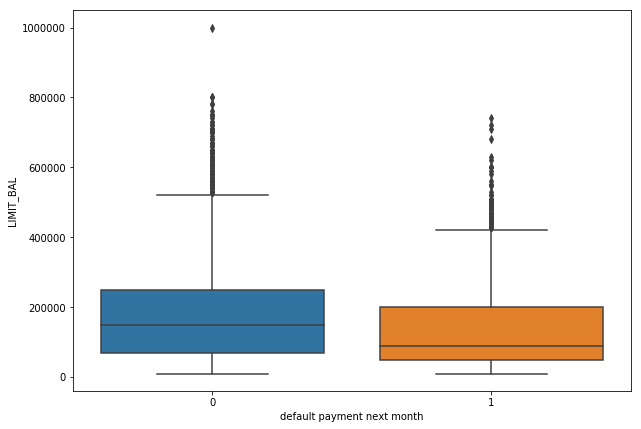

In [18]:
plt.figure(figsize=(10,7))
sns.boxplot(x='default payment next month', y='LIMIT_BAL', data=dt)

In [19]:
IQR,Q1,Q3 = IQR_func(defaulters['LIMIT_BAL'])
low_quartile = Q1 - 1.5 * IQR
upp_quartile = Q3 + 1.5 * IQR

In [20]:
print('minimum range', low_quartile, '\nmaximum range', upp_quartile)

minimum range -175000.0 
maximum range 425000.0


In [21]:
IQR,Q1,Q3 = IQR_func(non_defaulters['LIMIT_BAL'])
low_quartile = Q1 - 1.5 * IQR
upp_quartile = Q3 + 1.5 * IQR

In [22]:
print('minimum range', low_quartile, '\nmaximum range', upp_quartile)

minimum range -200000.0 
maximum range 520000.0


In [23]:
(defaulters['LIMIT_BAL'] >425000).value_counts()/len(defaulters)*100

False    97.182037
True      2.817963
Name: LIMIT_BAL, dtype: float64

In [24]:
(non_defaulters['LIMIT_BAL'] >520000).value_counts()/len(non_defaulters)*100

False    99.366547
True      0.633453
Name: LIMIT_BAL, dtype: float64

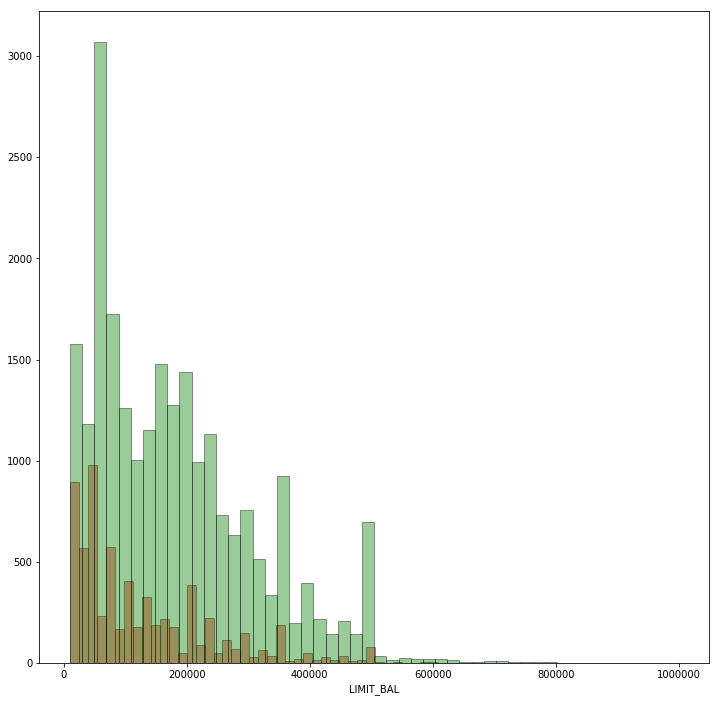

In [25]:
plt.figure(figsize=(12,12))
sns.distplot(defaulters['LIMIT_BAL'],hist=True,kde=False, color='red',bins=50,hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['LIMIT_BAL'],hist=True,kde=False, color='green',bins=50,hist_kws={'edgecolor':'black'})

4. How many instances are below and above __0.2 million__ ?

In [26]:
dt['threshold'] = dt['LIMIT_BAL'].apply(lambda x: 'greater than 0.2m' if x > 200000 else 'less than 0.2m')
defaulters['threshold'] = defaulters['LIMIT_BAL'].apply(lambda x: 'greater than 0.2m' if x > 200000 else 'less than 0.2m')
non_defaulters['threshold'] = non_defaulters['LIMIT_BAL'].apply(lambda x: 'greater than 0.2m' if x > 200000 else 'less than 0.2m')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


i. Complete data:

In [27]:
crostbl = pd.crosstab(dt['threshold'], 'frequency').reset_index()
crostbl['share'] = crostbl['frequency'].apply(lambda x: (x/len(dt))*100)
crostbl

col_0,threshold,frequency,share
0,greater than 0.2m,9622,32.073333
1,less than 0.2m,20378,67.926667


ii. defaulters:

In [28]:
crostbl = pd.crosstab(defaulters['threshold'], 'frequency').reset_index()
crostbl['share'] = crostbl['frequency'].apply(lambda x: (x/len(defaulters))*100)
crostbl

col_0,threshold,frequency,share
0,greater than 0.2m,1417,21.353225
1,less than 0.2m,5219,78.646775


iii. Non-defaulters:

In [29]:
crostbl = pd.crosstab(non_defaulters['threshold'], 'frequency').reset_index()
crostbl['share'] = crostbl['frequency'].apply(lambda x: (x/len(non_defaulters))*100)
crostbl

col_0,threshold,frequency,share
0,greater than 0.2m,8205,35.11813
1,less than 0.2m,15159,64.88187


5. What is the correlation of __Limit of balance__ with __default__ ?<br>
First, __limit of balance__ which is __numerical and continuous__ in nature needs to be converted into __buckets (categorical)__ to run __chi-squared analysis__ for finding coorelation. 

In [30]:
dt['LIMIT_BAL_BUCKETS'] = np.where((dt['LIMIT_BAL'] >=10000) & (dt['LIMIT_BAL'] <200000), 'Low',
                          np.where((dt['LIMIT_BAL'] >=200000) & (dt['LIMIT_BAL'] <600000), 'medium','high'))

In [31]:
pd.crosstab(dt['default payment next month'],dt['LIMIT_BAL_BUCKETS'])

LIMIT_BAL_BUCKETS,Low,high,medium
default payment next month,,,
0,13901,86,9377
1,4949,9,1678


In [32]:
chi_value, p_value, dof, expected = chi2_contingency(pd.crosstab(dt['default payment next month'],dt['LIMIT_BAL_BUCKETS']))

In [33]:
print('chi statistic : ', chi_value)
print('p-value : ', p_value)
print('degree of freedom : ', dof)

chi statistic :  505.07436386048664
p-value :  2.1110348956156036e-110
degree of freedom :  2


__Conclusion__: The Variation of __limit of balance__ between __defaulters and non-defaulters__ and signficant value of __chi-statistics__ suggest that this feature is statistically significant and can be a good predictor. 

## <u> PAYMENT STATUS (HISTORY)<u>:

- **Payment status of Sept 2005** 

In [34]:
dt[dt['PAY_0']==0]['default payment next month'].value_counts()

0    12849
1     1888
Name: default payment next month, dtype: int64

1. What is the distribution?

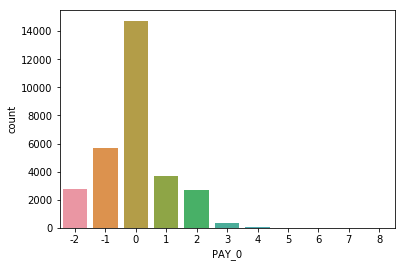

In [35]:
sns.countplot(x='PAY_0', data=dt)

2. What is the percentage of __0 and -2__ ? As it is not mentioned in the UCI repository guide and will be considered as irrelevant.

In [36]:
dt['PAY_0'].value_counts()/len(dt)*100

 0    49.123333
-1    18.953333
 1    12.293333
-2     9.196667
 2     8.890000
 3     1.073333
 4     0.253333
 5     0.086667
 8     0.063333
 6     0.036667
 7     0.030000
Name: PAY_0, dtype: float64

3. What is the distribution for __defaulters__ and __non-defaulters__?

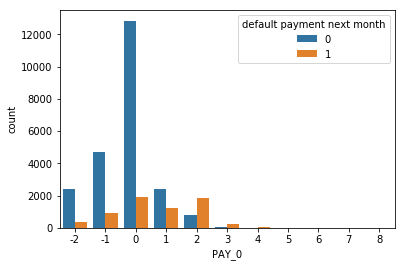

In [37]:
sns.countplot(x='PAY_0',hue='default payment next month', data=dt)

<u> __Defaulters__:

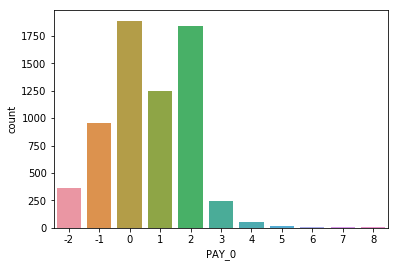

In [38]:
sns.countplot(x='PAY_0', data=defaulters)

In [39]:
defaulters['PAY_0'].value_counts()/len(defaulters)*100

 0    28.450874
 2    27.787824
 1    18.866787
-1    14.376130
-2     5.500301
 3     3.676914
 4     0.783605
 5     0.195901
 8     0.165763
 7     0.105485
 6     0.090416
Name: PAY_0, dtype: float64

<u> __Non-Defaulters__:

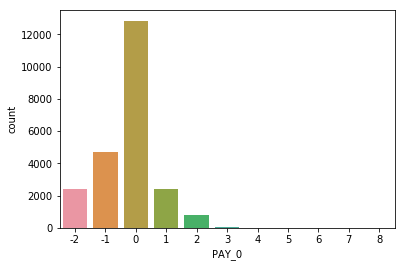

In [40]:
sns.countplot(x='PAY_0', data=non_defaulters)

In [41]:
non_defaulters['PAY_0'].value_counts()/len(non_defaulters)*100

 0    54.994864
-1    20.253381
 1    10.426297
-2    10.246533
 2     3.522513
 3     0.333847
 4     0.102722
 5     0.055641
 8     0.034241
 6     0.021400
 7     0.008560
Name: PAY_0, dtype: float64

- **Payment status of Aug 2005** 

1. What is the distribution?

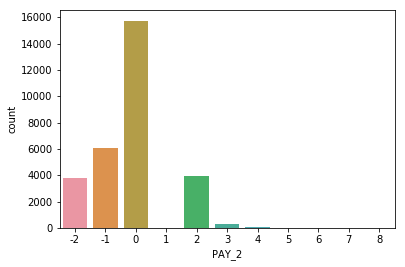

In [42]:
sns.countplot(x='PAY_2', data=dt)

2. What is the percentage of __0 and -2__ ? As it is not mentioned in the UCI repository guide and will be considered as irrelevant.

In [43]:
dt['PAY_2'].value_counts()/len(dt)*100

 0    52.433333
-1    20.166667
 2    13.090000
-2    12.606667
 3     1.086667
 4     0.330000
 1     0.093333
 5     0.083333
 7     0.066667
 6     0.040000
 8     0.003333
Name: PAY_2, dtype: float64

3. What is the distribution for __defaulters__ and __non-defaulters__?

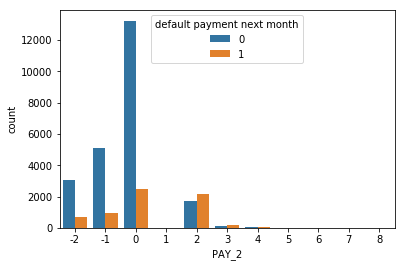

In [44]:
sns.countplot(x='PAY_2',hue='default payment next month', data=dt)

<u>__Defaulters__:

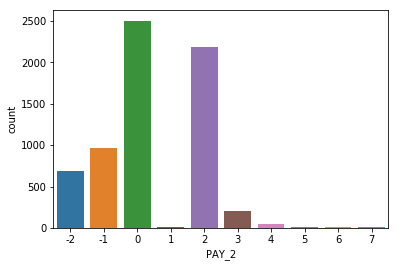

In [45]:
sns.countplot(x='PAY_2', data=defaulters)

In [46]:
defaulters['PAY_2'].value_counts()/len(defaulters)*100

 0    37.718505
 2    32.911392
-1    14.556962
-2    10.412899
 3     3.028933
 4     0.753466
 5     0.226040
 7     0.180832
 6     0.135624
 1     0.075347
Name: PAY_2, dtype: float64

<u> __Non-Defaulters__:

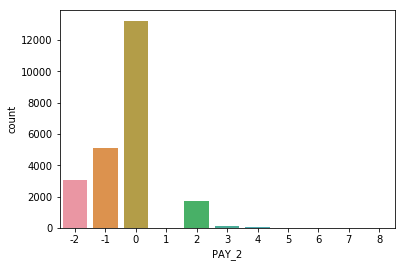

In [47]:
sns.countplot(x='PAY_2', data=non_defaulters)

In [48]:
non_defaulters['PAY_2'].value_counts()/len(non_defaulters)*100

 0    56.612738
-1    21.759973
-2    13.229755
 2     7.460195
 3     0.535011
 4     0.209724
 1     0.098442
 5     0.042801
 7     0.034241
 6     0.012840
 8     0.004280
Name: PAY_2, dtype: float64

- **Payment of July 2005** 

1. What is the distribution?

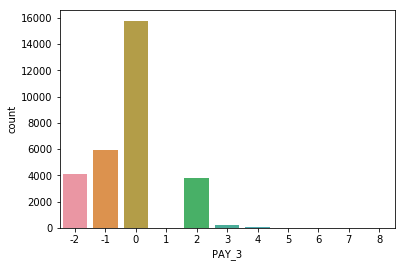

In [49]:
sns.countplot(x='PAY_3', data=dt)

2. What is the percentage of __0 and -2__ ? As it is not mentioned in the UCI repository guide and will be considered as irrelevant.

In [50]:
dt['PAY_3'].value_counts()/len(dt)*100

 0    52.546667
-1    19.793333
-2    13.616667
 2    12.730000
 3     0.800000
 4     0.253333
 7     0.090000
 6     0.076667
 5     0.070000
 1     0.013333
 8     0.010000
Name: PAY_3, dtype: float64

3. What is the distribution for __defaulters__ and __non-defaulters__?

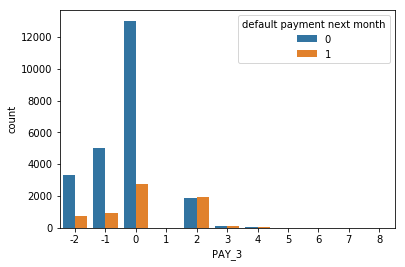

In [51]:
sns.countplot(x='PAY_3',hue='default payment next month', data=dt)

<u>__Defaulters__:

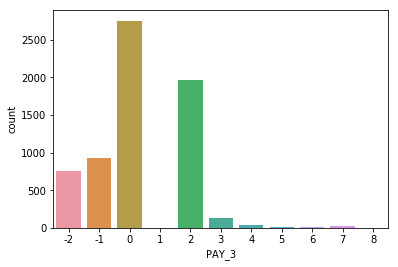

In [52]:
sns.countplot(x='PAY_3', data=defaulters)

In [53]:
defaulters['PAY_3'].value_counts()/len(defaulters)*100

 0    41.455696
 2    29.671489
-1    13.954189
-2    11.407474
 3     2.079566
 4     0.663050
 7     0.331525
 6     0.210970
 5     0.180832
 8     0.030139
 1     0.015069
Name: PAY_3, dtype: float64

<u> __Non-Defaulters__:

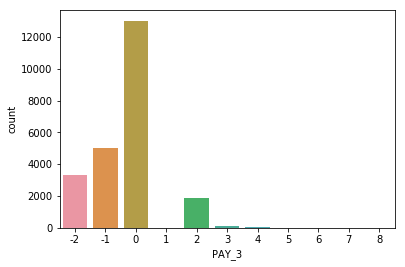

In [54]:
sns.countplot(x='PAY_3', data=non_defaulters)

In [55]:
non_defaulters['PAY_3'].value_counts()/len(non_defaulters)*100

 0    55.696798
-1    21.451806
-2    14.244136
 2     7.918165
 3     0.436569
 4     0.136963
 6     0.038521
 5     0.038521
 7     0.021400
 1     0.012840
 8     0.004280
Name: PAY_3, dtype: float64

- **Payment status of June 2005** 

1. What is the distribution?

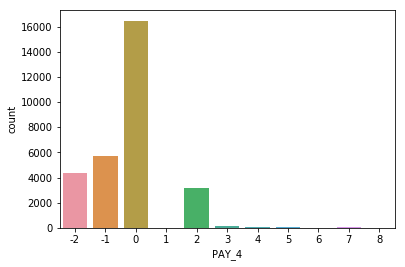

In [56]:
sns.countplot(x='PAY_4', data=dt)

2. What is the percentage of __0 and -2__ ? As it is not mentioned in the UCI repository guide and will be considered as irrelevant.

In [57]:
dt['PAY_4'].value_counts()/len(dt)*100

 0    54.850000
-1    18.956667
-2    14.493333
 2    10.530000
 3     0.600000
 4     0.230000
 7     0.193333
 5     0.116667
 6     0.016667
 8     0.006667
 1     0.006667
Name: PAY_4, dtype: float64

3. What is the distribution for __defaulters__ and __non-defaulters__?

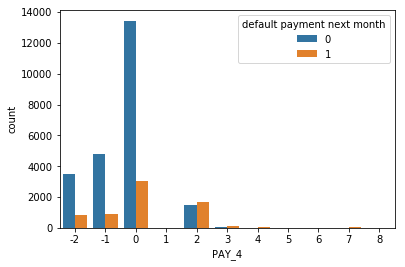

In [58]:
sns.countplot(x='PAY_4',hue='default payment next month', data=dt)

<u>__Defaulters__:

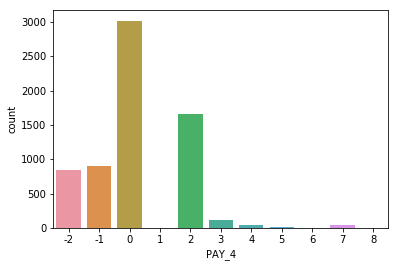

In [59]:
sns.countplot(x='PAY_4', data=defaulters)

In [60]:
defaulters['PAY_4'].value_counts()/len(defaulters)*100

 0    45.449066
 2    24.909584
-1    13.622664
-2    12.613020
 3     1.657625
 7     0.723327
 4     0.693189
 5     0.271248
 6     0.030139
 1     0.015069
 8     0.015069
Name: PAY_4, dtype: float64

<u> __Non-Defaulters__:

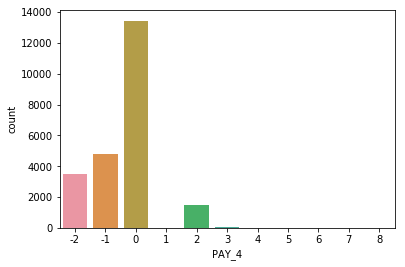

In [61]:
sns.countplot(x='PAY_4', data=non_defaulters)

In [62]:
non_defaulters['PAY_4'].value_counts()/len(non_defaulters)*100

 0    57.520116
-1    20.471666
-2    15.027393
 2     6.445814
 3     0.299606
 4     0.098442
 5     0.072762
 7     0.042801
 6     0.012840
 8     0.004280
 1     0.004280
Name: PAY_4, dtype: float64

- **Payment status of May 2005** 

1. What is the distribution?

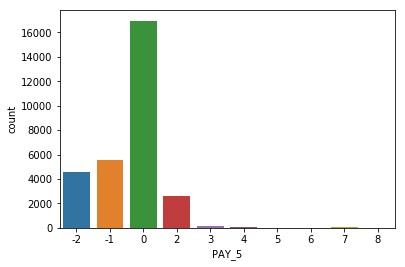

In [63]:
sns.countplot(x='PAY_5', data=dt)

2. What is the percentage of __0 and -2__ ? As it is not mentioned in the UCI repository guide and will be considered as irrelevant.

In [64]:
dt['PAY_5'].value_counts()/len(dt)*100

 0    56.490000
-1    18.463333
-2    15.153333
 2     8.753333
 3     0.593333
 4     0.280000
 7     0.193333
 5     0.056667
 6     0.013333
 8     0.003333
Name: PAY_5, dtype: float64

3. What is the distribution for __defaulters__ and __non-defaulters__?

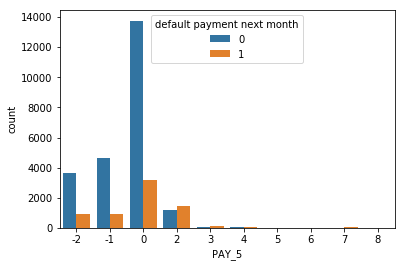

In [65]:
sns.countplot(x='PAY_5',hue='default payment next month', data=dt)

<u>__Defaulters__:

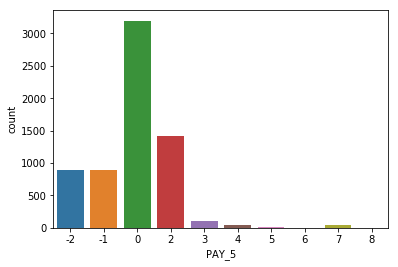

In [66]:
sns.countplot(x='PAY_5', data=defaulters)

In [67]:
defaulters['PAY_5'].value_counts()/len(defaulters)*100

 0    48.146474
 2    21.443641
-1    13.517179
-2    13.487040
 3     1.702833
 4     0.768535
 7     0.723327
 5     0.150693
 6     0.045208
 8     0.015069
Name: PAY_5, dtype: float64

<u> __Non-Defaulters__:

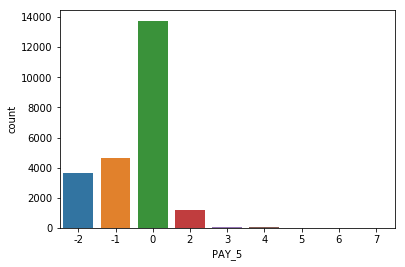

In [68]:
sns.countplot(x='PAY_5', data=non_defaulters)

In [69]:
non_defaulters['PAY_5'].value_counts()/len(non_defaulters)*100

 0    58.859784
-1    19.868173
-2    15.626605
 2     5.148947
 3     0.278206
 4     0.141243
 7     0.042801
 5     0.029961
 6     0.004280
Name: PAY_5, dtype: float64

- **Payment status of April 2005** 

1. What is the distribution?

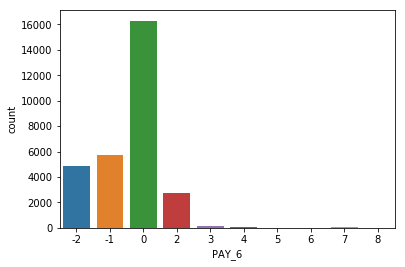

In [70]:
sns.countplot(x='PAY_6', data=dt)

2. What is the percentage of __0 and -2__ ? As it is not mentioned in the UCI repository guide and will be considered as irrelevant.

In [71]:
dt['PAY_6'].value_counts()/len(dt)*100

 0    54.286667
-1    19.133333
-2    16.316667
 2     9.220000
 3     0.613333
 4     0.163333
 7     0.153333
 6     0.063333
 5     0.043333
 8     0.006667
Name: PAY_6, dtype: float64

3. What is the distribution for __defaulters__ and __non-defaulters__?

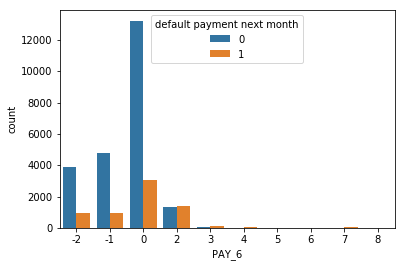

In [72]:
sns.countplot(x='PAY_6',hue='default payment next month', data=dt)

<u>__Defaulters__:

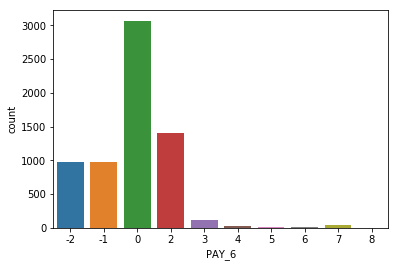

In [73]:
sns.countplot(x='PAY_6', data=defaulters)

In [74]:
defaulters['PAY_6'].value_counts()/len(defaulters)*100

 0    46.247740
 2    21.112116
-2    14.783002
-1    14.692586
 3     1.778180
 7     0.572634
 4     0.467149
 6     0.210970
 5     0.105485
 8     0.030139
Name: PAY_6, dtype: float64

<u> __Non-Defaulters__:

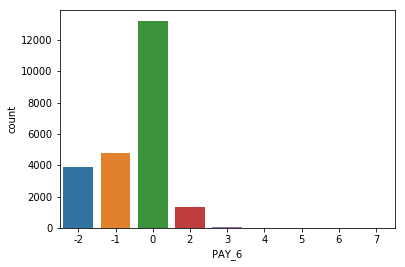

In [75]:
sns.countplot(x='PAY_6', data=non_defaulters)

In [76]:
non_defaulters['PAY_6'].value_counts()/len(non_defaulters)*100

 0    56.569937
-1    20.394624
-2    16.752268
 2     5.842322
 3     0.282486
 4     0.077042
 7     0.034241
 5     0.025681
 6     0.021400
Name: PAY_6, dtype: float64

__Information__: It can be seen that payment of last six months (from April 2005 till sept 2005) has a consistent pattern, in general __status 0__ (which is not defined by UCI repository) has the highest occurences (share in that data) whereas, in __default cases__ the __two months late payment__ is a common and consistent trends that can be seen in all the payment status of last six months last but not least in __non-default cases__ the __Pay duly__ is a common and consistent trend for the last last six months.  

## <u> Bill Amount (History)<u>:

- **Bill Amount for Sept 2005** 

1. What is the distribution?

In [77]:
dt['BILL_AMT1'].describe()

count     30000.000000
mean      51223.330900
std       73635.860576
min     -165580.000000
25%        3558.750000
50%       22381.500000
75%       67091.000000
max      964511.000000
Name: BILL_AMT1, dtype: float64

<u>Histogram:

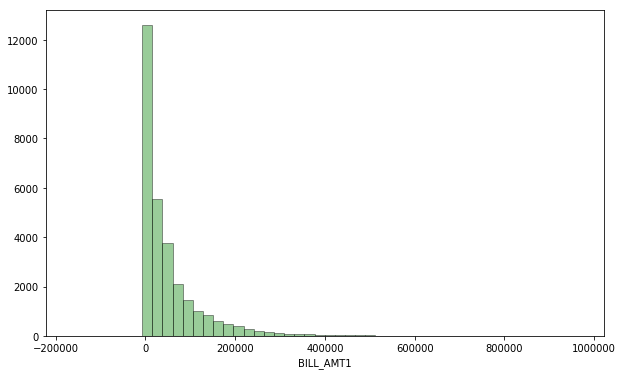

In [78]:
plt.figure(figsize=(10,6))
sns.distplot(dt['BILL_AMT1'], kde=False, hist=True,bins=50,color='Green',hist_kws={'edgecolor':'black'})

2. What is the distribution of __defaulters__ and __non-defaulters__?

<u>__Defaulters__:

In [79]:
defaulters['BILL_AMT1'].describe()

count      6636.000000
mean      48509.162297
std       73782.067220
min       -6676.000000
25%        2987.750000
50%       20185.000000
75%       59626.500000
max      613860.000000
Name: BILL_AMT1, dtype: float64

<u>__Non-Defaulters__:

In [80]:
non_defaulters['BILL_AMT1'].describe()

count     23364.000000
mean      51994.227273
std       73577.606694
min     -165580.000000
25%        3677.250000
50%       23119.500000
75%       69027.000000
max      964511.000000
Name: BILL_AMT1, dtype: float64

<u> Boxplot:

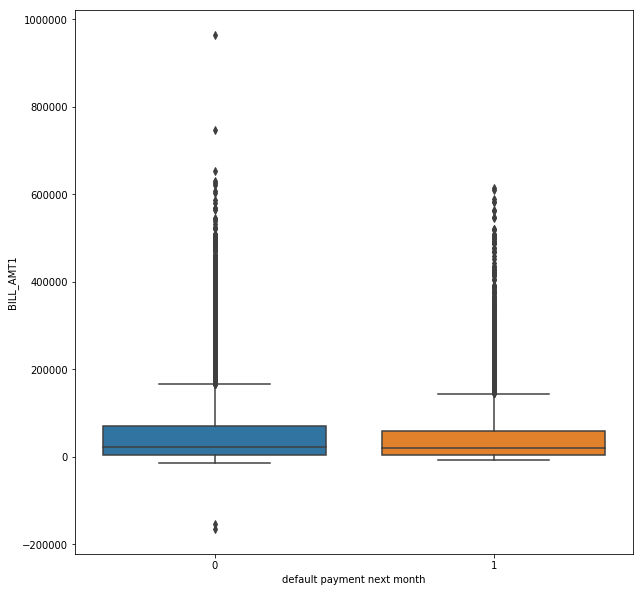

In [81]:
plt.figure(figsize=(10,10))
sns.boxplot(x='default payment next month', y='BILL_AMT1', data=dt)

<u> Histogram:

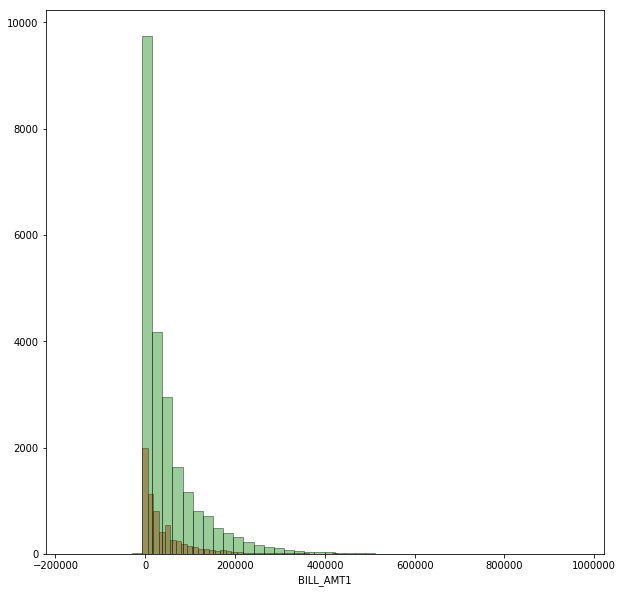

In [82]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT1'], kde=False, hist=True,bins=50,color='red',hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['BILL_AMT1'], kde=False, hist=True,bins=50,color='green',hist_kws={'edgecolor':'black'})

<u> Kernal Density:

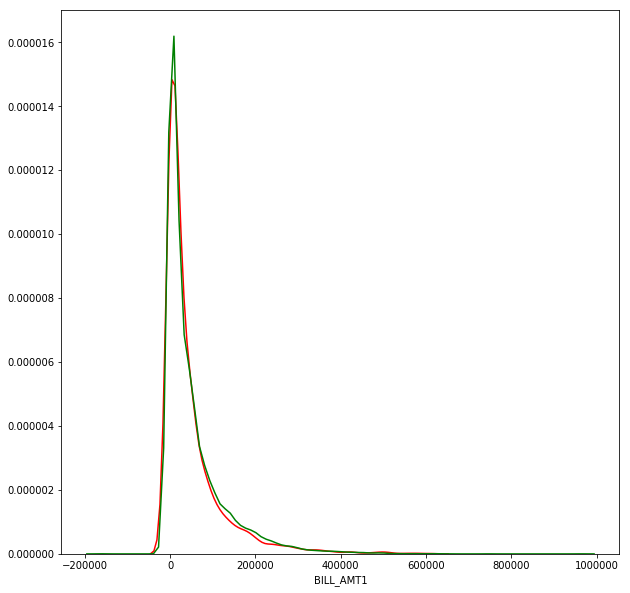

In [83]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT1'], kde=True, hist=False,bins=50,color='red')
sns.distplot(non_defaulters['BILL_AMT1'], kde=True, hist=False,bins=50,color='green')

- **Bill Amount for Aug 2005** 

1. What is the distribution?

In [84]:
dt['BILL_AMT2'].describe()

count     30000.000000
mean      49179.075167
std       71173.768783
min      -69777.000000
25%        2984.750000
50%       21200.000000
75%       64006.250000
max      983931.000000
Name: BILL_AMT2, dtype: float64

<u>Histogram:

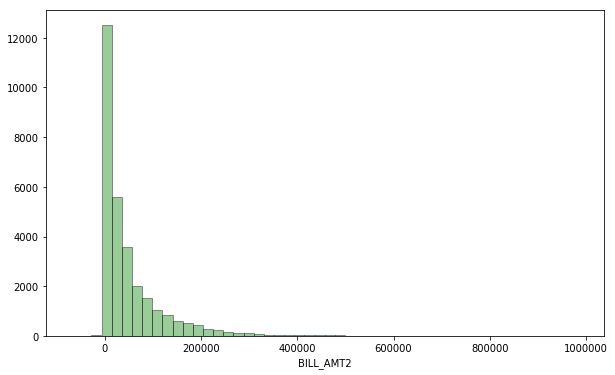

In [85]:
plt.figure(figsize=(10,6))
sns.distplot(dt['BILL_AMT2'], kde=False, hist=True,bins=50,color='Green',hist_kws={'edgecolor':'black'})

2. What is the distribution of __defaulters__ and __non-defaulters__?

<u>__Defaulters__:

In [86]:
defaulters['BILL_AMT2'].describe()

count      6636.000000
mean      47283.617842
std       71651.030364
min      -17710.000000
25%        2694.000000
50%       20300.500000
75%       57919.750000
max      581775.000000
Name: BILL_AMT2, dtype: float64

<u>__Non-Defaulters__:

In [87]:
non_defaulters['BILL_AMT2'].describe()

count     23364.000000
mean      49717.435670
std       71029.946709
min      -69777.000000
25%        3055.000000
50%       21660.500000
75%       65686.000000
max      983931.000000
Name: BILL_AMT2, dtype: float64

<u> Boxplot:

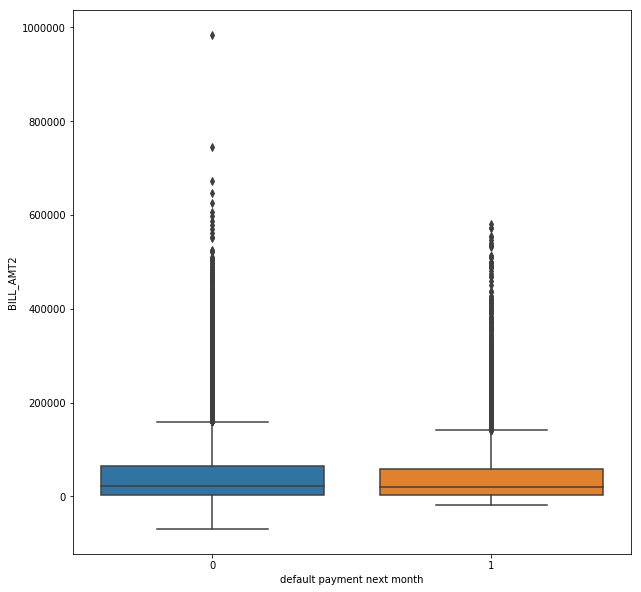

In [88]:
plt.figure(figsize=(10,10))
sns.boxplot(x='default payment next month', y='BILL_AMT2', data=dt)

<u> Histogram:

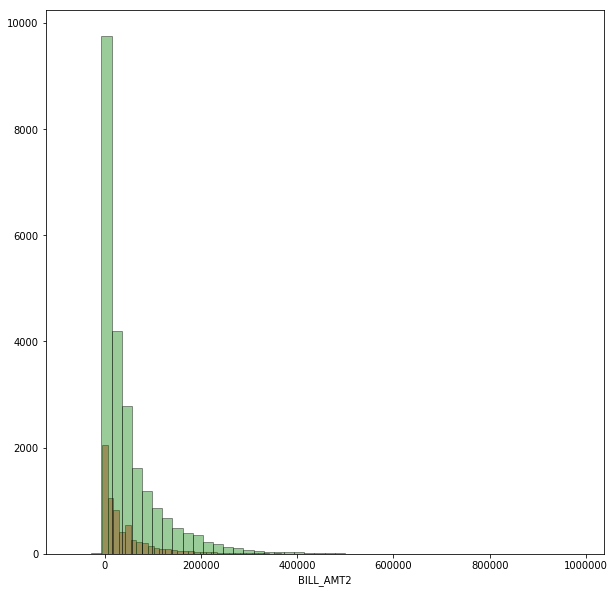

In [89]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT2'], kde=False, hist=True,bins=50,color='red',hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['BILL_AMT2'], kde=False, hist=True,bins=50,color='green',hist_kws={'edgecolor':'black'})

<u> Kernal Density:

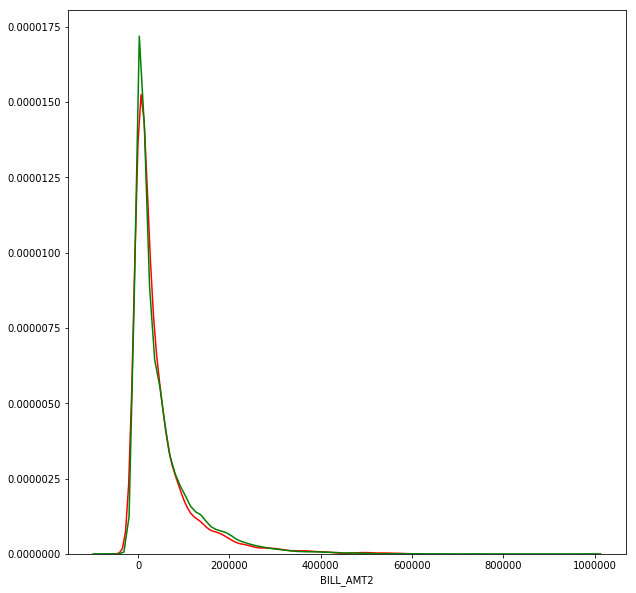

In [90]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT2'], kde=True, hist=False,bins=50,color='red')
sns.distplot(non_defaulters['BILL_AMT2'], kde=True, hist=False,bins=50,color='green')

- **Bill Amount for July 2005** 

1. What is the distribution?

In [91]:
dt['BILL_AMT3'].describe()

count    3.000000e+04
mean     4.701315e+04
std      6.934939e+04
min     -1.572640e+05
25%      2.666250e+03
50%      2.008850e+04
75%      6.016475e+04
max      1.664089e+06
Name: BILL_AMT3, dtype: float64

<u>Histogram:

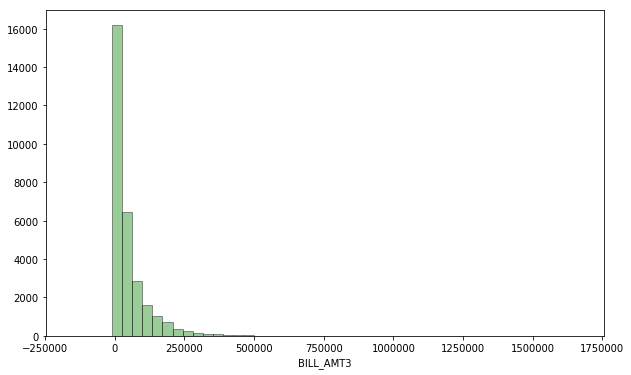

In [92]:
plt.figure(figsize=(10,6))
sns.distplot(dt['BILL_AMT3'], kde=False, hist=True,bins=50,color='Green',hist_kws={'edgecolor':'black'})

2. What is the distribution of __defaulters__ and __non-defaulters__?

<u>__Defaulters__:

In [93]:
defaulters['BILL_AMT3'].describe()

count      6636.000000
mean      45181.598855
std       68516.975738
min      -61506.000000
25%        2500.000000
50%       19834.500000
75%       54733.750000
max      578971.000000
Name: BILL_AMT3, dtype: float64

<u>__Non-Defaulters__:

In [94]:
non_defaulters['BILL_AMT3'].describe()

count    2.336400e+04
mean     4.753337e+04
std      6.957666e+04
min     -1.572640e+05
25%      2.769750e+03
50%      2.020250e+04
75%      6.189400e+04
max      1.664089e+06
Name: BILL_AMT3, dtype: float64

<u> Boxplot:

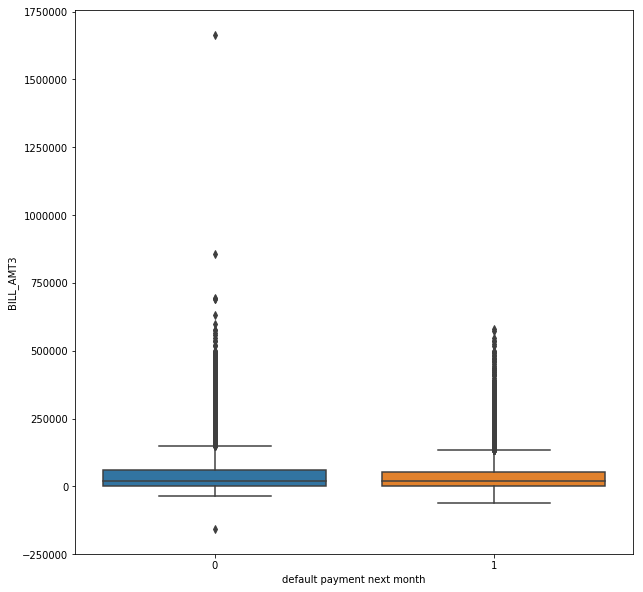

In [95]:
plt.figure(figsize=(10,10))
sns.boxplot(x='default payment next month', y='BILL_AMT3', data=dt)

<u> Histogram:

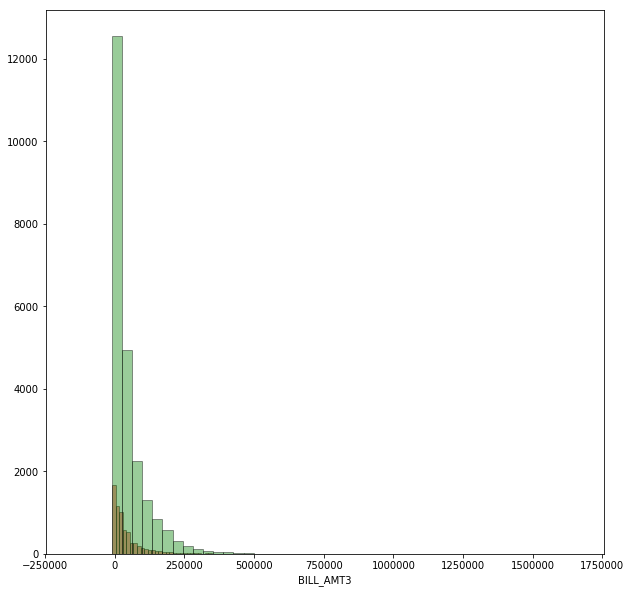

In [96]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT3'], kde=False, hist=True,bins=50,color='red',hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['BILL_AMT3'], kde=False, hist=True,bins=50,color='green',hist_kws={'edgecolor':'black'})

<u> Kernal Density:

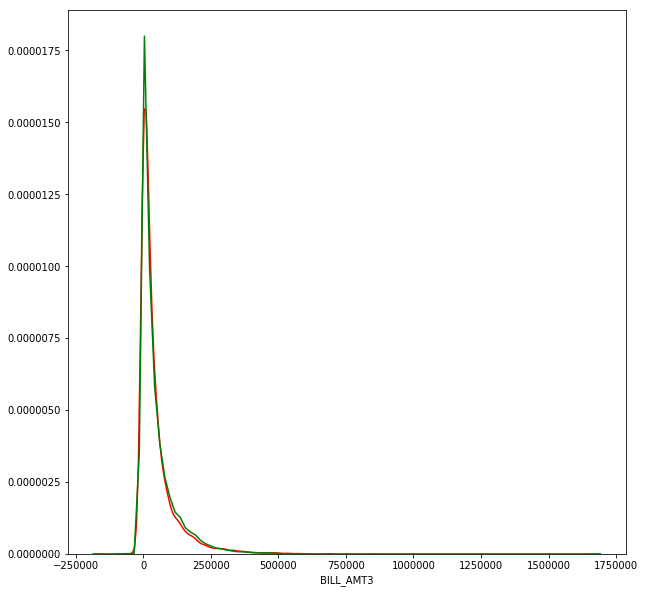

In [97]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT3'], kde=True, hist=False,bins=50,color='red')
sns.distplot(non_defaulters['BILL_AMT3'], kde=True, hist=False,bins=50,color='green')

- **Bill Amount for June 2005** 

1. What is the distribution?

In [98]:
dt['BILL_AMT4'].describe()

count     30000.000000
mean      43262.948967
std       64332.856134
min     -170000.000000
25%        2326.750000
50%       19052.000000
75%       54506.000000
max      891586.000000
Name: BILL_AMT4, dtype: float64

<u>Histogram:

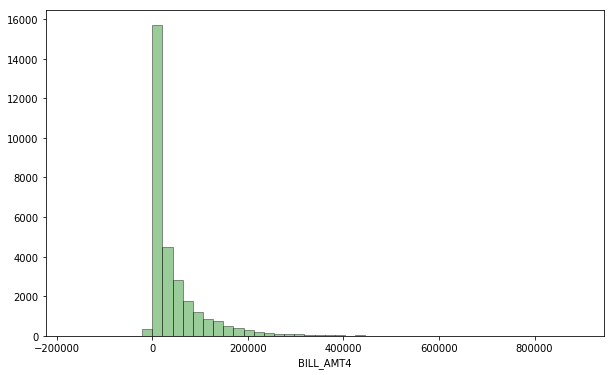

In [99]:
plt.figure(figsize=(10,6))
sns.distplot(dt['BILL_AMT4'], kde=False, hist=True,bins=50,color='Green',hist_kws={'edgecolor':'black'})

2. What is the distribution of __defaulters__ and __non-defaulters__?

<u>__Defaulters__:

In [100]:
defaulters['BILL_AMT4'].describe()

count      6636.000000
mean      42036.950573
std       64351.076092
min      -65167.000000
25%        2141.500000
50%       19119.500000
75%       50175.750000
max      548020.000000
Name: BILL_AMT4, dtype: float64

<u>__Non-Defaulters__:

In [101]:
non_defaulters['BILL_AMT4'].describe()

count     23364.000000
mean      43611.165254
std       64324.796730
min     -170000.000000
25%        2360.000000
50%       19000.000000
75%       55988.000000
max      891586.000000
Name: BILL_AMT4, dtype: float64

<u> Boxplot:

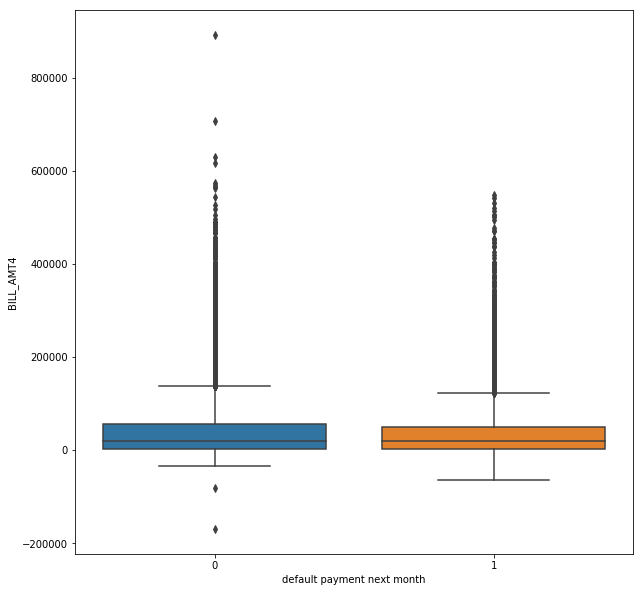

In [102]:
plt.figure(figsize=(10,10))
sns.boxplot(x='default payment next month', y='BILL_AMT4', data=dt)

<u> Histogram:

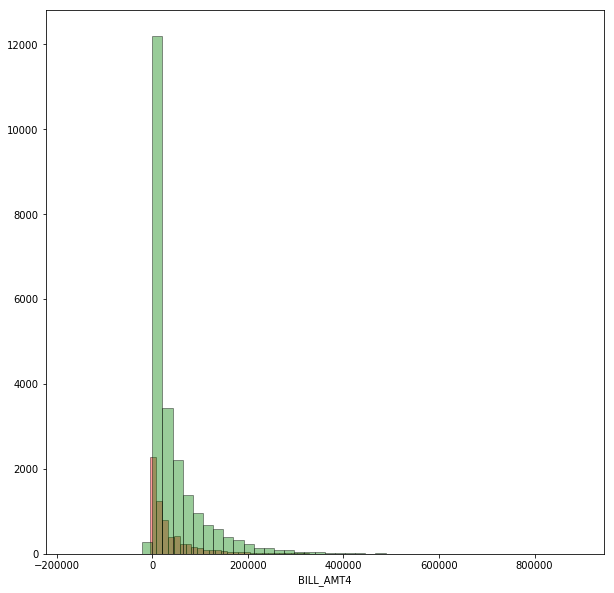

In [103]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT4'], kde=False, hist=True,bins=50,color='red',hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['BILL_AMT4'], kde=False, hist=True,bins=50,color='green',hist_kws={'edgecolor':'black'})

<u> Kernal Density:

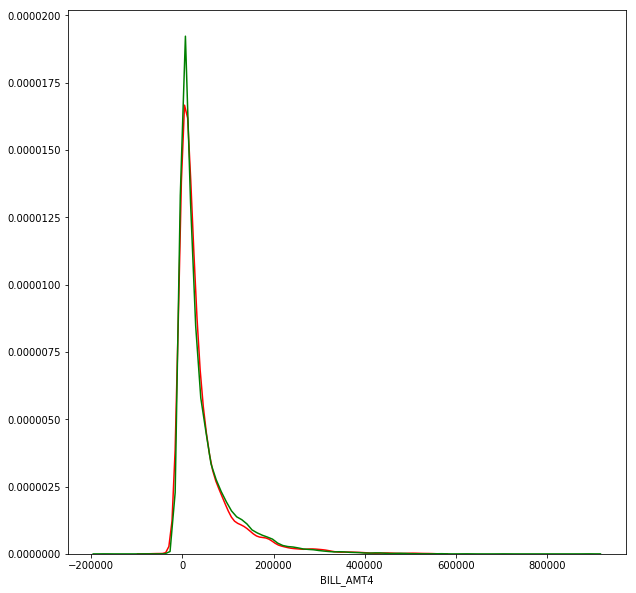

In [104]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT4'], kde=True, hist=False,bins=50,color='red')
sns.distplot(non_defaulters['BILL_AMT4'], kde=True, hist=False,bins=50,color='green')

- **Bill Amount for May 2005** 

1. What is the distribution?

In [105]:
dt['BILL_AMT5'].describe()

count     30000.000000
mean      40311.400967
std       60797.155770
min      -81334.000000
25%        1763.000000
50%       18104.500000
75%       50190.500000
max      927171.000000
Name: BILL_AMT5, dtype: float64

<u>Histogram:

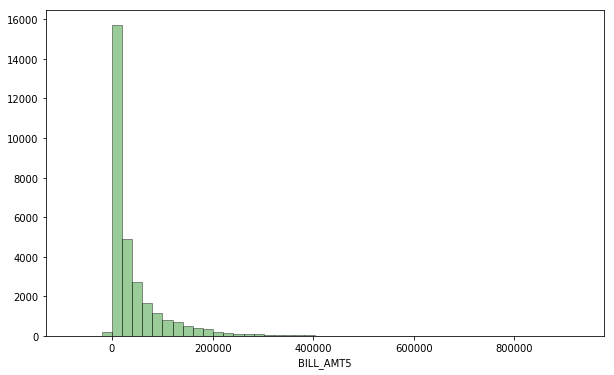

In [106]:
plt.figure(figsize=(10,6))
sns.distplot(dt['BILL_AMT5'], kde=False, hist=True,bins=50,color='Green',hist_kws={'edgecolor':'black'})

2. What is the distribution of __defaulters__ and __non-defaulters__?

<u>__Defaulters__:

In [107]:
defaulters['BILL_AMT5'].describe()

count      6636.000000
mean      39540.190476
std       61424.695949
min      -53007.000000
25%        1502.750000
50%       18478.500000
75%       47853.000000
max      547880.000000
Name: BILL_AMT5, dtype: float64

<u>__Non-Defaulters__:

In [108]:
non_defaulters['BILL_AMT5'].describe()

count     23364.000000
mean      40530.445343
std       60617.268112
min      -81334.000000
25%        1823.000000
50%       17998.000000
75%       51135.250000
max      927171.000000
Name: BILL_AMT5, dtype: float64

<u> Boxplot:

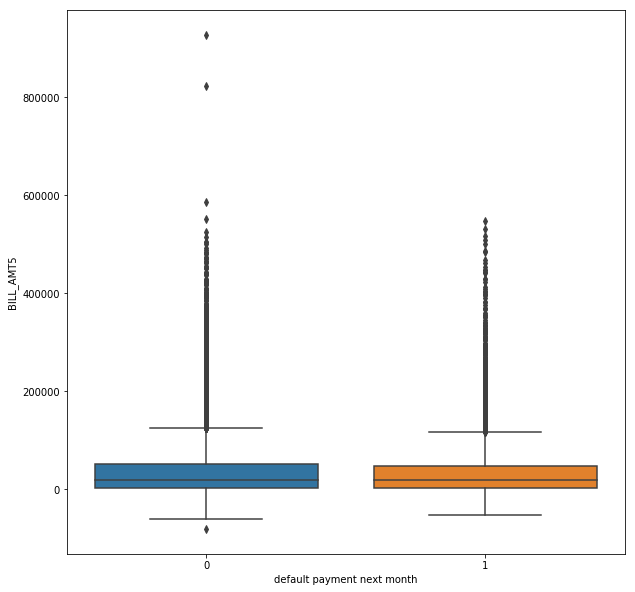

In [109]:
plt.figure(figsize=(10,10))
sns.boxplot(x='default payment next month', y='BILL_AMT5', data=dt)

<u> Histogram:

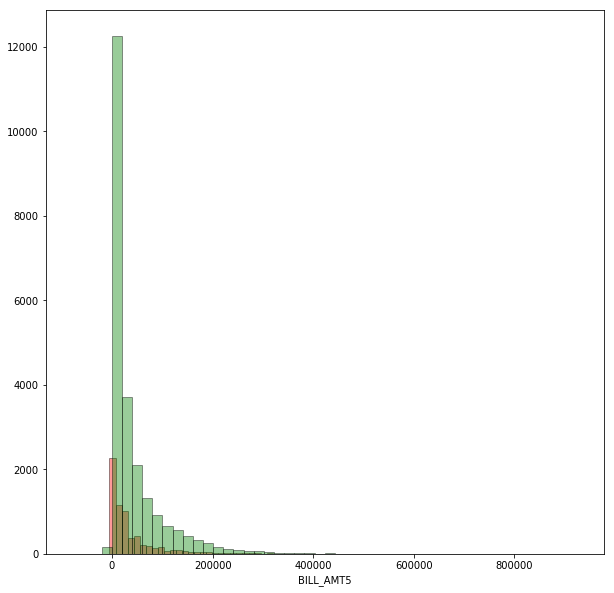

In [110]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT5'], kde=False, hist=True,bins=50,color='red',hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['BILL_AMT5'], kde=False, hist=True,bins=50,color='green',hist_kws={'edgecolor':'black'})

<u> Kernal Density:

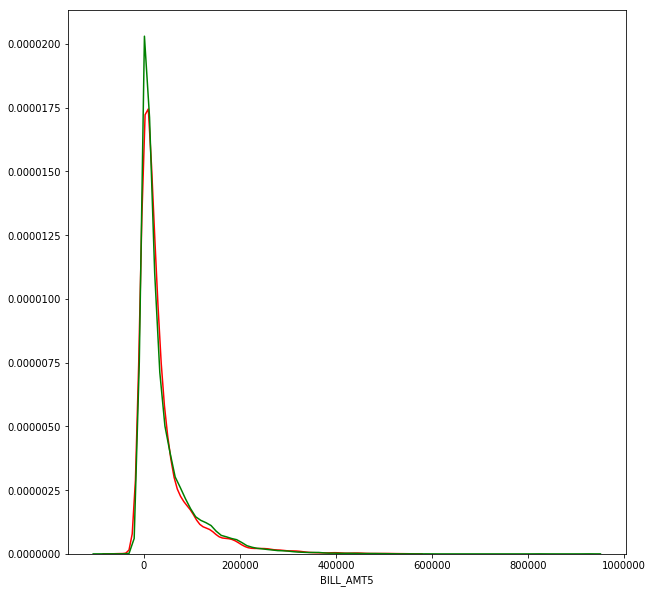

In [111]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT5'], kde=True, hist=False,bins=50,color='red')
sns.distplot(non_defaulters['BILL_AMT5'], kde=True, hist=False,bins=50,color='green')

- **Bill Amount for April 2005** 

1. What is the distribution?

In [112]:
dt['BILL_AMT6'].describe()

count     30000.000000
mean      38871.760400
std       59554.107537
min     -339603.000000
25%        1256.000000
50%       17071.000000
75%       49198.250000
max      961664.000000
Name: BILL_AMT6, dtype: float64

<u>Histogram:

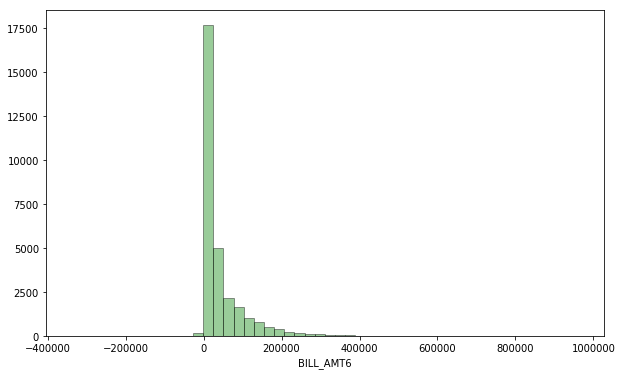

In [113]:
plt.figure(figsize=(10,6))
sns.distplot(dt['BILL_AMT6'], kde=False, hist=True,bins=50,color='Green',hist_kws={'edgecolor':'black'})

2. What is the distribution of __defaulters__ and __non-defaulters__?

<u>__Defaulters__:

In [114]:
defaulters['BILL_AMT6'].describe()

count      6636.000000
mean      38271.435503
std       59579.674268
min     -339603.000000
25%        1150.000000
50%       18028.500000
75%       47424.000000
max      514975.000000
Name: BILL_AMT6, dtype: float64

<u>__Non-Defaulters__:

In [115]:
non_defaulters['BILL_AMT6'].describe()

count     23364.000000
mean      39042.268704
std       59547.015717
min     -209051.000000
25%        1265.500000
50%       16679.000000
75%       49842.500000
max      961664.000000
Name: BILL_AMT6, dtype: float64

<u> Boxplot:

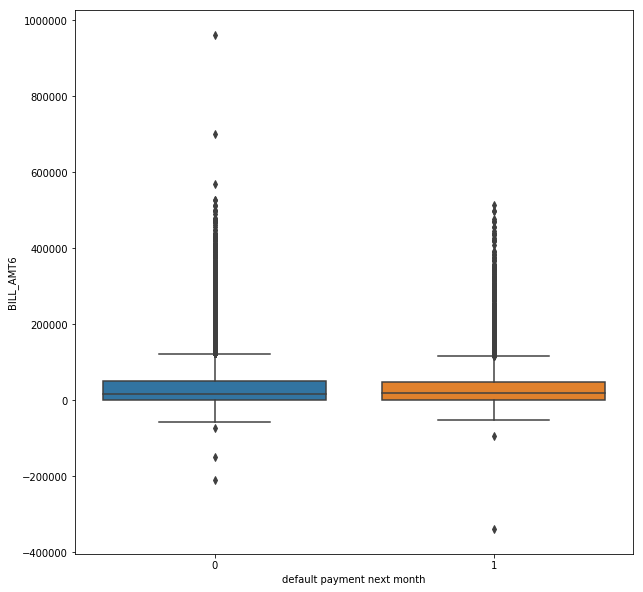

In [116]:
plt.figure(figsize=(10,10))
sns.boxplot(x='default payment next month', y='BILL_AMT6', data=dt)

<u> Histogram:

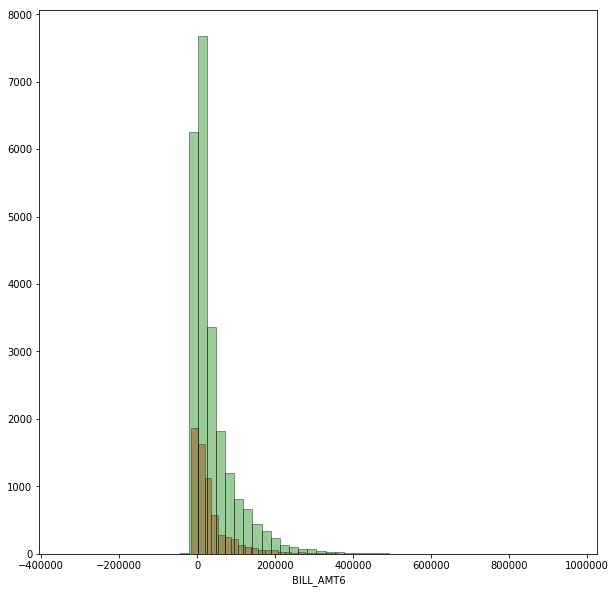

In [117]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT6'], kde=False, hist=True,bins=50,color='red',hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['BILL_AMT6'], kde=False, hist=True,bins=50,color='green',hist_kws={'edgecolor':'black'})

<u> Kernal Density:

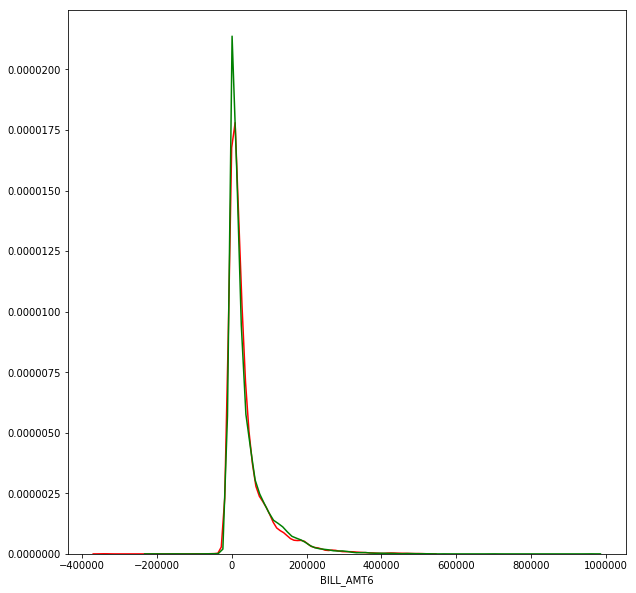

In [118]:
plt.figure(figsize=(10,10))
sns.distplot(defaulters['BILL_AMT6'], kde=True, hist=False,bins=50,color='red')
sns.distplot(non_defaulters['BILL_AMT6'], kde=True, hist=False,bins=50,color='green')

## <u> PAYMENT (HISTORY)<u>:

- **Payment for Sept 2005** 

1. What is the distribution?

In [119]:
dt['PAY_AMT1'].describe()

count     30000.000000
mean       5663.580500
std       16563.280354
min           0.000000
25%        1000.000000
50%        2100.000000
75%        5006.000000
max      873552.000000
Name: PAY_AMT1, dtype: float64

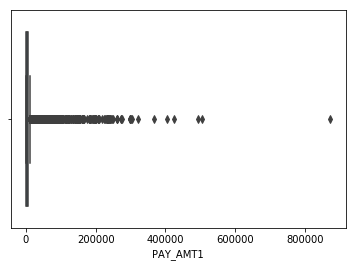

In [120]:
sns.boxplot(x='PAY_AMT1',data=dt)

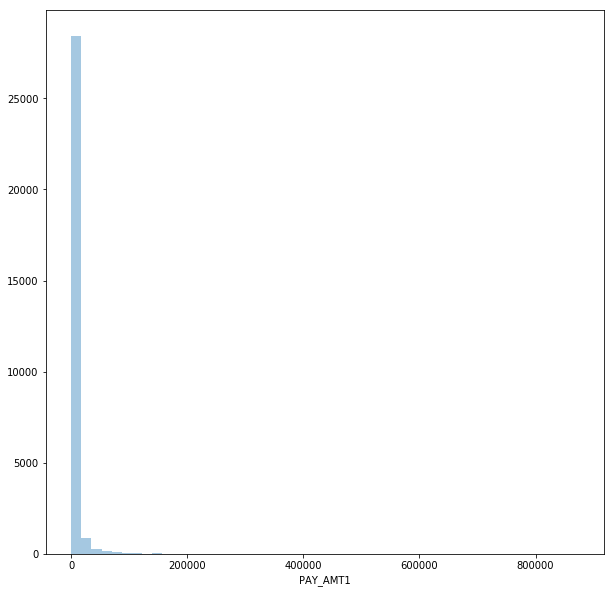

In [121]:
plt.figure(figsize=(10,10))
sns.distplot(dt['PAY_AMT1'], bins=50, kde=False)

2.What is the distribution in case of __defaulters__ and __non-defaulters__? 

<u>__De-faulters__:

In [122]:
defaulters['PAY_AMT1'].describe()

count      6636.000000
mean       3397.044153
std        9544.252427
min           0.000000
25%           0.000000
50%        1636.000000
75%        3478.250000
max      300000.000000
Name: PAY_AMT1, dtype: float64

<u>__Non-faulters__:

In [123]:
non_defaulters['PAY_AMT1'].describe()

count     23364.000000
mean       6307.337357
std       18014.508990
min           0.000000
25%        1163.750000
50%        2459.500000
75%        5606.250000
max      873552.000000
Name: PAY_AMT1, dtype: float64

<u> Boxplots:

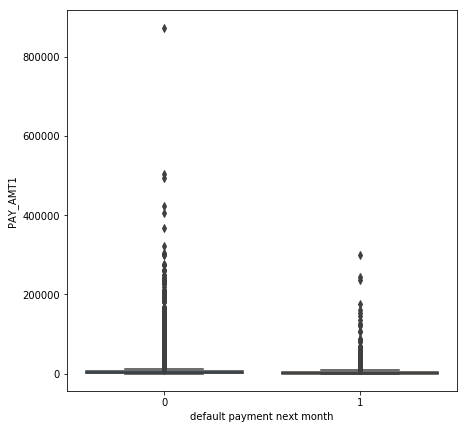

In [124]:
plt.figure(figsize=(7,7))
sns.boxplot(x='default payment next month', y='PAY_AMT1', data=dt)

<u> Histogram:

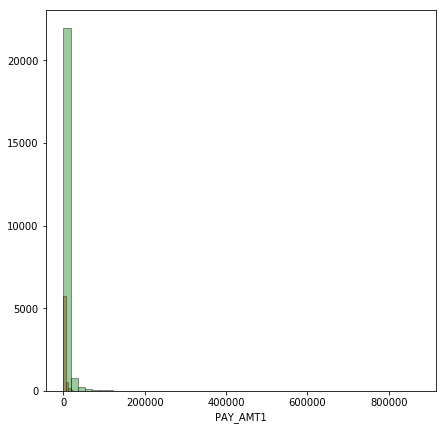

In [125]:
plt.figure(figsize=(7,7))
sns.distplot(defaulters['PAY_AMT1'],bins=50, kde=False,color='red', hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['PAY_AMT1'],bins=50, kde=False,color='green', hist_kws={'edgecolor':'black'})

<u> Kernal Density:

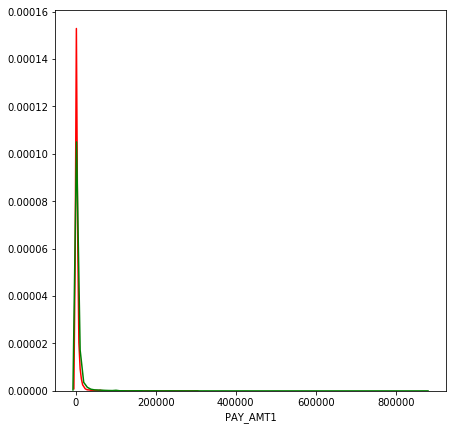

In [126]:
plt.figure(figsize=(7,7))
sns.distplot(defaulters['PAY_AMT1'],bins=50, kde=True,hist=False,color='red')
sns.distplot(non_defaulters['PAY_AMT1'],bins=50, kde=True,hist=False,color='green')

<u> Bucket analysis:

In [127]:
dt['PAY_AMT1_BUCKET']= np.where((dt['PAY_AMT1'] >-1) & (dt['PAY_AMT1'] <10000),'Normal',
                       np.where((dt['PAY_AMT1'] > 10000) & (dt['PAY_AMT1'] <20000),'High','Abormal'))         
defaulters['PAY_AMT1_BUCKET']= np.where((defaulters['PAY_AMT1'] >-1) & (defaulters['PAY_AMT1'] <10000),'Normal',
                       np.where((defaulters['PAY_AMT1'] > 10000) & (defaulters['PAY_AMT1'] <20000),'High','Abormal'))         
non_defaulters['PAY_AMT1_BUCKET']= np.where((non_defaulters['PAY_AMT1'] >-1) & (non_defaulters['PAY_AMT1'] <10000),'Normal',
                       np.where((non_defaulters['PAY_AMT1'] > 10000) & (non_defaulters['PAY_AMT1'] <20000),'High','Abormal'))         

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [128]:
(dt['PAY_AMT1_BUCKET']).value_counts()/len(dt)*100

Normal     87.88
High        6.12
Abormal     6.00
Name: PAY_AMT1_BUCKET, dtype: float64

<u> __Complete data:__

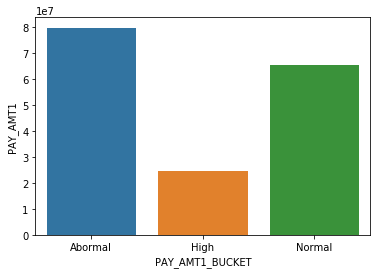

In [129]:
agg_dt = dt.groupby(by=['PAY_AMT1_BUCKET'])['PAY_AMT1'].sum().reset_index()
sns.barplot(x='PAY_AMT1_BUCKET',y='PAY_AMT1', data=agg_dt )

<u> __Defaulters:__

In [130]:
(defaulters['PAY_AMT1_BUCKET']).value_counts()/len(defaulters)*100

Normal     93.384569
High        4.068716
Abormal     2.546715
Name: PAY_AMT1_BUCKET, dtype: float64

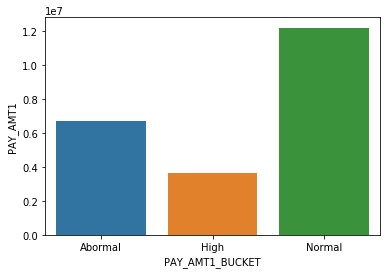

In [131]:
agg_dt = defaulters.groupby(by=['PAY_AMT1_BUCKET'])['PAY_AMT1'].sum().reset_index()
sns.barplot(x='PAY_AMT1_BUCKET',y='PAY_AMT1', data=agg_dt )

<u> __Non-Defaulters:__

In [132]:
(non_defaulters['PAY_AMT1_BUCKET']).value_counts()/len(non_defaulters)*100

Normal     86.316555
Abormal     6.980825
High        6.702619
Name: PAY_AMT1_BUCKET, dtype: float64

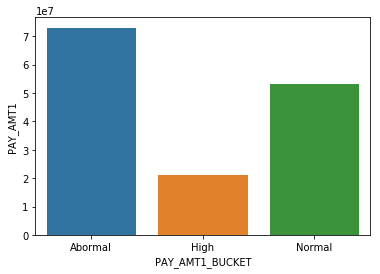

In [133]:
agg_dt = non_defaulters.groupby(by=['PAY_AMT1_BUCKET'])['PAY_AMT1'].sum().reset_index()
sns.barplot(x='PAY_AMT1_BUCKET',y='PAY_AMT1', data=agg_dt )

__Information__: The above payment bucket charts shows that in __defaulters__ case the __normal payments (0-10,000)__ make up the highest aggregated sum whereas, in case of __non-defaulters__ the __abnormal payments (20,000 onwards)__ make up the major section of it. 

Text(0.5, 0, 'Non-faulters')

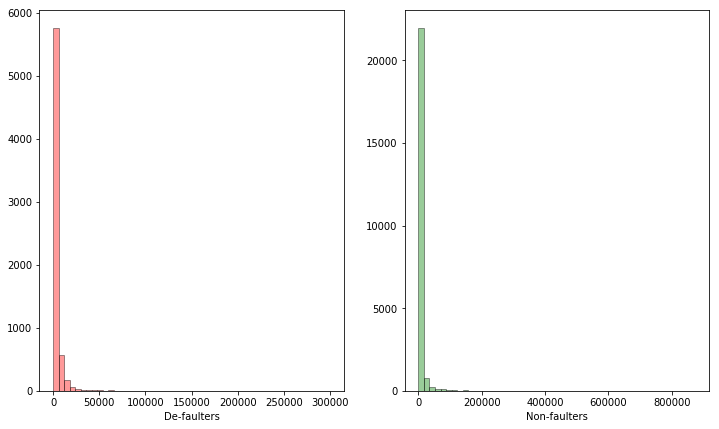

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,7))
sns.distplot(defaulters['PAY_AMT1'],bins=50, kde=False,color='red', hist_kws={'edgecolor':'black'},ax=ax[0])
ax[0].set_xlabel('De-faulters')
sns.distplot(non_defaulters['PAY_AMT1'],bins=50, kde=False,color='green', hist_kws={'edgecolor':'black'},ax=ax[1])
ax[1].set_xlabel('Non-faulters')

Text(0.5, 0, 'Non-faulters')

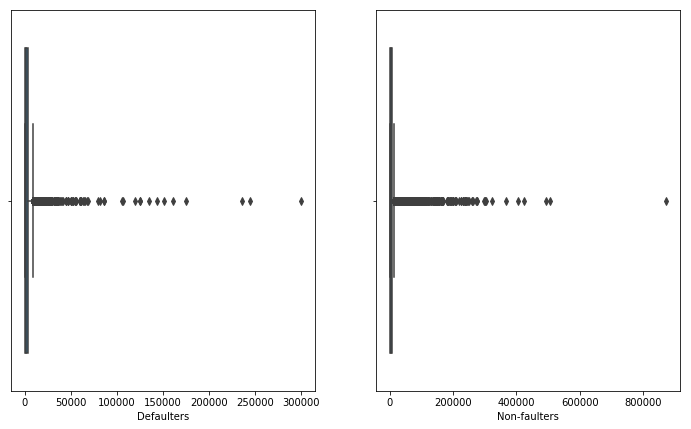

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(12,7))
sns.boxplot(x='PAY_AMT1',data=defaulters,ax=ax[0])
ax[0].set_xlabel('Defaulters')
sns.boxplot(x='PAY_AMT1',data=non_defaulters,ax=ax[1])
ax[1].set_xlabel('Non-faulters')

- **Payment for Aug 2005** 

1. What is the distribution?

In [136]:
dt['PAY_AMT2'].describe()

count    3.000000e+04
mean     5.921163e+03
std      2.304087e+04
min      0.000000e+00
25%      8.330000e+02
50%      2.009000e+03
75%      5.000000e+03
max      1.684259e+06
Name: PAY_AMT2, dtype: float64

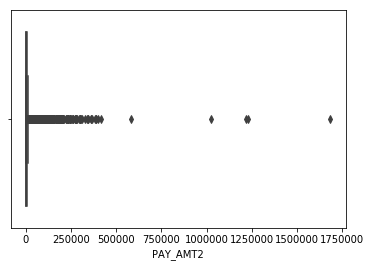

In [137]:
sns.boxplot(x='PAY_AMT2',data=dt)

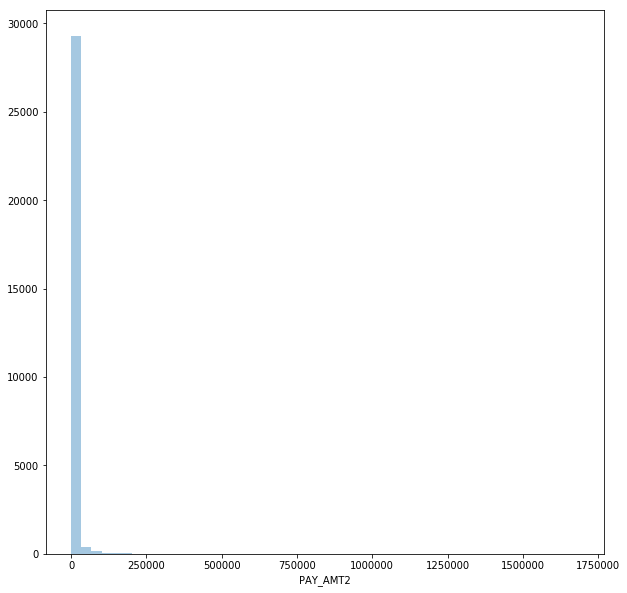

In [138]:
plt.figure(figsize=(10,10))
sns.distplot(dt['PAY_AMT2'], bins=50, kde=False)

2.What is the distribution in case of __defaulters__ and __non-defaulters__? 

<u>__De-faulters__:

In [139]:
defaulters['PAY_AMT2'].describe()

count      6636.000000
mean       3388.649638
std       11737.986064
min           0.000000
25%           0.000000
50%        1533.500000
75%        3309.750000
max      358689.000000
Name: PAY_AMT2, dtype: float64

<u>__Non-faulters__:

In [140]:
pd.options.display.float_format = '{:.2f}'.format

In [141]:
non_defaulters['PAY_AMT2'].describe()

count     23364.00
mean       6640.47
std       25302.26
min           0.00
25%        1005.00
50%        2247.50
75%        5311.25
max     1684259.00
Name: PAY_AMT2, dtype: float64

<u> Boxplots:

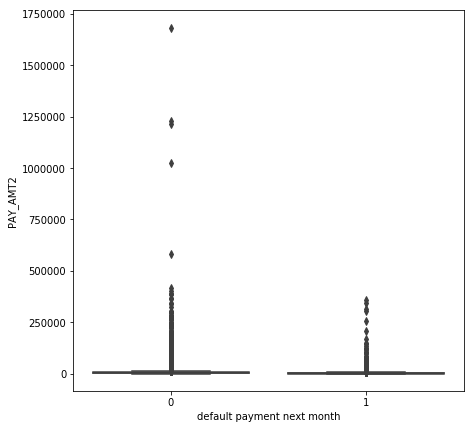

In [142]:
plt.figure(figsize=(7,7))
sns.boxplot(x='default payment next month', y='PAY_AMT2', data=dt)

<u> Histogram:

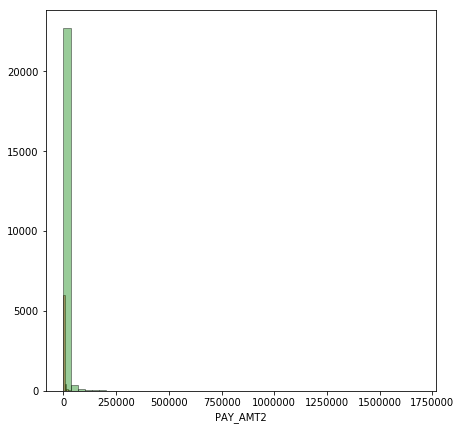

In [143]:
plt.figure(figsize=(7,7))
sns.distplot(defaulters['PAY_AMT2'],bins=50, kde=False,color='red', hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['PAY_AMT2'],bins=50, kde=False,color='green', hist_kws={'edgecolor':'black'})

<u> Kernal Density:

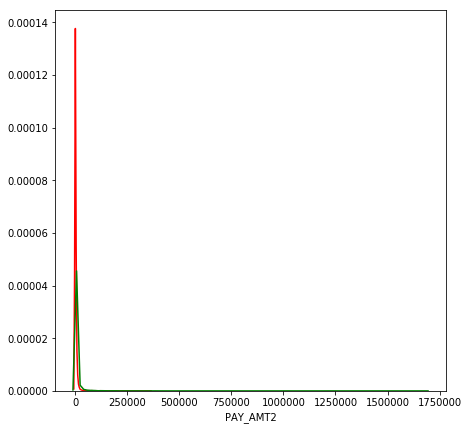

In [144]:
plt.figure(figsize=(7,7))
sns.distplot(defaulters['PAY_AMT2'],bins=50, kde=True,hist=False,color='red')
sns.distplot(non_defaulters['PAY_AMT2'],bins=50, kde=True,hist=False,color='green')

<u> Bucket analysis:

In [145]:
dt['PAY_AMT2_BUCKET']= np.where((dt['PAY_AMT2'] >-1) & (dt['PAY_AMT2'] <10000),'Normal',
                       np.where((dt['PAY_AMT2'] > 10000) & (dt['PAY_AMT2'] <20000),'High','Abormal'))         
defaulters['PAY_AMT2_BUCKET']= np.where((defaulters['PAY_AMT2'] >-1) & (defaulters['PAY_AMT2'] <10000),'Normal',
                       np.where((defaulters['PAY_AMT2'] > 10000) & (defaulters['PAY_AMT2'] <20000),'High','Abormal'))         
non_defaulters['PAY_AMT2_BUCKET']= np.where((non_defaulters['PAY_AMT2'] >-1) & (non_defaulters['PAY_AMT2'] <10000),'Normal',
                       np.where((non_defaulters['PAY_AMT2'] > 10000) & (non_defaulters['PAY_AMT2'] <20000),'High','Abormal'))         

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [146]:
(dt['PAY_AMT2_BUCKET']).value_counts()/len(dt)*100

Normal    88.10
High       6.08
Abormal    5.83
Name: PAY_AMT2_BUCKET, dtype: float64

<u> __Complete data:__

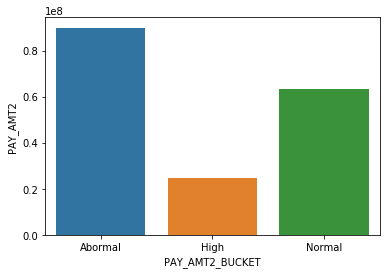

In [147]:
agg_dt = dt.groupby(by=['PAY_AMT2_BUCKET'])['PAY_AMT2'].sum().reset_index()
sns.barplot(x='PAY_AMT2_BUCKET',y='PAY_AMT2', data=agg_dt )

<u> __Defaulters:__

In [148]:
(defaulters['PAY_AMT2_BUCKET']).value_counts()/len(defaulters)*100

Normal    94.02
High       3.86
Abormal    2.12
Name: PAY_AMT2_BUCKET, dtype: float64

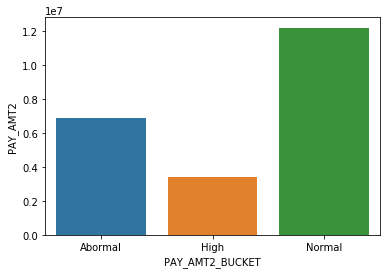

In [149]:
agg_dt = defaulters.groupby(by=['PAY_AMT2_BUCKET'])['PAY_AMT2'].sum().reset_index()
sns.barplot(x='PAY_AMT2_BUCKET',y='PAY_AMT2', data=agg_dt )

<u> __Non-Defaulters:__

In [150]:
(non_defaulters['PAY_AMT2_BUCKET']).value_counts()/len(non_defaulters)*100

Normal    86.41
Abormal    6.88
High       6.71
Name: PAY_AMT2_BUCKET, dtype: float64

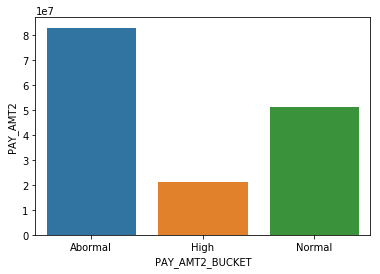

In [151]:
agg_dt = non_defaulters.groupby(by=['PAY_AMT2_BUCKET'])['PAY_AMT2'].sum().reset_index()
sns.barplot(x='PAY_AMT2_BUCKET',y='PAY_AMT2', data=agg_dt )

__Information__: The above payment bucket charts shows that in __defaulters__ case the __normal payments (0-10,000)__ make up the highest aggregated sum whereas, in case of __non-defaulters__ the __abnormal payments (20,000 onwards)__ make up the major section of it. 

Text(0.5, 0, 'Non-faulters')

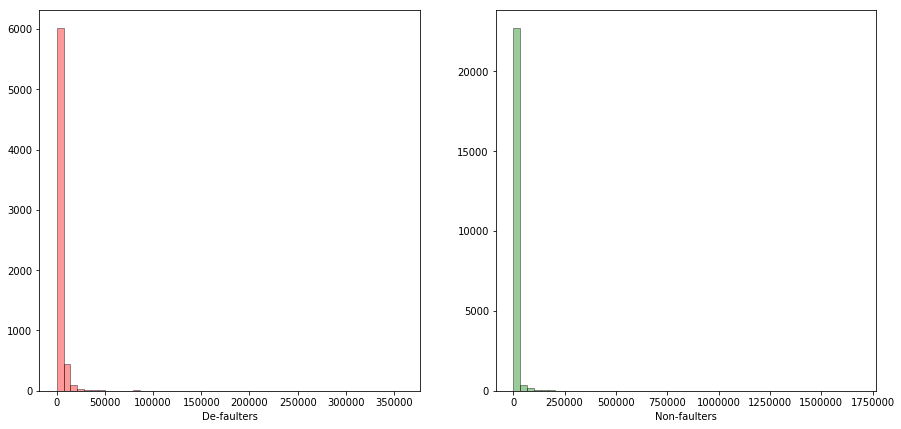

In [152]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
sns.distplot(defaulters['PAY_AMT2'],bins=50, kde=False,color='red', hist_kws={'edgecolor':'black'},ax=ax[0])
ax[0].set_xlabel('De-faulters')
sns.distplot(non_defaulters['PAY_AMT2'],bins=50, kde=False,color='green', hist_kws={'edgecolor':'black'},ax=ax[1])
ax[1].set_xlabel('Non-faulters')

Text(0.5, 0, 'Non-faulters')

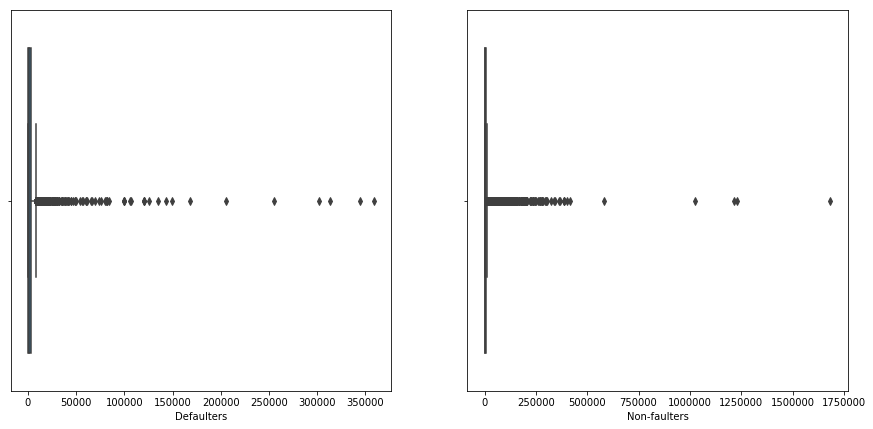

In [153]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
sns.boxplot(x='PAY_AMT2',data=defaulters,ax=ax[0])
ax[0].set_xlabel('Defaulters')
sns.boxplot(x='PAY_AMT2',data=non_defaulters,ax=ax[1])
ax[1].set_xlabel('Non-faulters')

- **Payment for July 2005** 

1. What is the distribution?

In [154]:
dt['PAY_AMT3'].describe()

count    30000.00
mean      5225.68
std      17606.96
min          0.00
25%        390.00
50%       1800.00
75%       4505.00
max     896040.00
Name: PAY_AMT3, dtype: float64

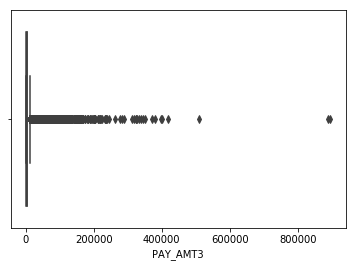

In [155]:
sns.boxplot(x='PAY_AMT3',data=dt)

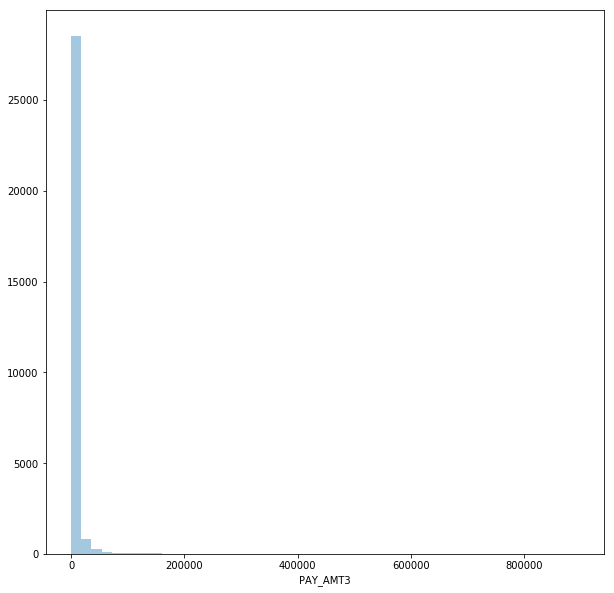

In [156]:
plt.figure(figsize=(10,10))
sns.distplot(dt['PAY_AMT3'], bins=50, kde=False)

2.What is the distribution in case of __defaulters__ and __non-defaulters__? 

<u>__De-faulters__:

In [157]:
defaulters['PAY_AMT3'].describe()

count     6636.00
mean      3367.35
std      12959.62
min          0.00
25%          0.00
50%       1222.00
75%       3000.00
max     508229.00
Name: PAY_AMT3, dtype: float64

<u>__Non-faulters__:

In [158]:
pd.options.display.float_format = '{:.2f}'.format

In [159]:
non_defaulters['PAY_AMT3'].describe()

count    23364.00
mean      5753.50
std      18684.26
min          0.00
25%        600.00
50%       2000.00
75%       5000.00
max     896040.00
Name: PAY_AMT3, dtype: float64

<u> Boxplots:

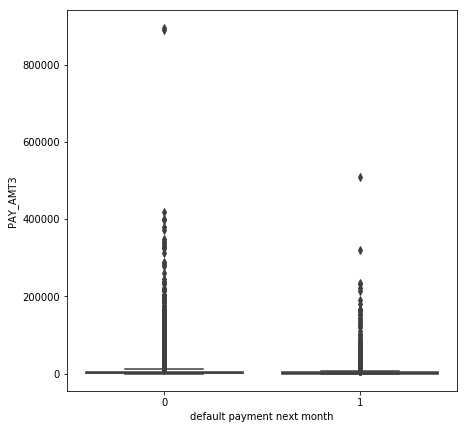

In [160]:
plt.figure(figsize=(7,7))
sns.boxplot(x='default payment next month', y='PAY_AMT3', data=dt)

<u> Histogram:

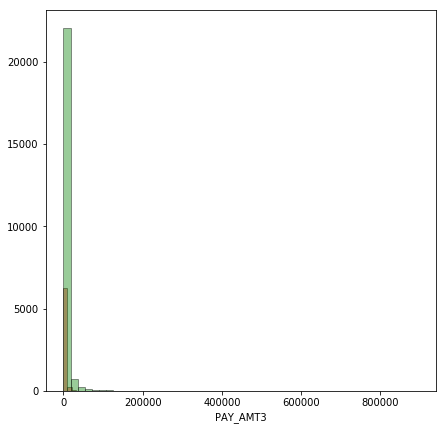

In [161]:
plt.figure(figsize=(7,7))
sns.distplot(defaulters['PAY_AMT3'],bins=50, kde=False,color='red', hist_kws={'edgecolor':'black'})
sns.distplot(non_defaulters['PAY_AMT3'],bins=50, kde=False,color='green', hist_kws={'edgecolor':'black'})

<u> Kernal Density:

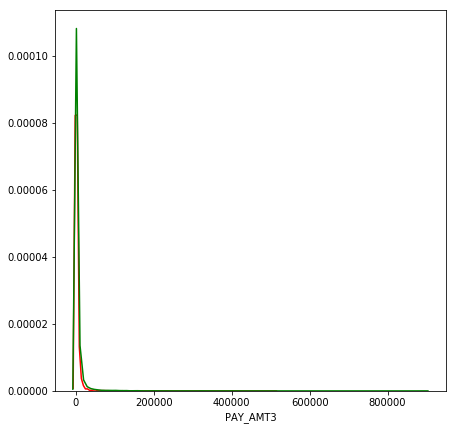

In [162]:
plt.figure(figsize=(7,7))
sns.distplot(defaulters['PAY_AMT3'],bins=50, kde=True,hist=False,color='red')
sns.distplot(non_defaulters['PAY_AMT3'],bins=50, kde=True,hist=False,color='green')

<u> Bucket analysis:

In [163]:
dt['PAY_AMT3_BUCKET']= np.where((dt['PAY_AMT3'] >-1) & (dt['PAY_AMT3'] <10000),'Normal',
                       np.where((dt['PAY_AMT3'] > 10000) & (dt['PAY_AMT3'] <20000),'High','Abormal'))         
defaulters['PAY_AMT3_BUCKET']= np.where((defaulters['PAY_AMT3'] >-1) & (defaulters['PAY_AMT3'] <10000),'Normal',
                       np.where((defaulters['PAY_AMT3'] > 10000) & (defaulters['PAY_AMT3'] <20000),'High','Abormal'))         
non_defaulters['PAY_AMT3_BUCKET']= np.where((non_defaulters['PAY_AMT3'] >-1) & (non_defaulters['PAY_AMT3'] <10000),'Normal',
                       np.where((non_defaulters['PAY_AMT3'] > 10000) & (non_defaulters['PAY_AMT3'] <20000),'High','Abormal'))         

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [164]:
(dt['PAY_AMT3_BUCKET']).value_counts()/len(dt)*100

Normal    89.38
Abormal    5.50
High       5.12
Name: PAY_AMT3_BUCKET, dtype: float64

<u> __Complete data:__

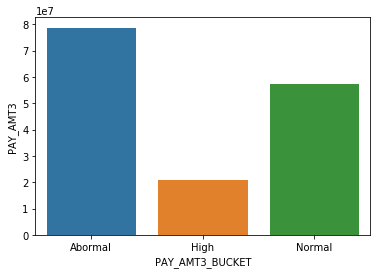

In [165]:
agg_dt = dt.groupby(by=['PAY_AMT3_BUCKET'])['PAY_AMT3'].sum().reset_index()
sns.barplot(x='PAY_AMT3_BUCKET',y='PAY_AMT3', data=agg_dt )

<u> __Defaulters:__

In [166]:
(defaulters['PAY_AMT3_BUCKET']).value_counts()/len(defaulters)*100

Normal    94.00
High       3.59
Abormal    2.41
Name: PAY_AMT3_BUCKET, dtype: float64

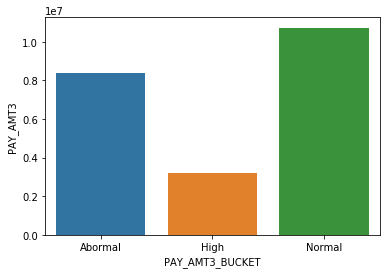

In [167]:
agg_dt = defaulters.groupby(by=['PAY_AMT3_BUCKET'])['PAY_AMT3'].sum().reset_index()
sns.barplot(x='PAY_AMT3_BUCKET',y='PAY_AMT3', data=agg_dt )

<u> __Non-Defaulters:__

In [168]:
(non_defaulters['PAY_AMT3_BUCKET']).value_counts()/len(non_defaulters)*100

Normal    88.07
Abormal    6.38
High       5.55
Name: PAY_AMT3_BUCKET, dtype: float64

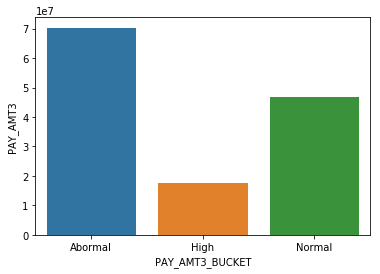

In [169]:
agg_dt = non_defaulters.groupby(by=['PAY_AMT3_BUCKET'])['PAY_AMT3'].sum().reset_index()
sns.barplot(x='PAY_AMT3_BUCKET',y='PAY_AMT3', data=agg_dt )

__Information__: The above payment bucket charts shows that in __defaulters__ case the __normal payments (0-10,000)__ make up the highest aggregated sum whereas, in case of __non-defaulters__ the __abnormal payments (20,000 onwards)__ make up the major section of it. 

Text(0.5, 0, 'Non-faulters')

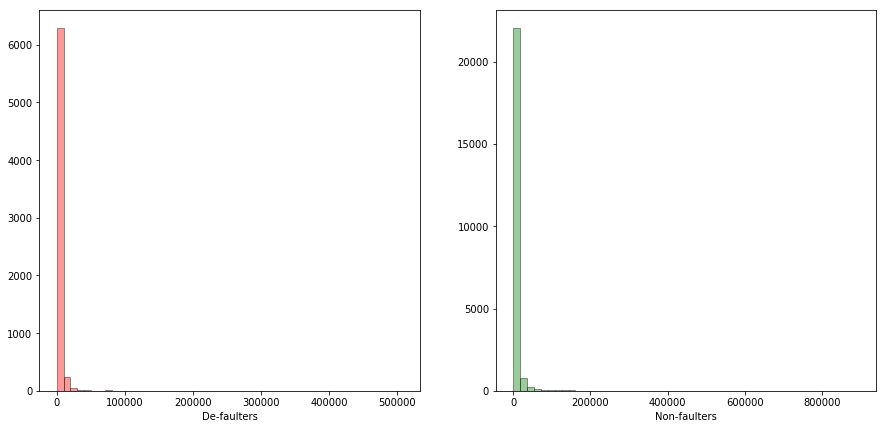

In [170]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
sns.distplot(defaulters['PAY_AMT3'],bins=50, kde=False,color='red', hist_kws={'edgecolor':'black'},ax=ax[0])
ax[0].set_xlabel('De-faulters')
sns.distplot(non_defaulters['PAY_AMT3'],bins=50, kde=False,color='green', hist_kws={'edgecolor':'black'},ax=ax[1])
ax[1].set_xlabel('Non-faulters')

Text(0.5, 0, 'Non-faulters')

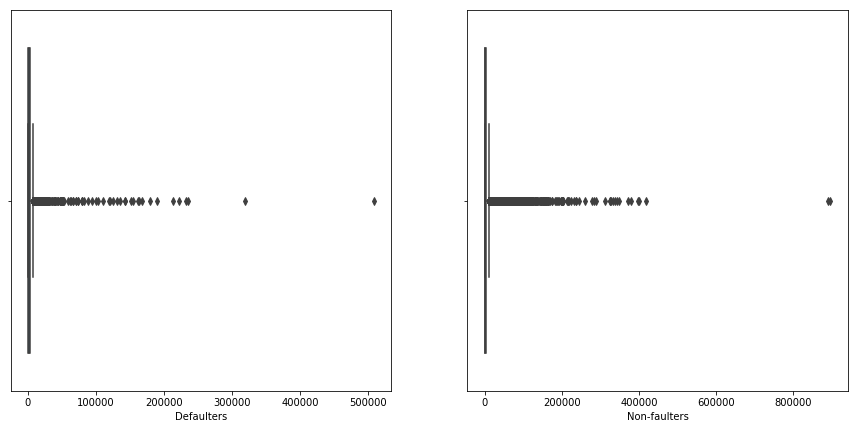

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15,7))
sns.boxplot(x='PAY_AMT3',data=defaulters,ax=ax[0])
ax[0].set_xlabel('Defaulters')
sns.boxplot(x='PAY_AMT3',data=non_defaulters,ax=ax[1])
ax[1].set_xlabel('Non-faulters')

- **Gender** 

1. What is the gender ratio in complete dataset? 1-> Male and 2-> Female

In [172]:
frequency_gender_tbl = pd.crosstab(dt['SEX'],'frequency').reset_index()

In [173]:
frequency_gender_tbl

col_0,SEX,frequency
0,1,11888
1,2,18112


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


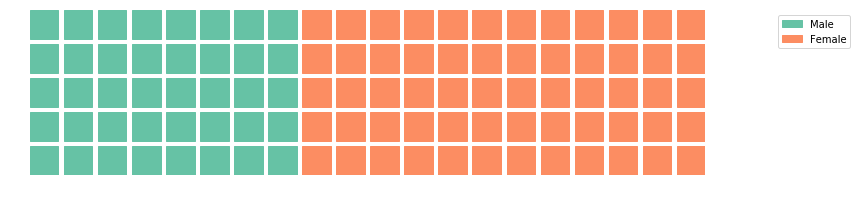

In [174]:
data = {'Male': 11888, 'Female': 18112}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

2. Is there any **visual impact** on the gender ratio for **defaulters** and **Non-defaulters**? 

_Defaulters_:

In [175]:
frequency_df_gender_tbl = pd.crosstab(defaulters['SEX'],'frequency').reset_index()
frequency_df_gender_tbl

col_0,SEX,frequency
0,1,2873
1,2,3763


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


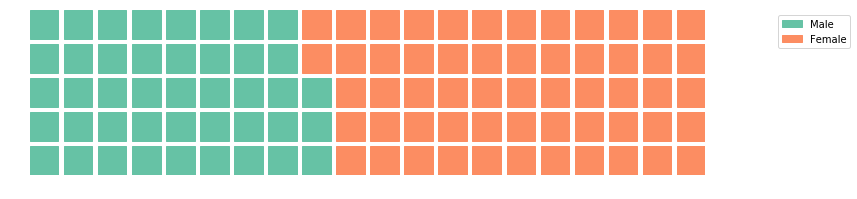

In [176]:
data = {'Male': 2873, 'Female': 3763}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

_Non-Defaulters_:

In [177]:
frequency_nondf_gender_tbl = pd.crosstab(non_defaulters['SEX'],'frequency').reset_index()

/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


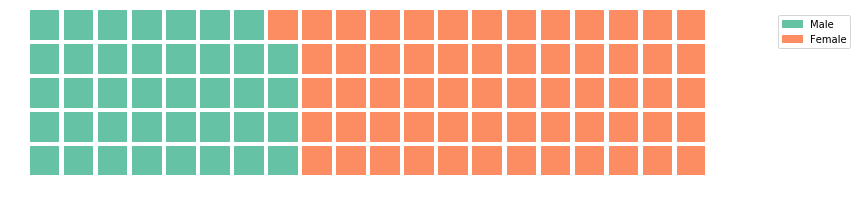

In [178]:
data = {'Male': 9015, 'Female': 14349}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

**Insights**:

- **MARRIAGE** 

1. What is the marriage ratio in complete dataset? (1 = married; 2 = single; 3 = others)

In [179]:
frequency_marriage_tbl = pd.crosstab(dt['MARRIAGE'],'frequency').reset_index()

In [180]:
frequency_marriage_tbl

col_0,MARRIAGE,frequency
0,0,54
1,1,13659
2,2,15964
3,3,323


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


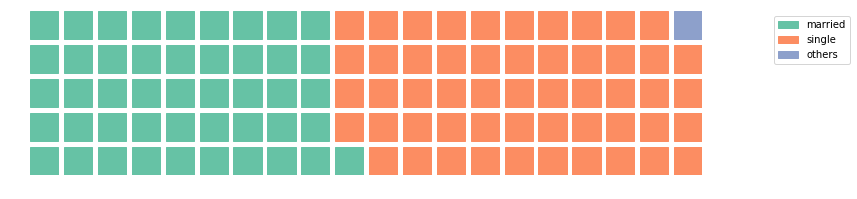

In [181]:
data = {'married': 13659, 'single': 15964, 'others': 323}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

2. Is there any **visual impact** in marraige ratio for **defaulters** and **non-defaulters**?

_Defaulters_:

In [182]:
frequency_df_marriage_tbl = pd.crosstab(defaulters['MARRIAGE'],'frequency').reset_index()

In [183]:
frequency_df_marriage_tbl

col_0,MARRIAGE,frequency
0,0,5
1,1,3206
2,2,3341
3,3,84


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


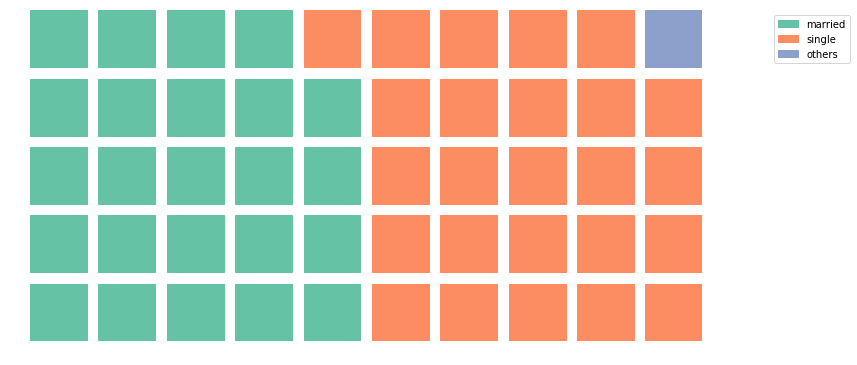

In [184]:
data = {'married': 3206, 'single': 3341, 'others': 84}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

_Non-Defaulters_:

In [185]:
frequency_nondf_marriage_tbl = pd.crosstab(non_defaulters['MARRIAGE'],'frequency').reset_index()

In [186]:
frequency_nondf_marriage_tbl

col_0,MARRIAGE,frequency
0,0,49
1,1,10453
2,2,12623
3,3,239


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


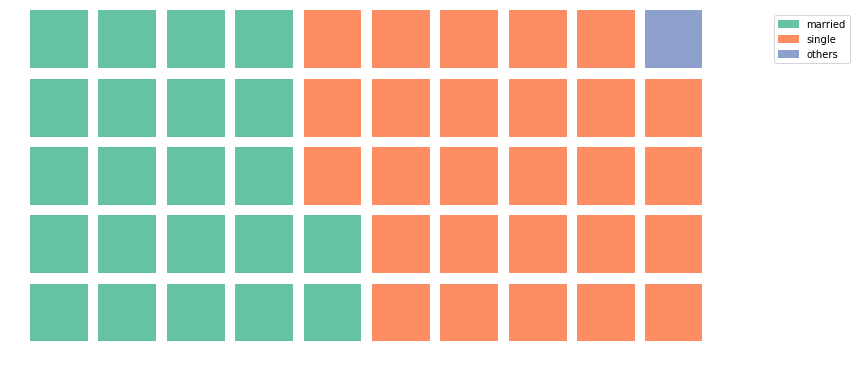

In [187]:
data = {'married': 10453, 'single': 12623, 'others': 239}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=10, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

- **AGE**

1. What is the Age distribution in complete dataset?

In [188]:
age = dt['AGE']

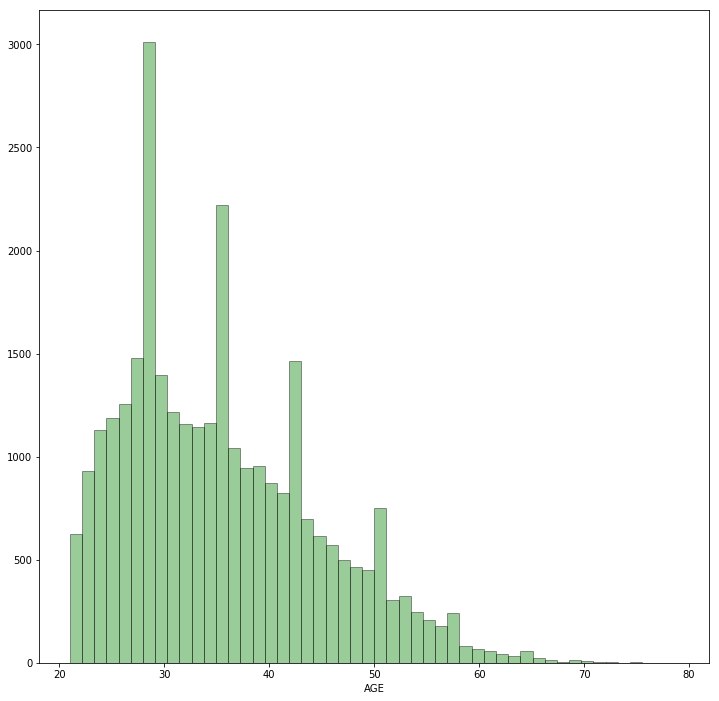

In [189]:
plt.figure(figsize=(12,12))
sns.distplot(age,hist=True,kde=False, color='Green',bins=50, hist_kws={'edgecolor':'black'})

2. Is there any **Visual impact** on the distribution of Age for **defaulters** and **non-defaulters**?

_Defaulters_:

In [190]:
defaulter_age = defaulters['AGE']

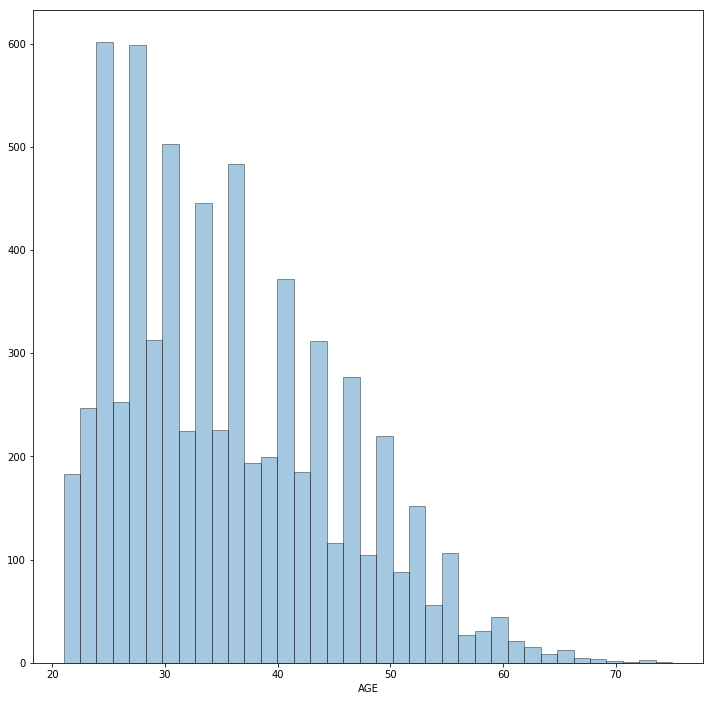

In [191]:
plt.figure(figsize=(12,12))
sns.distplot(defaulter_age, hist=True, kde=False, hist_kws={'edgecolor':'black'})

_Non-Defaulter_:

In [192]:
non_defaulter_age = non_defaulters['AGE']

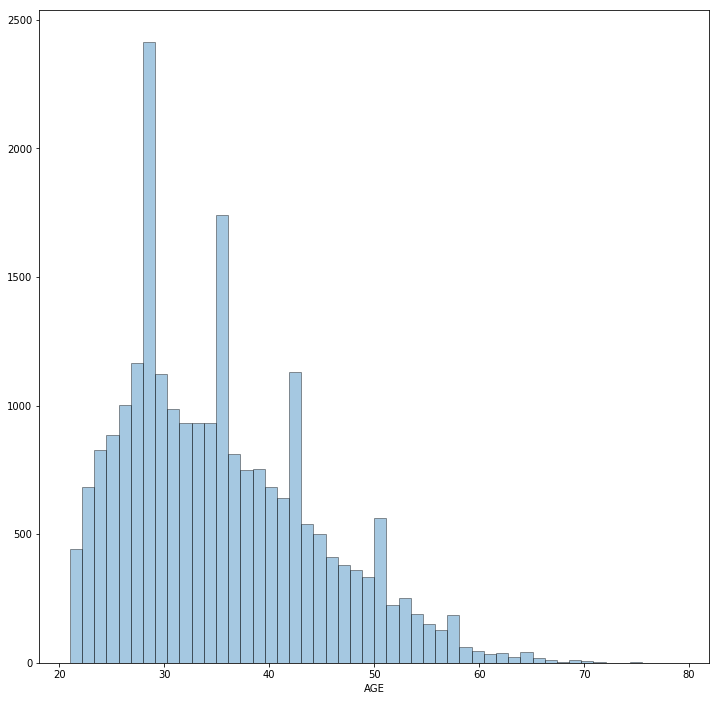

In [193]:
plt.figure(figsize=(12,12))
sns.distplot(non_defaulter_age, hist=True, kde=False, hist_kws={'edgecolor':'black'})

- **EDUCATION**

1. What is the education ratio in complete dataset?  (1 = graduate school; 2 = university; 3 = high school; 4 = others). 

In [194]:
frequency_edu_tbl = pd.crosstab(dt['EDUCATION'],'frequency').reset_index()

In [195]:
frequency_edu_tbl

col_0,EDUCATION,frequency
0,0,14
1,1,10585
2,2,14030
3,3,4917
4,4,123
5,5,280
6,6,51


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


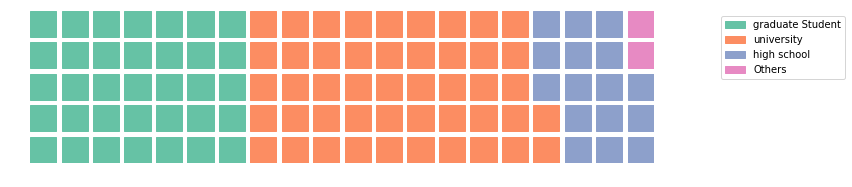

In [196]:
data = {'graduate Student': 10585, 'university': 14030, 'high school': 4917,'Others':123+280+51+14}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

2. Is there any **Visual impact** on the education ratio for **defaulters** and **non-defaulters**?

_Defaulters_:

In [197]:
frequency_df_education_tbl = pd.crosstab(defaulters['EDUCATION'],'frequency').reset_index()

In [198]:
frequency_df_education_tbl

col_0,EDUCATION,frequency
0,1,2036
1,2,3330
2,3,1237
3,4,7
4,5,18
5,6,8


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


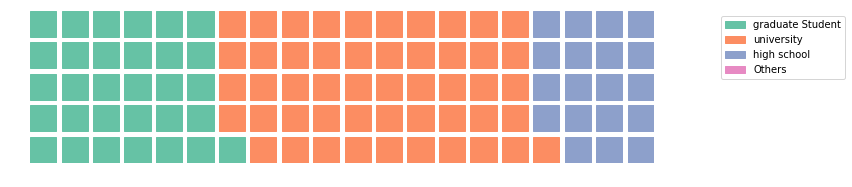

In [199]:
data = {'graduate Student': 2036, 'university': 3330, 'high school': 1237,'Others':7+18+8}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

_Non-Defaulters_:

In [200]:
frequency_nondf_education_tbl = pd.crosstab(non_defaulters['EDUCATION'],'frequency').reset_index()

In [201]:
frequency_nondf_education_tbl

col_0,EDUCATION,frequency
0,0,14
1,1,8549
2,2,10700
3,3,3680
4,4,116
5,5,262
6,6,43


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


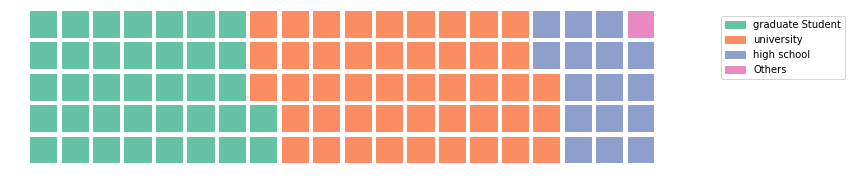

In [202]:
data = {'graduate Student': 8549, 'university': 10700, 'high school': 3680,'Others':14+116+262+43}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

****

- **Past Monthly Payment Records**

### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <font color='red'>PAY_0 | ATM_01 | PAY_ATM_01</font> 

1. What is the payment status of last month for complete dataset? -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.

In [203]:
frequency_sep_tbl = pd.crosstab(dt['PAY_0'], 'frequency').reset_index()

In [204]:
frequency_sep_tbl

col_0,PAY_0,frequency
0,-2,2759
1,-1,5686
2,0,14737
3,1,3688
4,2,2667
5,3,322
6,4,76
7,5,26
8,6,11
9,7,9


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


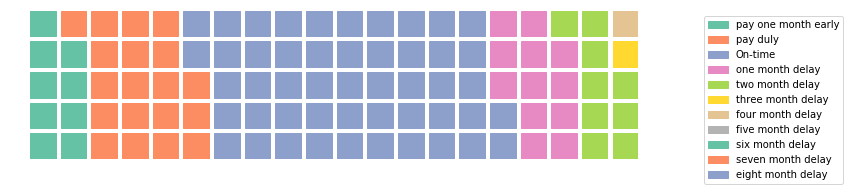

In [205]:
data = {'pay one month early':2759 ,'pay duly': 5686, 'On-time': 14737, 'one month delay': 3680,'two month delay':2667,
       'three month delay':322,'four month delay':76,'five month delay':26,'six month delay':11,'seven month delay': 9, 'eight month delay':19

       }
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

2. Is there any **Visual impact** on the payment status for last month for **defaulters** and **non-defaulters**?

_Defaulters_:

In [206]:
frequency_df_sep_tbl = pd.crosstab(defaulters['PAY_0'], 'frequency').reset_index()

In [207]:
frequency_df_sep_tbl

col_0,PAY_0,frequency
0,-2,365
1,-1,954
2,0,1888
3,1,1252
4,2,1844
5,3,244
6,4,52
7,5,13
8,6,6
9,7,7


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


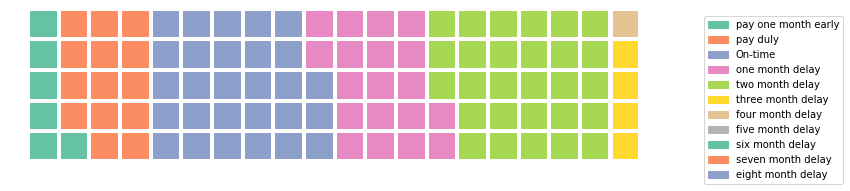

In [208]:
data = {'pay one month early':365 ,'pay duly': 954, 'On-time': 1888, 'one month delay': 1252,'two month delay':1844,
       'three month delay':244,'four month delay':52,'five month delay':13,'six month delay':6,'seven month delay': 7, 'eight month delay':11

       }
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

_Non-Defaulters_:

In [209]:
frequency_nondf_sep_tbl = pd.crosstab(non_defaulters['PAY_0'], 'frequency').reset_index()

In [210]:
frequency_nondf_sep_tbl

col_0,PAY_0,frequency
0,-2,2394
1,-1,4732
2,0,12849
3,1,2436
4,2,823
5,3,78
6,4,24
7,5,13
8,6,5
9,7,2


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


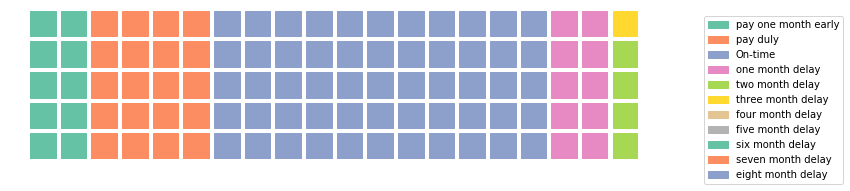

In [211]:
data = {'pay one month early':2394 ,'pay duly': 4732, 'On-time': 12849, 'one month delay': 2436,'two month delay':823,
       'three month delay':78,'four month delay':24,'five month delay':13,'six month delay':5,'seven month delay': 2, 'eight month delay':8

       }
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

**Insight**: The waffle graph indicate a sharp delay in payments for defaulters (mostly two month delay) whereas, the on-time payment ratio fairly less than the non defaulters. This indicates the defaulters usually delay payments and hence it can use to predict the fraud.  

3. What is the **amount of bill for last month** in comparison to the **payment delays in last month** in complete dataset? 

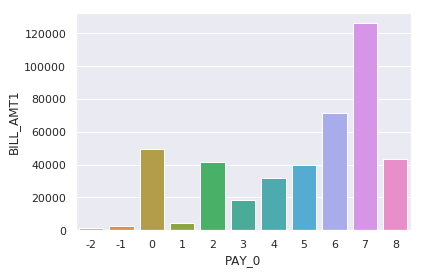

In [212]:
sns.set(font_scale=1)
sns.barplot(x='PAY_0', y='BILL_AMT1',data=dt, ci=None, estimator=np.median)

i. Is there any visual difference for **defaulters** and **non-defaulters**?

_Defaulters_:

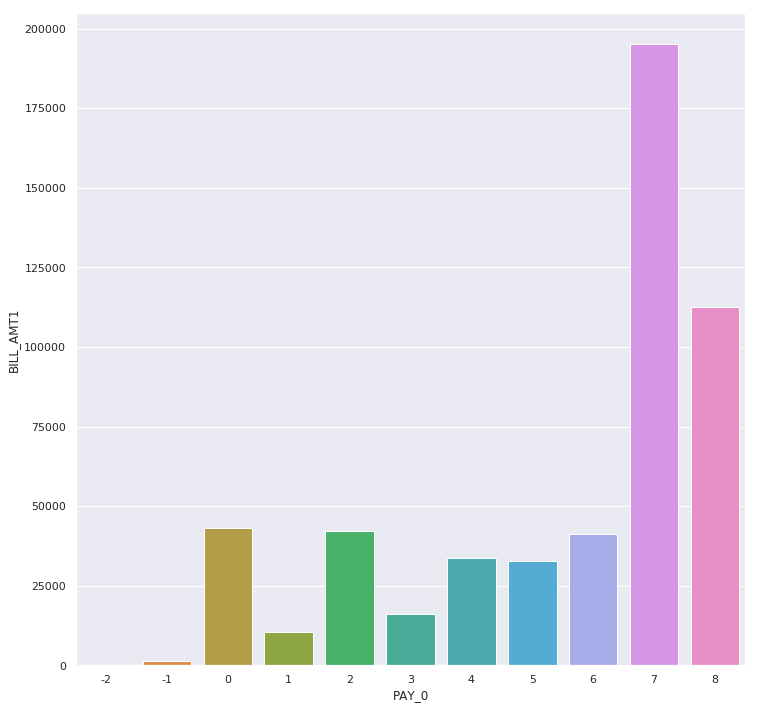

In [213]:
plt.figure(figsize=(12,12))
sns.set_style('darkgrid')
sns.barplot(x='PAY_0', y='BILL_AMT1',data=defaulters, ci=None,estimator=np.median)

_Non-Defaulters_:

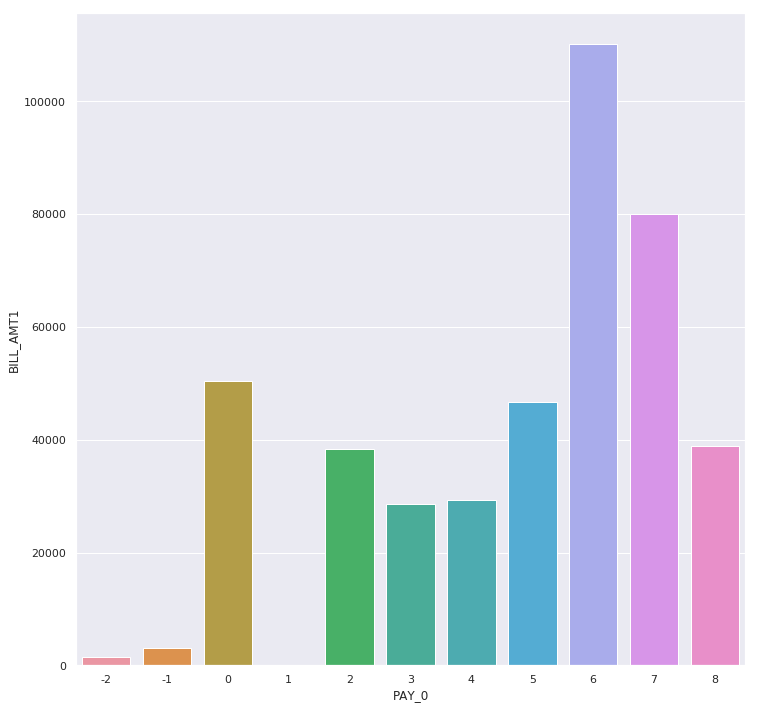

In [214]:
plt.figure(figsize=(12,12))
sns.set_style('darkgrid')
sns.barplot(x='PAY_0', y='BILL_AMT1',data=non_defaulters, ci=None,estimator=np.median)

**Insight**: From the above bar plot is can be observe that the those who have intention of fraud often have huge amount of bill for last month whereas, the case is totally opposite in the non defaulters data. 

4. What is the relationship between **Amount of bill** and **Payment history** for complete dataset?

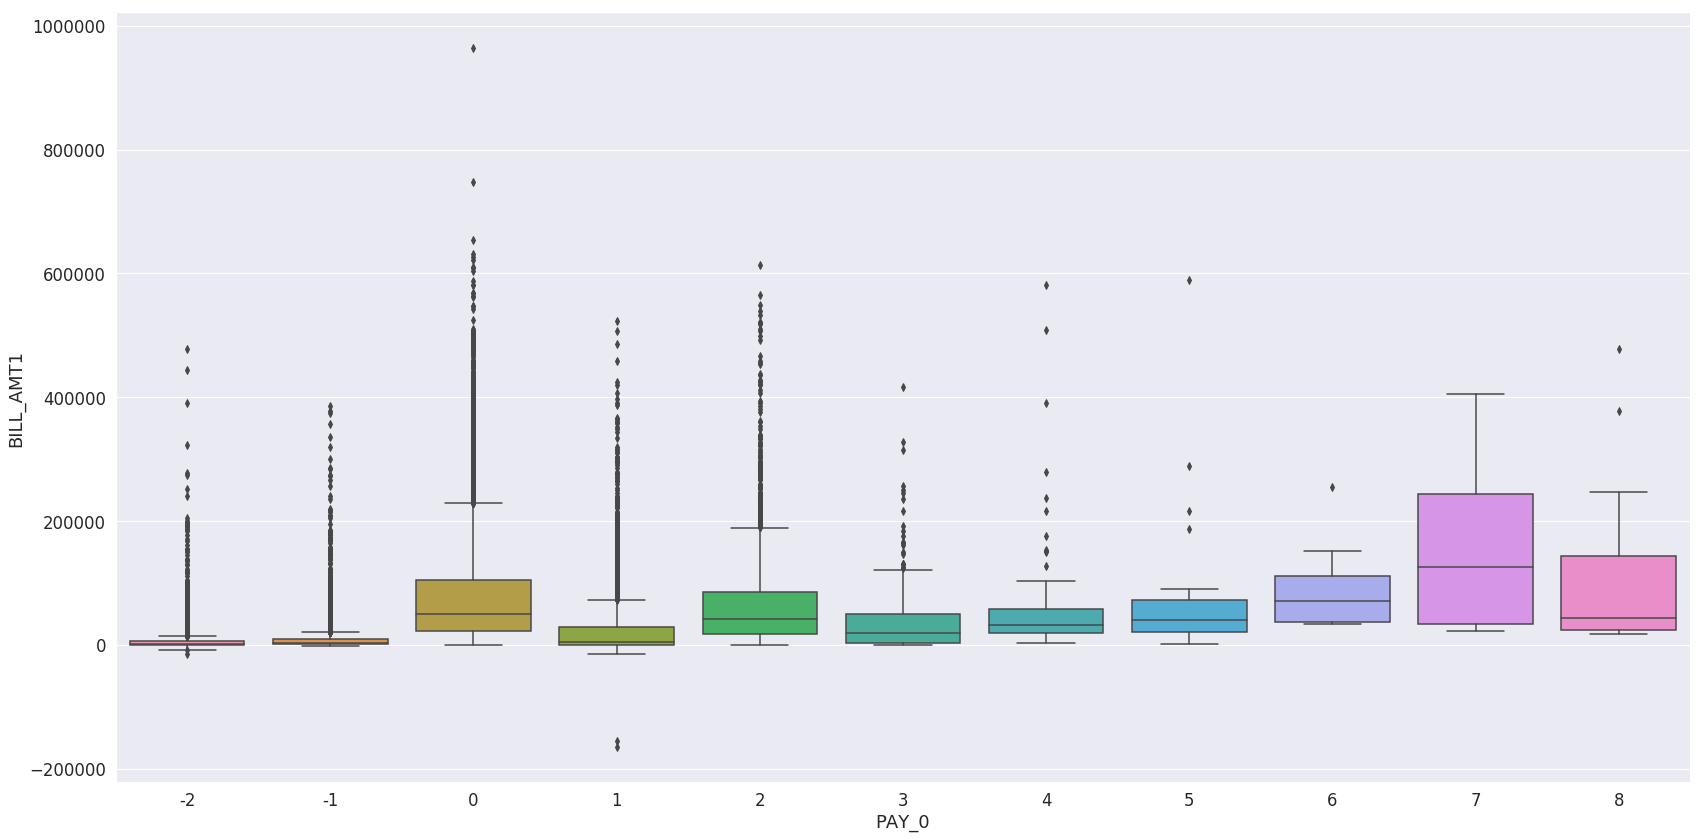

In [215]:
sns.set(font_scale=1.5)
sns.catplot(x='PAY_0', y='BILL_AMT1', data=dt, kind="box", height=12, aspect=2)

5. Is there any difference between the **Amount of bill distribution** for **Defaulters** and **Non-Defaulters**?

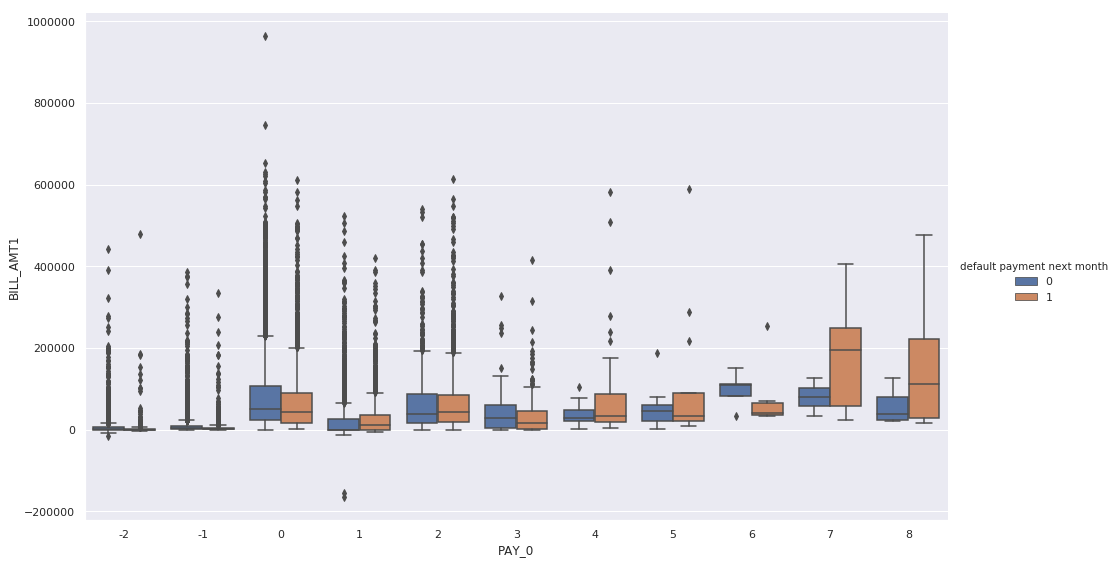

In [216]:
sns.set(font_scale=1)
sns.catplot(x='PAY_0', y='BILL_AMT1',hue='default payment next month', data=dt, kind="box", height=8, aspect=1.7)

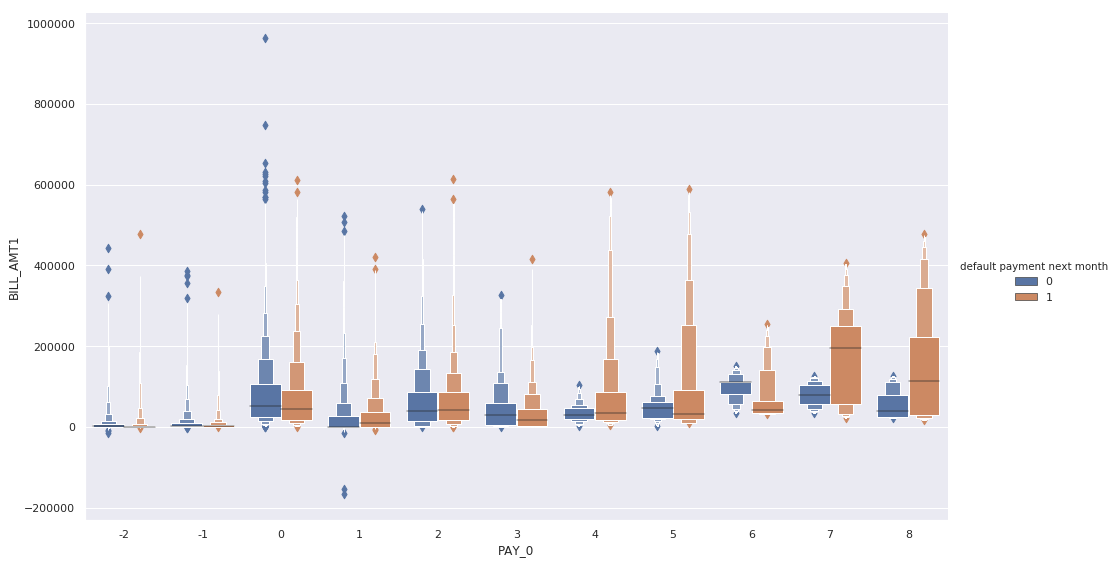

In [217]:
sns.set(font_scale=1)
sns.catplot(x='PAY_0', y='BILL_AMT1',hue='default payment next month', data=dt, kind="boxen", height=8, aspect=1.7)

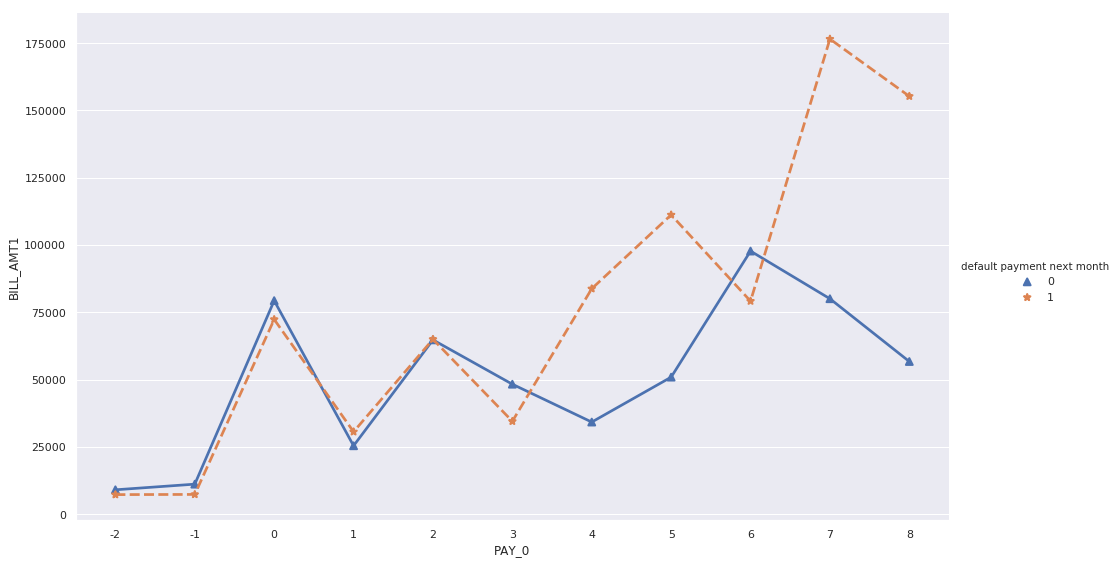

In [218]:
sns.set(font_scale=1)
sns.catplot(x='PAY_0', y='BILL_AMT1',hue='default payment next month', data=dt, kind="point", 
            markers=['^','*'],  linestyles=["-", "--"],ci=False,
            height=8, aspect=1.7)

**Insight**: There is serious fluctuation in the amount of bill for defaulters and non-defaulters as it can be seen in the above plots. It is thereby, this features (amount of bill for last month) can be of significant importance.

5. How the **Paid amount** for last month is distributed ?

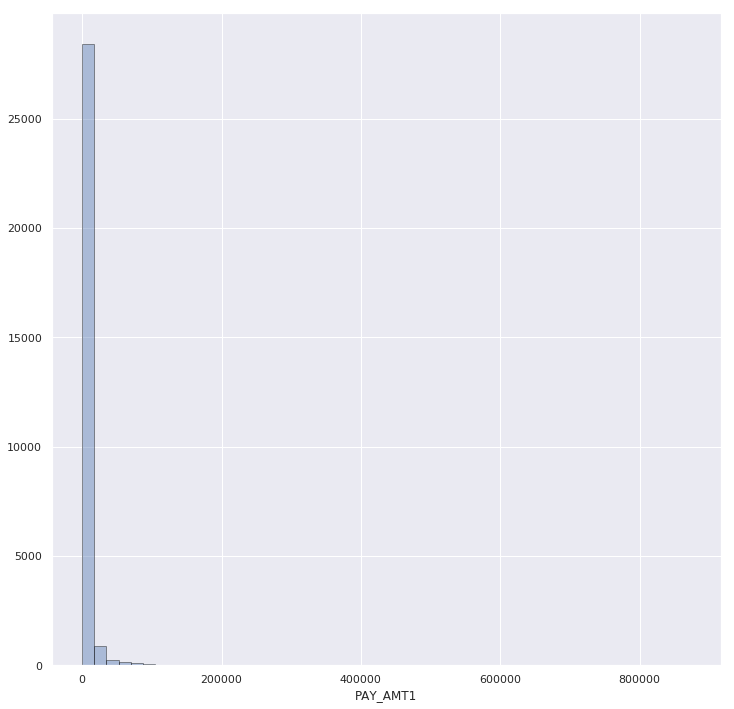

In [219]:
plt.figure(figsize=(12,12))
sns.distplot(dt['PAY_AMT1'], hist=True,kde=False,hist_kws={'edgecolor':'black'})

5. (i) How the distribution is different for both classes of target variable?

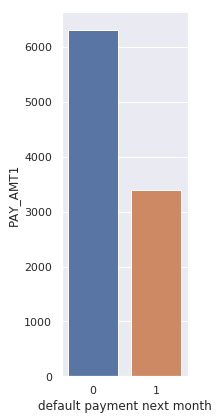

In [220]:
sns.catplot(y='PAY_AMT1', x='default payment next month', data=dt, kind='bar',height=6,aspect=0.5,ci=False)

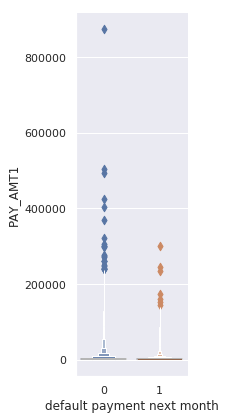

In [221]:
sns.catplot(y='PAY_AMT1', x='default payment next month', data=dt, kind='boxen',height=6,aspect=0.5,ci=False)

6. How many observation are there per payment status for last month ?

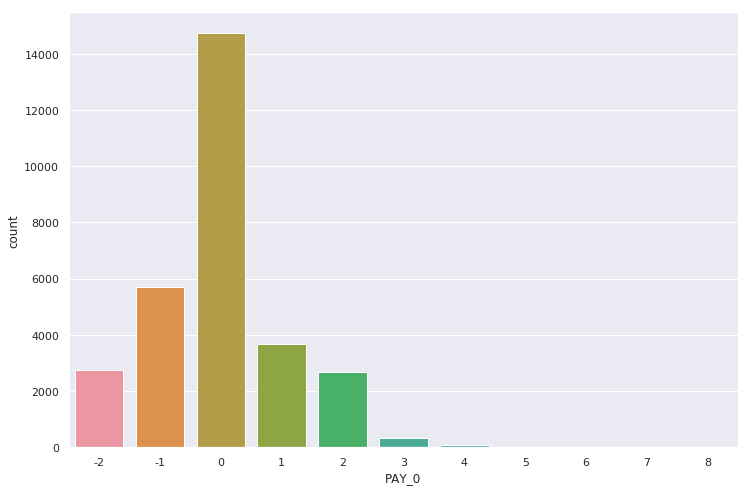

In [222]:
plt.figure(figsize=(12,8))
sns.countplot(x='PAY_0', data=dt)

6. (i) What is the ratio of the undocumented payment status?

In [223]:
dt['PAY_0'].value_counts(normalize=True).sort_values(ascending=False)

 0   0.49
-1   0.19
 1   0.12
-2   0.09
 2   0.09
 3   0.01
 4   0.00
 5   0.00
 8   0.00
 6   0.00
 7   0.00
Name: PAY_0, dtype: float64

In [224]:
dt[(dt.PAY_0 != -1) & (dt.PAY_0 != -2)]['PAY_0'].value_counts()

0    14737
1     3688
2     2667
3      322
4       76
5       26
8       19
6       11
7        9
Name: PAY_0, dtype: int64

**Insight**: By removing NA's( -1 and -2) the accuracy jumped to 80% on test data. whereas, AUC is 67% ,recall is and precision is 

### &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; <font color='red'>PAY_2 | ATM_02 | PAY_ATM_02</font> 

6. What are the frequency of delays in **payment of second last month**?

In [225]:
crostbl = pd.crosstab(dt['PAY_2'],'frequency')
crostbl

col_0,frequency
PAY_2,
-2,3782
-1,6050
0,15730
1,28
2,3927
3,326
4,99
5,25
6,12


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


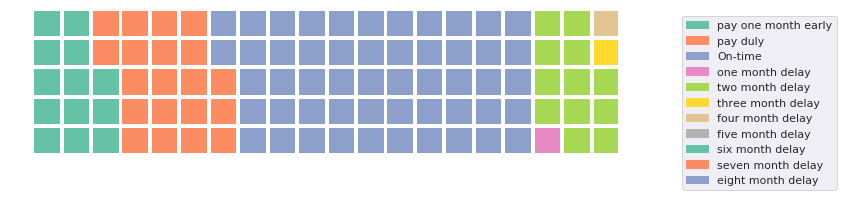

In [226]:
data = {'pay one month early':3782 ,'pay duly': 6050, 'On-time': 15730, 'one month delay': 28,'two month delay':3927,
       'three month delay':326,'four month delay':99,'five month delay':25,'six month delay':12,'seven month delay': 20, 'eight month delay':1

       }
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

In [227]:
crostbl = pd.crosstab(defaulters['PAY_2'],'frequency')
crostbl

col_0,frequency
PAY_2,
-2,691
-1,966
0,2503
1,5
2,2184
3,201
4,50
5,15
6,9


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


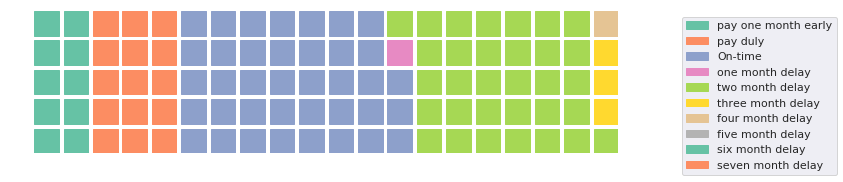

In [228]:
data = {'pay one month early':691 ,'pay duly': 966, 'On-time': 2503, 'one month delay': 5,'two month delay':2184,
       'three month delay':201,'four month delay':50,'five month delay':15,'six month delay':9,'seven month delay': 12
       }
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

In [229]:
crostbl = pd.crosstab(non_defaulters['PAY_2'],'frequency')
crostbl

col_0,frequency
PAY_2,
-2,3091
-1,5084
0,13227
1,23
2,1743
3,125
4,49
5,10
6,3


/home/codex/.local/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


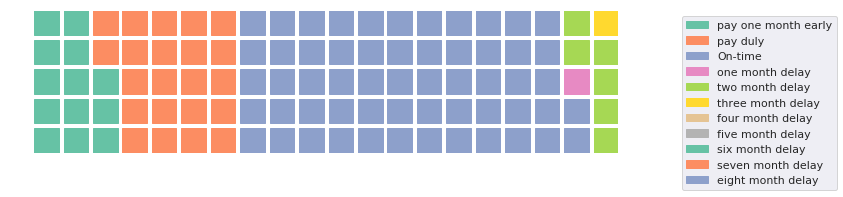

In [230]:
data = {'pay one month early':3091 ,'pay duly': 5084, 'On-time': 13227, 'one month delay': 23,'two month delay':1743,
       'three month delay':125,'four month delay':49,'five month delay':10,'six month delay':3,'seven month delay': 8,
        'eight month delay':1
       }
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5,
    columns=20, 
    values=data,
    figsize=(12,12),
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.1, 1)}
)
plt.show()

----

## Testing ##

----

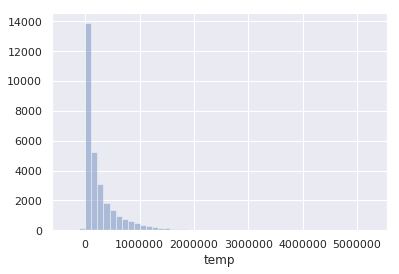

In [231]:
sns.distplot(dt['temp'],hist=True,kde=False)

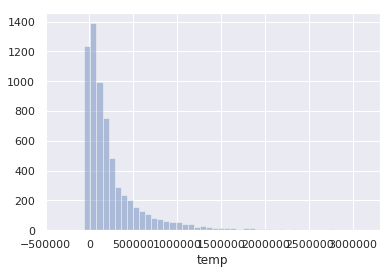

In [232]:
sns.distplot(defaulters['temp'],hist=True,kde=False)

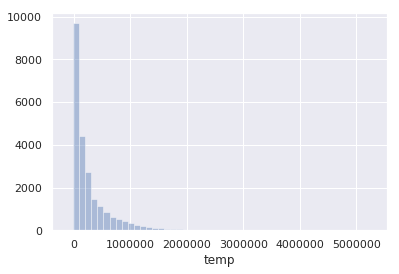

In [233]:
sns.distplot(non_defaulters['temp'],hist=True,kde=False)

-----------------------

-------------------

## 01 Clean the data and merge again 

In [63]:
def separate_data(dt):
    defaulters = dt[dt['default payment next month']==1]
    non_defaulters = dt[dt['default payment next month']==0]
    return defaulters,non_defaulters

In [64]:
def clean_payment_status(deafulters, non_defaulters,payment_status):
    for status in payment_status:
        key = 'updated_'+ status
        defaulters[key] = defaulters[status].apply(lambda x: x if x in [-1,1,2,3,4,5,6,7,8,9] else 2 )
        non_defaulters[key] = non_defaulters[status].apply(lambda x: x if x in [-1,1,2,3,4,5,6,7,8,9] else -1 )
    return deafulters,non_defaulters


In [65]:
defaulters,non_defaulters = separate_data(dt)

In [66]:
payment_status = ['PAY_0','PAY_2','PAY_3','PAY_5','PAY_4','PAY_6']
defaulters,non_defaulters = clean_payment_status(defaulters,non_defaulters, payment_status)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [67]:
dt = pd.concat([defaulters,non_defaulters])

In [68]:
dt.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'temp', 'updated_PAY_0', 'updated_PAY_2',
       'updated_PAY_3', 'updated_PAY_5', 'updated_PAY_4', 'updated_PAY_6'],
      dtype='object')

## 02 Single column for all payment status

In [69]:
first_month = dt[['ID','updated_PAY_0','default payment next month']]
second_month = dt[['ID','updated_PAY_2','default payment next month']]
third_month = dt[['ID','updated_PAY_3','default payment next month']]
fourth_month = dt[['ID','updated_PAY_4','default payment next month']]
fifth_month = dt[['ID','updated_PAY_5','default payment next month']]
sixth_month = dt[['ID','updated_PAY_6','default payment next month']]
second_month = second_month.rename(columns={'updated_PAY_2':'updated_PAY_0'})
third_month = third_month.rename(columns={'updated_PAY_3':'updated_PAY_0'})
fourth_month = fourth_month.rename(columns={'updated_PAY_4':'updated_PAY_0'})
fifth_month = fifth_month.rename(columns={'updated_PAY_5':'updated_PAY_0'})
sixth_month = sixth_month.rename(columns={'updated_PAY_6':'updated_PAY_0'})

In [70]:
complete_status = pd.concat([first_month,second_month,third_month,fourth_month,fifth_month,sixth_month])

In [71]:
fraud = complete_status[complete_status['default payment next month']==1]
normal =complete_status[complete_status['default payment next month']==0]

In [72]:
fraud['flag'] = np.where(fraud['updated_PAY_0']==2, 'Delay(2)',(np.where(fraud['updated_PAY_0'] > 2 , 'Delay(>2)', 'On-Time')))
normal['flag'] = np.where(normal['updated_PAY_0']==2, 'Delay(2)',np.where(normal['updated_PAY_0'] > 2 , 'Delay(>2)', 'On-Time'))

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [73]:
new_dt = pd.concat([fraud,normal])

In [74]:
new_dt.head(5)

,ID,updated_PAY_0,default payment next month,flag
0,1,2,1,Delay(2)
1,2,-1,1,On-Time
13,14,1,1,On-Time
16,17,2,1,Delay(2)
21,22,-1,1,On-Time


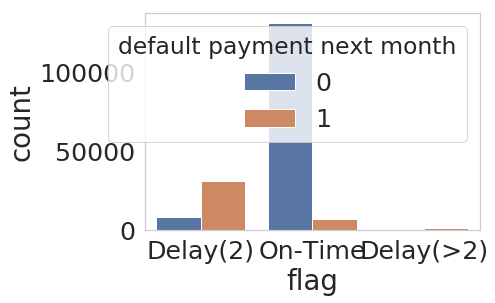

In [75]:
sns.countplot(new_dt['flag'],hue=new_dt['default payment next month'])

In [155]:
set_of_colour_df = ["darkturquoise", "paleturquoise", "darkcyan"]
set_of_colour_no_df = ["paleturquoise", "darkturquoise", "darkcyan"]

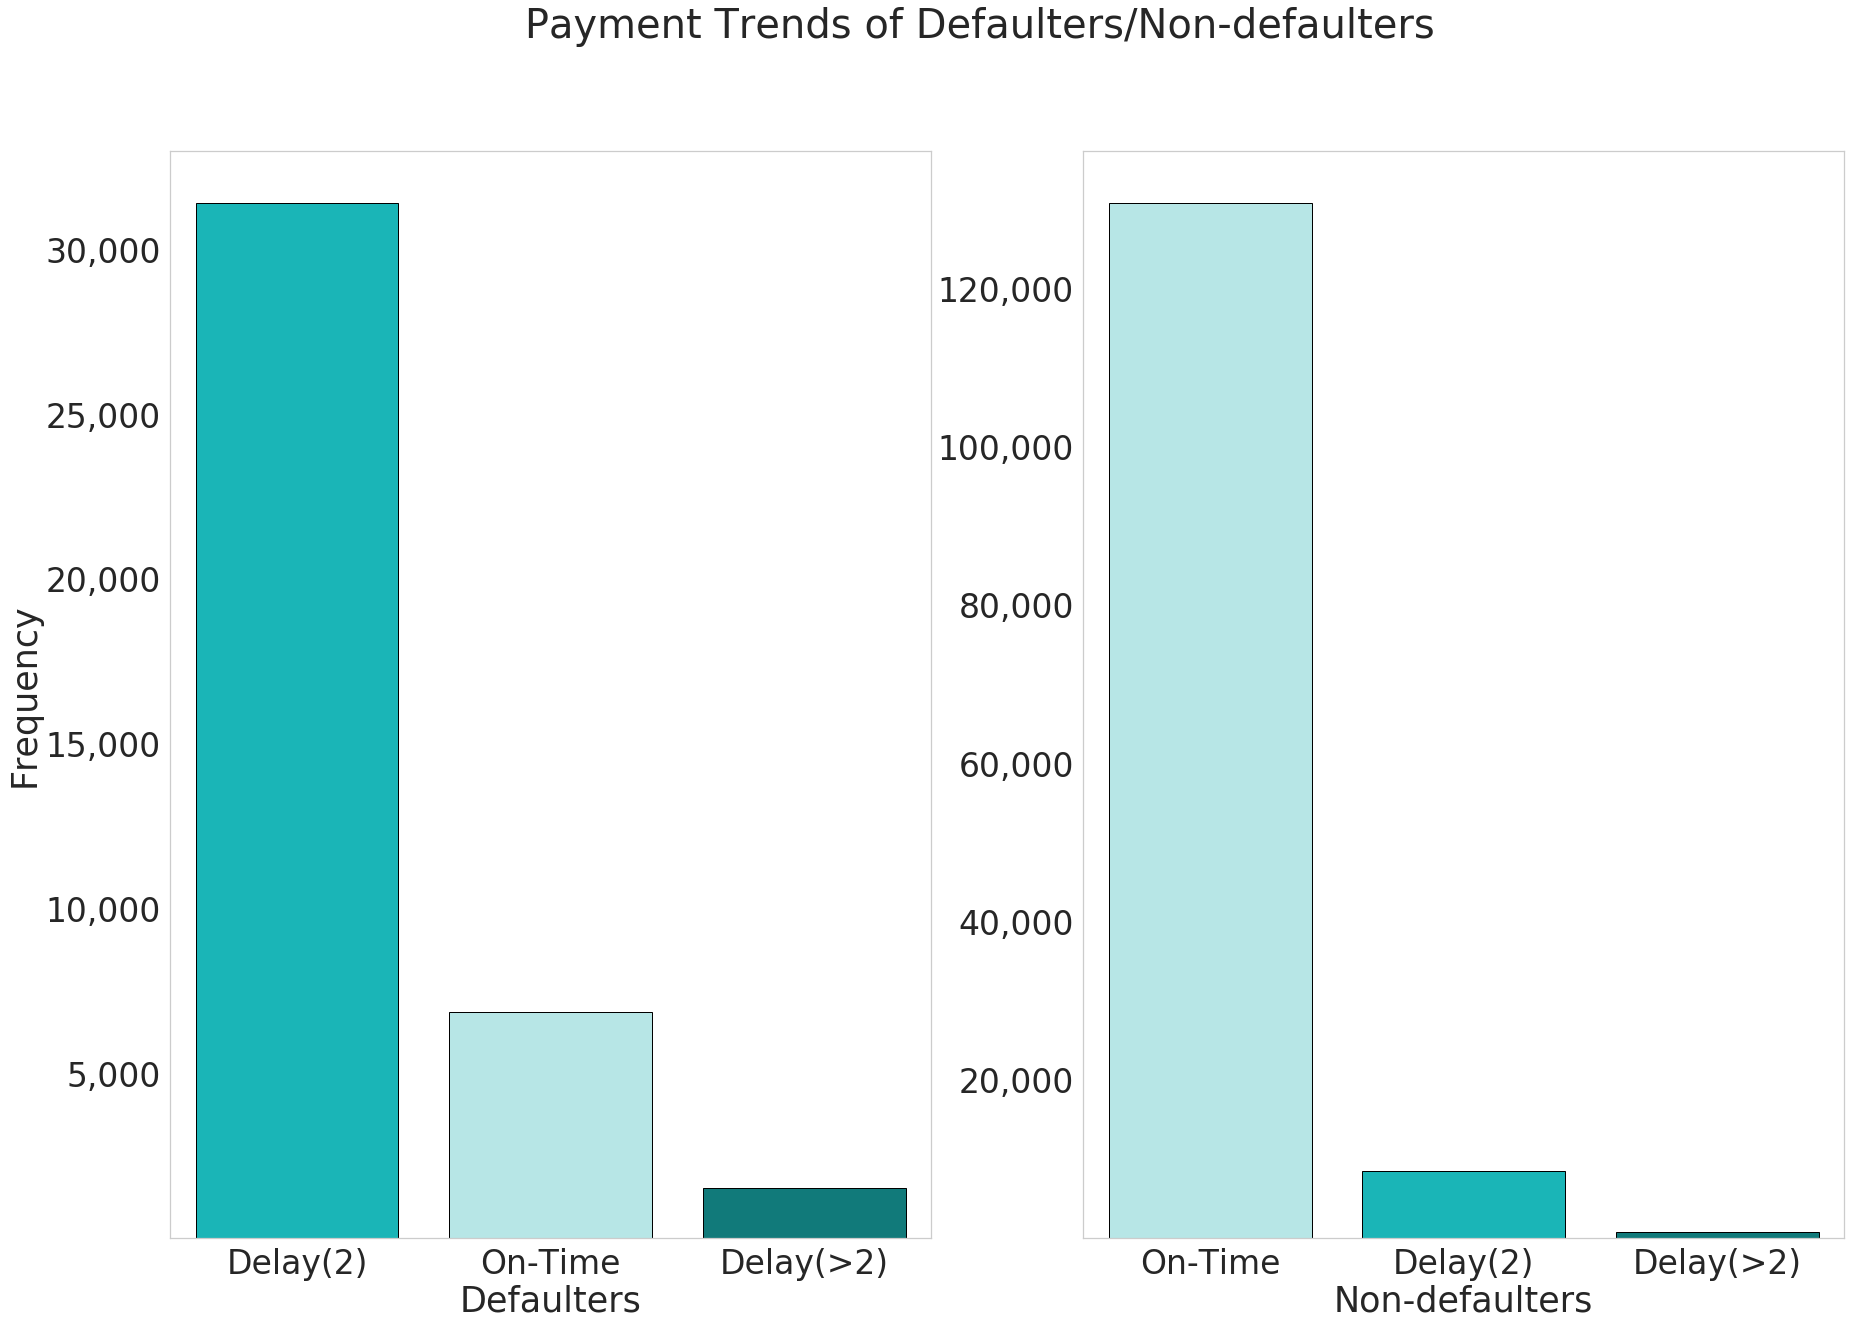

In [156]:
sns.set(font_scale=3)
sns.set_style("whitegrid", {'axes.grid' : False})

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(30,20))
fig.suptitle('Payment Trends of Defaulters/Non-defaulters',fontsize=40)
sns.countplot(fraud['flag'],ax=ax[0],edgecolor=(0,0,0),linewidth=1,orient='h',palette=set_of_colour_df)
ax[0].set_xlabel('Defaulters',fontsize=35)
ax[0].set_ylabel('Frequency',fontsize=35)
ax[0].set_yticklabels(['','5,000','10,000','15,000','20,000','25,000','30,000'])
sns.countplot(normal['flag'],ax=ax[1],edgecolor=(0,0,0),linewidth=1,palette=set_of_colour_no_df,orient='h')
ax[1].set_xlabel('Non-defaulters',fontsize=35)
ax[1].set_ylabel('',fontsize=30)
ax[1].set_yticklabels(['','20,000','40,000','60,000','80,000','100,000','120,000'])
fig.savefig('/home/sehan/Desktop/Playing_area/Fraud_detection/static/img/home/Vis1.png',transparent=True)

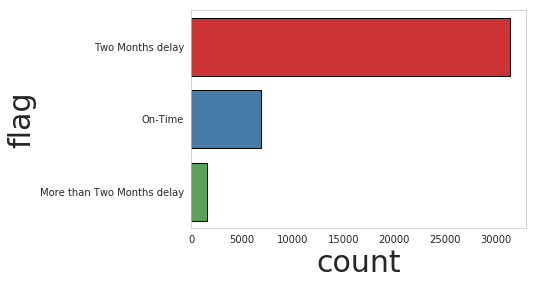

In [32]:
sns.countplot(y=fraud['flag'],edgecolor=(0,0,0),linewidth=1,palette="Set1")

--------------

In [7]:
dt.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'temp'],
      dtype='object')

In [26]:
dt['payment for last three months']= dt['PAY_AMT1']+ dt['PAY_AMT2']+ dt['PAY_AMT3']
dt['bill for last three months']= dt['BILL_AMT1']+ dt['BILL_AMT2']+ dt['BILL_AMT3']

In [20]:
fraud = dt[dt['default payment next month']==1]
normal = dt[dt['default payment next month']==0] 

In [27]:
summary = dt.groupby(by=['default payment next month'])['payment for last three months','bill for last three months'].mean().reset_index()

In [29]:
summary

,default payment next month,payment for last three months,bill for last three months
0,0,18701.299264,149245.028548
1,1,10153.045359,140974.378993


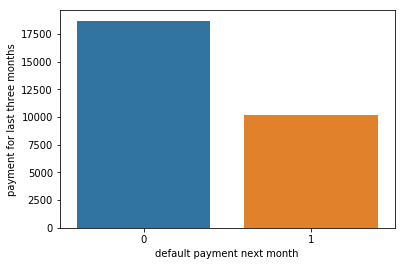

In [25]:
sns.barplot(x='default payment next month', y ='payment for last three months', data=summary )

-----------------

In [199]:
dt['payment for last three months']= dt['PAY_AMT1']+ dt['PAY_AMT2']+ dt['PAY_AMT3']

In [202]:
summary_dt = dt.groupby(by=['default payment next month'])['payment for last three months'].sum().reset_index()

[436937156, 67375609]

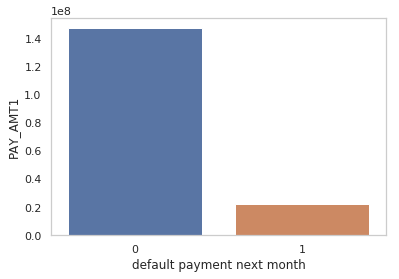

In [177]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.(x='default payment next month',y='PAY_AMT1',data=dt,estimator=np.sum,ci=False)

In [237]:
# Data to plot
labels = 'Non-defaulters', 'Defaulters'
sizes = summary_dt['payment for last three months'].tolist()
colors = ['paleturquoise', 'darkturquoise']
explode = (0, 0.1)  # explode 1st slice

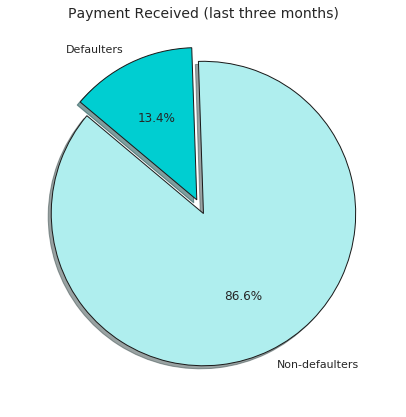

In [238]:
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=140,wedgeprops={'edgecolor':'k'})
plt.title('Payment Received (last three months)',fontsize=14)
plt.savefig('/home/sehan/Desktop/Playing_area/Fraud_detection/static/img/home/Vis2.png',transparent=True)

In [191]:
147364630+22542785

169907415

-----------------

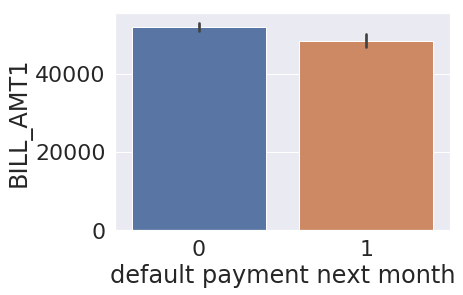

In [367]:
dt['bill for last three months']= dt['BILL_AMT1']+ dt['BILL_AMT2']+ dt['BILL_AMT3']
sns.barplot(y='BILL_AMT1', x='default payment next month',data=dt, estimator=np.mean)

In [368]:
dt.groupby(by=['default payment next month'])['BILL_AMT1'].median()

default payment next month
0    23119.5
1    20185.0
Name: BILL_AMT1, dtype: float64

In [369]:
dt.groupby(by=['default payment next month'])['bill for last three months'].sum()

default payment next month
0    3486960847
1     935505979
Name: bill for last three months, dtype: int64

In [370]:
dt.groupby(by=['default payment next month'])['LIMIT_BAL'].mean()

default payment next month
0    178099.726074
1    130109.656420
Name: LIMIT_BAL, dtype: float64

In [371]:
dt.groupby(by=['default payment next month','SEX'])['LIMIT_BAL'].mean()

default payment next month  SEX
0                           1      175510.371603
                            2      179726.531466
1                           1      125895.468152
                            2      133327.132607
Name: LIMIT_BAL, dtype: float64

In [372]:
dt['OUTSTANDING_PAYMENT_01'] = dt['BILL_AMT1'] - dt['PAY_AMT1']
dt['OUTSTANDING_PAYMENT_02'] = dt['BILL_AMT2'] - dt['PAY_AMT2']
dt['OUTSTANDING_PAYMENT_03'] = dt['BILL_AMT3'] - dt['PAY_AMT3']
dt['OUTSTANDING_PAYMENT_04'] = dt['BILL_AMT4'] - dt['PAY_AMT4']
dt['OUTSTANDING_PAYMENT_05'] = dt['BILL_AMT5'] - dt['PAY_AMT5']

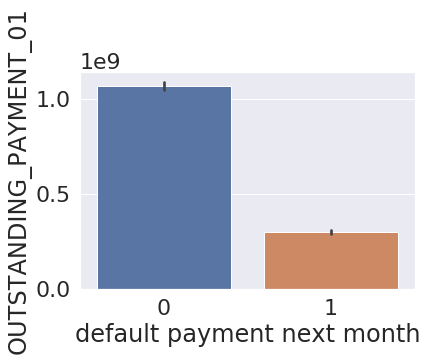

In [373]:
sns.barplot(x='default payment next month',y='OUTSTANDING_PAYMENT_01', estimator=sum, data=dt)

In [374]:
dt.groupby(by=['default payment next month'])['OUTSTANDING_PAYMENT_01'].median()

default payment next month
0    18623
1    18319
Name: OUTSTANDING_PAYMENT_01, dtype: int64

In [375]:
dt['Last_three_mom_outstanding'] = dt['OUTSTANDING_PAYMENT_01'] + dt['OUTSTANDING_PAYMENT_02'] + dt['OUTSTANDING_PAYMENT_03']+ dt['OUTSTANDING_PAYMENT_04']+ dt['OUTSTANDING_PAYMENT_05']

In [376]:
dt.groupby(by=['default payment next month'])['Last_three_mom_outstanding'].sum()

default payment next month
0    4769447295
1    1367173329
Name: Last_three_mom_outstanding, dtype: int64

In [377]:
dt.groupby(by=['default payment next month','SEX'])['Last_three_mom_outstanding'].sum()

default payment next month  SEX
0                           1      1944301839
                            2      2825145456
1                           1       613536186
                            2       753637143
Name: Last_three_mom_outstanding, dtype: int64

In [378]:
dt['Total_bills'] = dt['BILL_AMT1'] + dt['BILL_AMT2']+ dt['BILL_AMT3'] + dt['BILL_AMT4'] + dt['BILL_AMT5']+ dt['BILL_AMT6']
dt['Total_payments'] = dt['PAY_AMT1']+ dt['PAY_AMT2'] + dt['PAY_AMT3'] + dt['PAY_AMT4'] + dt['PAY_AMT5'] + dt['PAY_AMT6']

In [379]:
dt['Total_Outstanding'] = dt['Total_bills'] - dt['Total_payments']

In [380]:
dt[['Total_bills','Total_payments','Total_Outstanding','default payment next month']]

,Total_bills,Total_payments,Total_Outstanding,default payment next month
0,7704,689,7015,1
1,17077,5000,12077,1
2,101653,11018,90635,0
3,231334,8388,222946,0
4,109339,59049,50290,0
5,238114,7772,230342,0
6,2724595,180759,2543836,0
7,13486,4791,8695,0
8,65212,6761,58451,0
9,26919,14129,12790,0


In [381]:
summary = dt.groupby(by=['default payment next month'])['Total_Outstanding'].median().reset_index()
summary

,default payment next month,Total_Outstanding
0,0,99511
1,1,107912


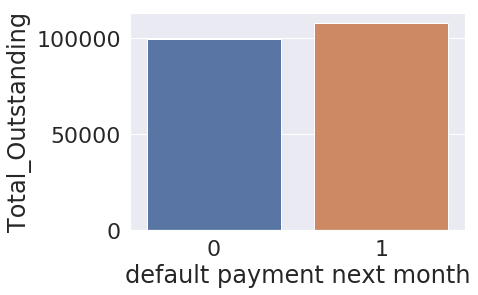

In [382]:
sns.barplot(x='default payment next month',y='Total_Outstanding',data=summary)

In [385]:
dt = dt[dt['Total_bills']!=0]
dt = dt[dt['Total_payments']!=0]

In [386]:
fraud = dt[dt['default payment next month']==1]
normal = dt[dt['default payment next month']==0]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,bill for last three months,OUTSTANDING_PAYMENT_01,OUTSTANDING_PAYMENT_02,OUTSTANDING_PAYMENT_03,OUTSTANDING_PAYMENT_04,OUTSTANDING_PAYMENT_05,Last_three_mom_outstanding,Total_bills,Total_payments,Total_Outstanding
26,27,60000,1,1,2,27,1,-2,-1,-1,...,-275,-109,-1425,259,-557,127,-1705,-394,2500,-2894
290,291,280000,1,1,2,33,-1,-1,-1,-1,...,2121,0,573,-573,573,325,898,-336259,347739,-683998
351,352,200000,1,1,1,36,1,-2,-1,-1,...,-24497,-24504,-60558,3432,-7684,-100000,-189314,-26795,171133,-197928
1034,1035,60000,2,2,3,39,1,-2,-2,-2,...,-5790,-1540,-1930,-4320,-3220,0,-11010,-7010,4000,-11010
1040,1041,20000,1,2,2,26,-1,-1,-2,-2,...,-1170,70,-620,-620,-2800,0,-3970,-2570,1400,-3970
2208,2209,80000,1,1,1,45,1,-2,-1,-1,...,-320,-50,-1440,170,-1220,390,-2150,-150,2780,-2930
3052,3053,280000,1,1,1,44,1,-2,-2,-2,...,-1488,-496,-856,-1216,-1533,-7828,-11929,-14,7657,-7671
3205,3206,200000,1,1,2,34,1,-2,-1,0,...,-2349,-1730,-4730,1111,1111,-29,-4267,-5056,3000,-8056
3428,3429,150000,2,1,2,42,1,-2,-2,-2,...,-2622,-874,-874,-874,-874,-5874,-9370,-244,5000,-5244
3525,3526,140000,1,1,2,28,0,-1,-1,0,...,13035,-1106,-1167,3464,2980,1482,5653,-32158,103270,-135428


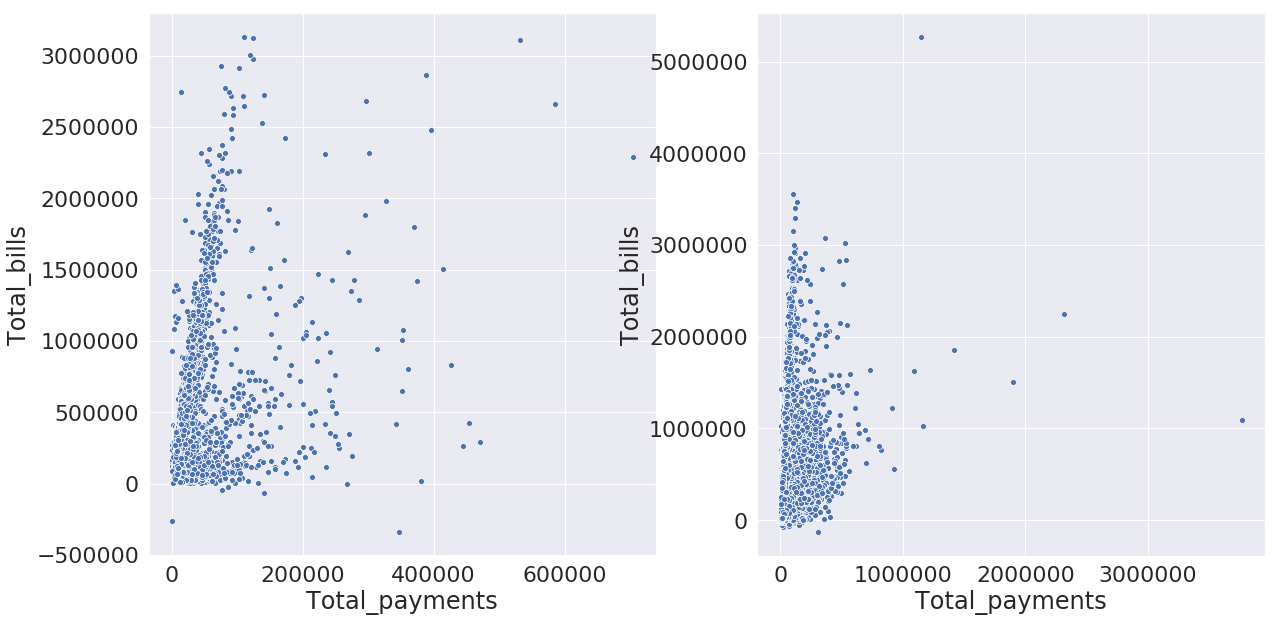

In [387]:
sns.set(font_scale=2)
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
sns.scatterplot(y='Total_bills',x='Total_payments',data=fraud,legend='brief',ax=ax[0])
sns.scatterplot(y='Total_bills',x='Total_payments',data=normal,legend='brief',ax=ax[1])

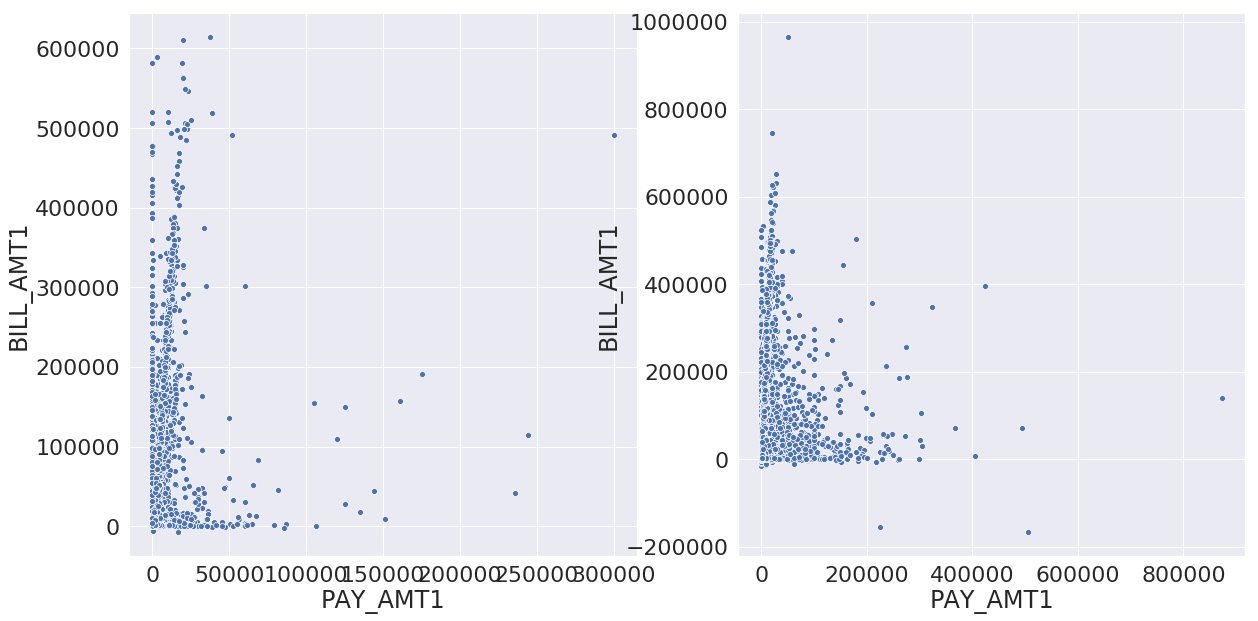

In [392]:
sns.set(font_scale=2)
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
sns.scatterplot(y='BILL_AMT1',x='PAY_AMT1',data=fraud,legend='brief',ax=ax[0])
sns.scatterplot(y='BILL_AMT1',x='PAY_AMT1',data=normal,legend='brief',ax=ax[1])

In [391]:
dt.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'temp', 'bill for last three months',
       'OUTSTANDING_PAYMENT_01', 'OUTSTANDING_PAYMENT_02',
       'OUTSTANDING_PAYMENT_03', 'OUTSTANDING_PAYMENT_04',
       'OUTSTANDING_PAYMENT_05', 'Last_three_mom_outstanding', 'Total_bills',
       'Total_payments', 'Total_Outstanding'],
      dtype='object')

In [388]:
fraud = dt[dt['default payment next month']==1]

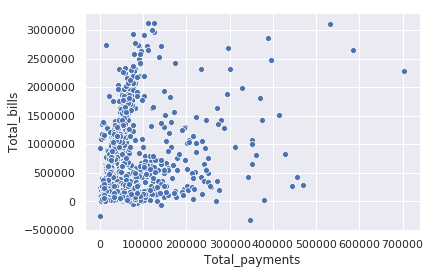

In [389]:
sns.set(font_scale=1)
sns.scatterplot(y='Total_bills',x='Total_payments',data=fraud,legend='brief')

In [394]:
summary = dt.groupby(by=['default payment next month'])['BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'].mean()
summary

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6
default payment next month,,,,,,
0,53866.153307,51776.941434,49509.011508,45428.242696,42218.884473,40674.236273
1,52565.507244,51446.447975,49190.670069,45760.824498,43036.975305,41654.868785


In [ ]:
sns.barplot(x='default payment next month', y='')

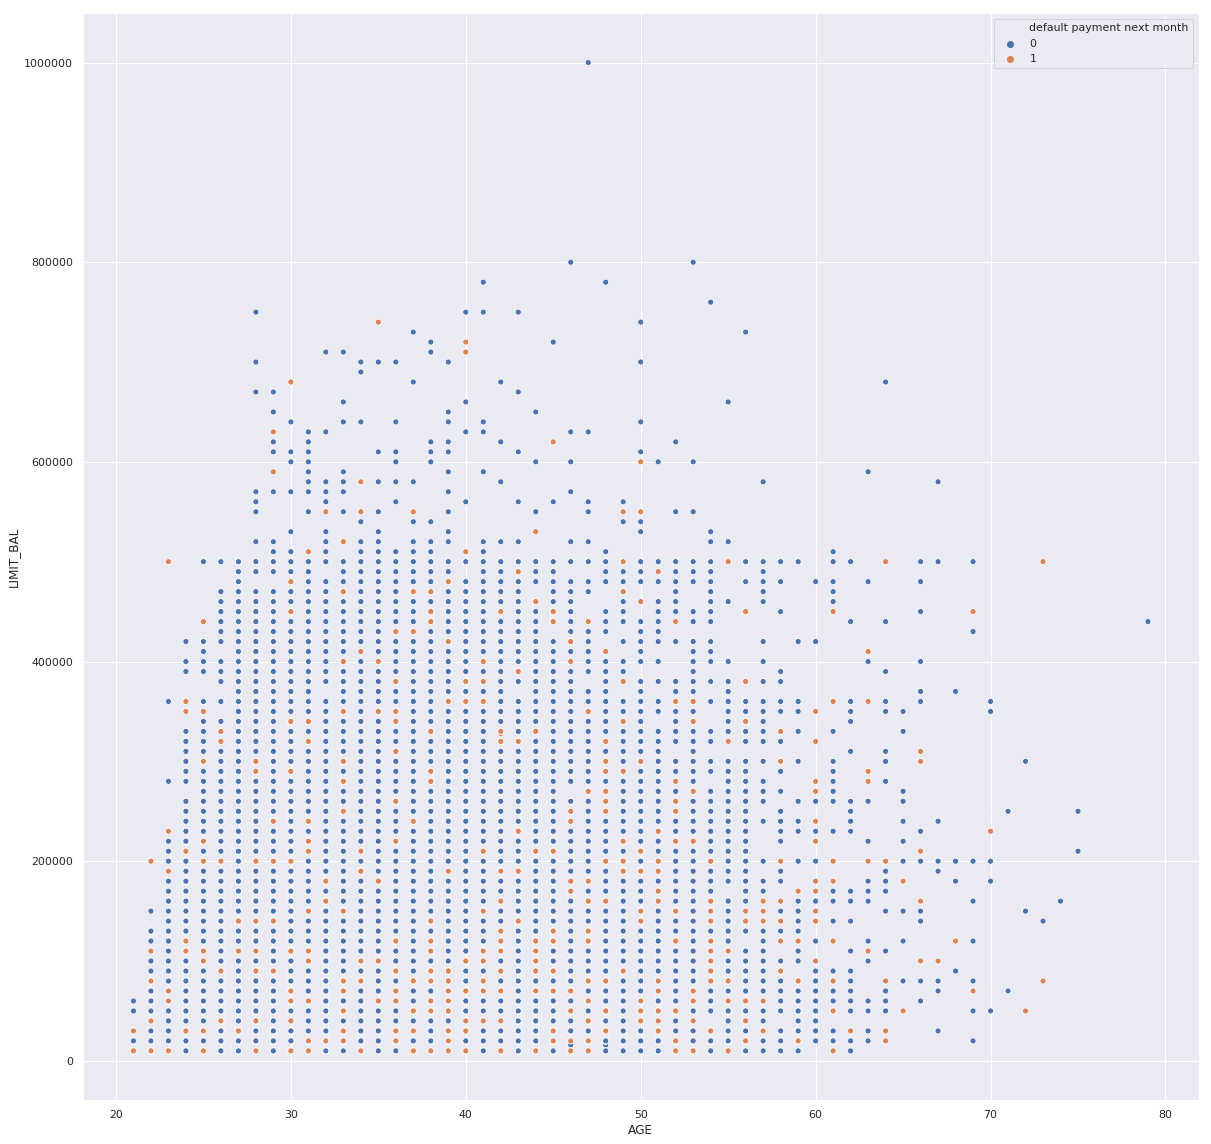

In [411]:
sns.set(font_scale=1)
plt.figure(figsize=(20,20))
sns.scatterplot(x='AGE',y='LIMIT_BAL',hue='default payment next month',data=dt)

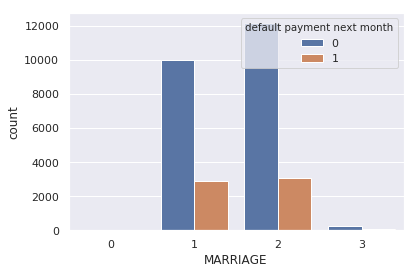

In [424]:
sns.countplot(dt[''],hue=dt['default payment next month'])

In [426]:
dt['AGE_BUCKET'] = np.where(dt['AGE'] < 31,'21-30',
                            np.where(dt['AGE']< 41, '31-40',
                                    np.where(dt['AGE']< 51,'41-50',
                                            np.where(dt['AGE']< 61,'51-60','60+'))))

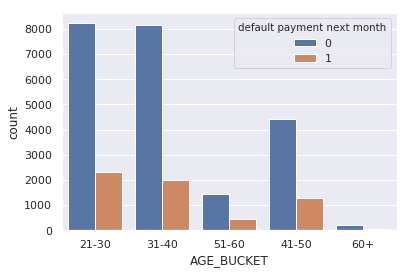

In [429]:
sns.countplot(dt['AGE_BUCKET'],hue=dt['default payment next month'])

In [432]:
single = dt[dt['MARRIAGE']==2]
married = dt[dt['MARRIAGE']==1]

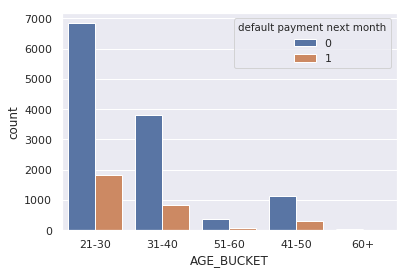

In [431]:
sns.countplot(single['AGE_BUCKET'],hue=single['default payment next month'])

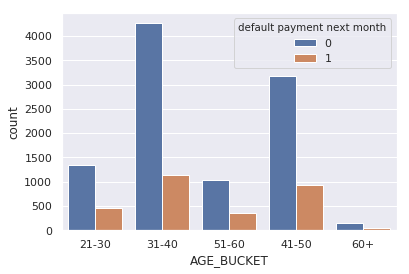

In [433]:
sns.countplot(married['AGE_BUCKET'],hue=married['default payment next month'])

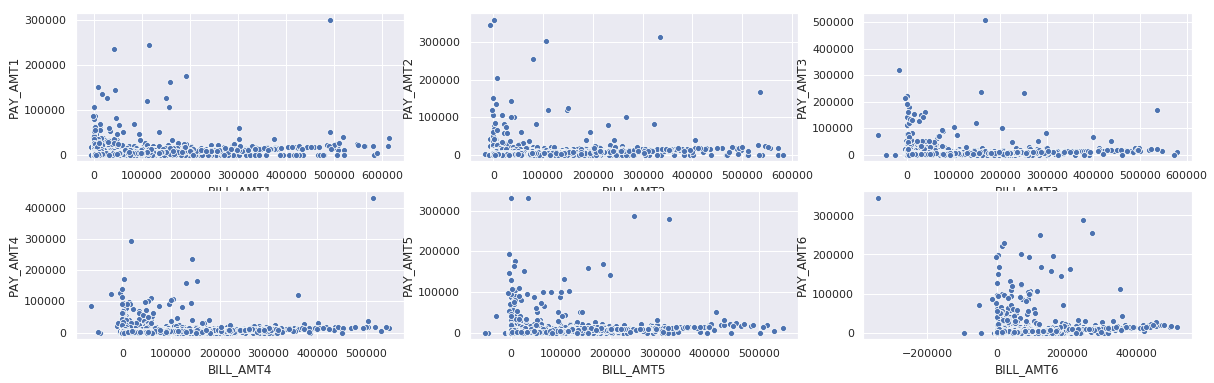

In [449]:
fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(20,6))
sns.scatterplot(x='BILL_AMT1',y='PAY_AMT1',data=fraud, ax=ax[0,0])
sns.scatterplot(x='BILL_AMT2',y='PAY_AMT2',data=fraud, ax=ax[0,1])
sns.scatterplot(x='BILL_AMT3',y='PAY_AMT3',data=fraud, ax=ax[0,2])
sns.scatterplot(x='BILL_AMT4',y='PAY_AMT4',data=fraud, ax=ax[1,0])
sns.scatterplot(x='BILL_AMT5',y='PAY_AMT5',data=fraud, ax=ax[1,1])
sns.scatterplot(x='BILL_AMT6',y='PAY_AMT6',data=fraud, ax=ax[1,2])

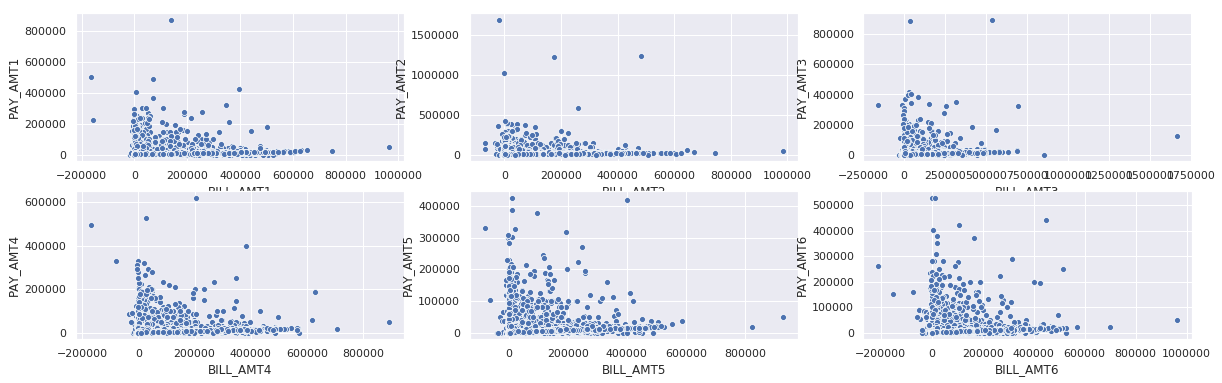

In [450]:
fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(20,6))
sns.scatterplot(x='BILL_AMT1',y='PAY_AMT1',data=normal, ax=ax[0,0])
sns.scatterplot(x='BILL_AMT2',y='PAY_AMT2',data=normal, ax=ax[0,1])
sns.scatterplot(x='BILL_AMT3',y='PAY_AMT3',data=normal, ax=ax[0,2])
sns.scatterplot(x='BILL_AMT4',y='PAY_AMT4',data=normal, ax=ax[1,0])
sns.scatterplot(x='BILL_AMT5',y='PAY_AMT5',data=normal, ax=ax[1,1])
sns.scatterplot(x='BILL_AMT6',y='PAY_AMT6',data=normal, ax=ax[1,2])

In [451]:
len(dt)

28493

In [489]:
dt['EDUCATION'] = np.where(dt['EDUCATION']==5,3,dt['EDUCATION'])
dt['EDUCATION'] = np.where(dt['EDUCATION']==6,3,dt['EDUCATION'])
np.unique(dt['EDUCATION'],return_counts=True)

(array([0, 1, 2, 3, 4]), array([   13,  9893, 13474,  4997,   116]))

In [490]:
melted_dt = dt[['EDUCATION','default payment next month','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]

In [491]:
melted_bills_dt = melted_dt.melt(id_vars=['EDUCATION','default payment next month'],var_name='Bills',value_name='Amount')
melted_bills_dt

,EDUCATION,default payment next month,Bills,Amount
0,2,1,BILL_AMT1,3913
1,2,1,BILL_AMT1,2682
2,2,0,BILL_AMT1,29239
3,2,0,BILL_AMT1,46990
4,2,0,BILL_AMT1,8617
5,1,0,BILL_AMT1,64400
6,1,0,BILL_AMT1,367965
7,2,0,BILL_AMT1,11876
8,3,0,BILL_AMT1,11285
9,3,0,BILL_AMT1,0


In [484]:
summary = melted_bills_dt.groupby(by=['default payment next month','EDUCATION','Bills'])['Amount'].sum().reset_index()
summary

,default payment next month,EDUCATION,Bills,Amount
0,0,0,BILL_AMT1,157291
1,0,0,BILL_AMT2,140794
2,0,0,BILL_AMT3,245300
3,0,0,BILL_AMT4,186903
4,0,0,BILL_AMT5,103727
5,0,0,BILL_AMT6,73821
6,0,1,BILL_AMT1,417915210
7,0,1,BILL_AMT2,404748317
8,0,1,BILL_AMT3,393619491
9,0,1,BILL_AMT4,368770455


In [492]:
graudates = summary[summary['EDUCATION']==1]
univeristy = summary[summary['EDUCATION']==2]
high_school = summary[summary['EDUCATION']==3]
others = summary[summary['EDUCATION']==4]

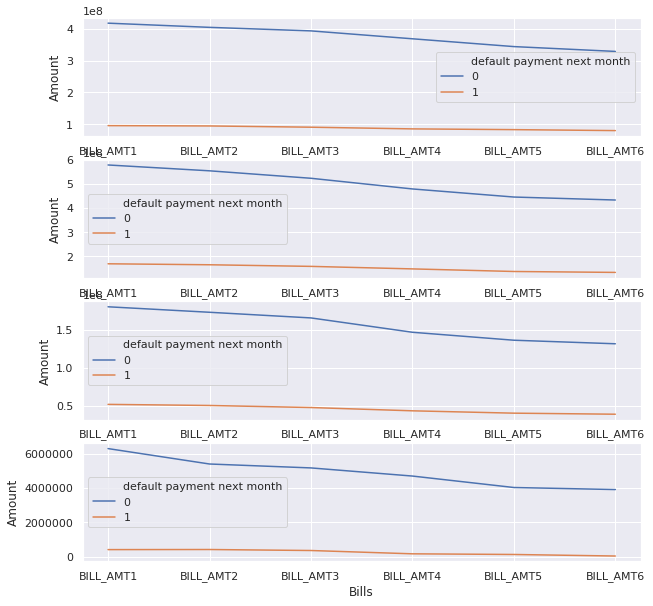

In [515]:
fig, ax = plt.subplots(ncols=1,nrows=4,figsize=(10,10))
sns.lineplot(x='Bills', y='Amount',hue='default payment next month',ci=False, data=graudates, ax=ax[0])
sns.lineplot(x='Bills', y='Amount',hue='default payment next month',ci=False, data=univeristy, ax=ax[1])
sns.lineplot(x='Bills', y='Amount',hue='default payment next month',ci=False, data=high_school, ax=ax[2])
sns.lineplot(x='Bills', y='Amount',hue='default payment next month',ci=False, data=others, ax=ax[3])

In [516]:
melted_dt = dt[['EDUCATION','default payment next month','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [517]:
melted_pay_dt = melted_dt.melt(id_vars=['EDUCATION','default payment next month'],var_name='payments',value_name='Amount')
melted_pay_dt

,EDUCATION,default payment next month,payments,Amount
0,2,1,PAY_AMT1,0
1,2,1,PAY_AMT1,0
2,2,0,PAY_AMT1,1518
3,2,0,PAY_AMT1,2000
4,2,0,PAY_AMT1,2000
5,1,0,PAY_AMT1,2500
6,1,0,PAY_AMT1,55000
7,2,0,PAY_AMT1,380
8,3,0,PAY_AMT1,3329
9,3,0,PAY_AMT1,0


In [520]:
summary = melted_pay_dt.groupby(by=['default payment next month','EDUCATION','payments'])['Amount'].sum().reset_index()
summary

,default payment next month,EDUCATION,payments,Amount
0,0,0,PAY_AMT1,83241
1,0,0,PAY_AMT2,182433
2,0,0,PAY_AMT3,123552
3,0,0,PAY_AMT4,50688
4,0,0,PAY_AMT5,35584
5,0,0,PAY_AMT6,42101
6,0,1,PAY_AMT1,64390712
7,0,1,PAY_AMT2,69561949
8,0,1,PAY_AMT3,61288368
9,0,1,PAY_AMT4,53707905


In [522]:
graudates = summary[summary['EDUCATION']==1]
univeristy = summary[summary['EDUCATION']==2]
high_school = summary[summary['EDUCATION']==3]
others = summary[summary['EDUCATION']==4]

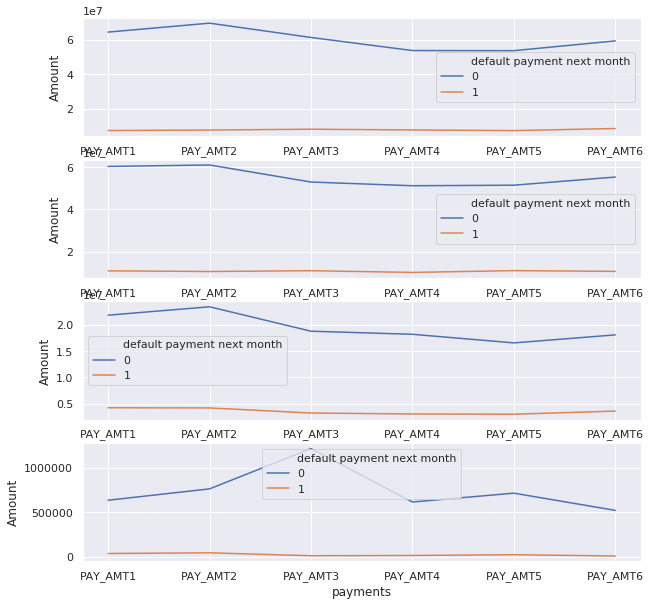

In [530]:
fig, ax = plt.subplots(ncols=1,nrows=4,figsize=(10,10))
sns.lineplot(x='payments', y='Amount',hue='default payment next month',ci=False, data=graudates, ax=ax[0])
sns.lineplot(x='payments', y='Amount',hue='default payment next month',ci=False, data=univeristy, ax=ax[1])
sns.lineplot(x='payments', y='Amount',hue='default payment next month',ci=False, data=high_school, ax=ax[2])
sns.lineplot(x='payments', y='Amount',hue='default payment next month',ci=False, data=others, ax=ax[3])

In [526]:
dt[dt['default payment next month']==1]['EDUCATION'].value_counts()

2    3117
1    1789
3    1161
4       7
Name: EDUCATION, dtype: int64

In [527]:
dt[dt['default payment next month']==0]['EDUCATION'].value_counts()

2    10357
1     8104
3     3836
4      109
0       13
Name: EDUCATION, dtype: int64

In [528]:
dt.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month', 'temp', 'bill for last three months',
       'OUTSTANDING_PAYMENT_01', 'OUTSTANDING_PAYMENT_02',
       'OUTSTANDING_PAYMENT_03', 'OUTSTANDING_PAYMENT_04',
       'OUTSTANDING_PAYMENT_05', 'Last_three_mom_outstanding', 'Total_bills',
       'Total_payments', 'Total_Outstanding', 'AGE_BUCKET'],
      dtype='object')

In [529]:
dt.MARRIAGE.value_counts()

2    15235
1    12895
3      314
0       49
Name: MARRIAGE, dtype: int64

In [532]:
melted_dt = dt[['SEX','default payment next month','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [533]:
melted_pay_dt = melted_dt.melt(id_vars=['SEX','default payment next month'],var_name='payments',value_name='Amount')
melted_pay_dt

,SEX,default payment next month,payments,Amount
0,2,1,PAY_AMT1,0
1,2,1,PAY_AMT1,0
2,2,0,PAY_AMT1,1518
3,2,0,PAY_AMT1,2000
4,1,0,PAY_AMT1,2000
5,1,0,PAY_AMT1,2500
6,1,0,PAY_AMT1,55000
7,2,0,PAY_AMT1,380
8,2,0,PAY_AMT1,3329
9,1,0,PAY_AMT1,0


In [534]:
summary = melted_pay_dt.groupby(by=['default payment next month','SEX','payments'])['Amount'].sum().reset_index()
summary

,default payment next month,SEX,payments,Amount
0,0,1,PAY_AMT1,57537122
1,0,1,PAY_AMT2,61112237
2,0,1,PAY_AMT3,53967601
3,0,1,PAY_AMT4,48445230
4,0,1,PAY_AMT5,48205285
5,0,1,PAY_AMT6,52389551
6,0,2,PAY_AMT1,89820808
7,0,2,PAY_AMT2,93928929
8,0,2,PAY_AMT3,80457099
9,0,2,PAY_AMT4,75384777


In [535]:
m = summary[summary['SEX']==1]
f = summary[summary['SEX']==2]


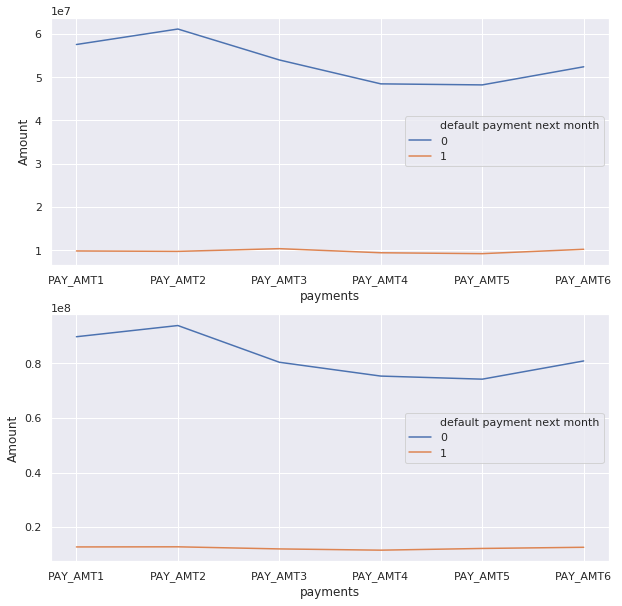

In [537]:
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(10,10))
sns.lineplot(x='payments', y='Amount',hue='default payment next month',ci=False, data=m, ax=ax[0])
sns.lineplot(x='payments', y='Amount',hue='default payment next month',ci=False, data=f, ax=ax[1])

In [557]:
melted_dt = dt[['MARRIAGE','default payment next month','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [558]:
melted_pay_dt = melted_dt.melt(id_vars=['MARRIAGE','default payment next month'],var_name='payments',value_name='Amount')
melted_pay_dt

,MARRIAGE,default payment next month,payments,Amount
0,1,1,PAY_AMT1,0
1,2,1,PAY_AMT1,0
2,2,0,PAY_AMT1,1518
3,1,0,PAY_AMT1,2000
4,1,0,PAY_AMT1,2000
5,2,0,PAY_AMT1,2500
6,2,0,PAY_AMT1,55000
7,2,0,PAY_AMT1,380
8,1,0,PAY_AMT1,3329
9,2,0,PAY_AMT1,0


In [559]:
summary = melted_pay_dt.groupby(by=['default payment next month','MARRIAGE','payments'])['Amount'].sum().reset_index()
summary

,default payment next month,MARRIAGE,payments,Amount
0,0,0,PAY_AMT1,411604
1,0,0,PAY_AMT2,146121
2,0,0,PAY_AMT3,212411
3,0,0,PAY_AMT4,150145
4,0,0,PAY_AMT5,106718
5,0,0,PAY_AMT6,115364
6,0,1,PAY_AMT1,67783347
7,0,1,PAY_AMT2,73210394
8,0,1,PAY_AMT3,61612359
9,0,1,PAY_AMT4,59402182


In [560]:
dt.MARRIAGE.value_counts()

2    15235
1    12895
3      314
0       49
Name: MARRIAGE, dtype: int64

In [561]:
m = summary[summary['MARRIAGE']==1]
s = summary[summary['MARRIAGE']==2]
o = summary[summary['MARRIAGE']==3]



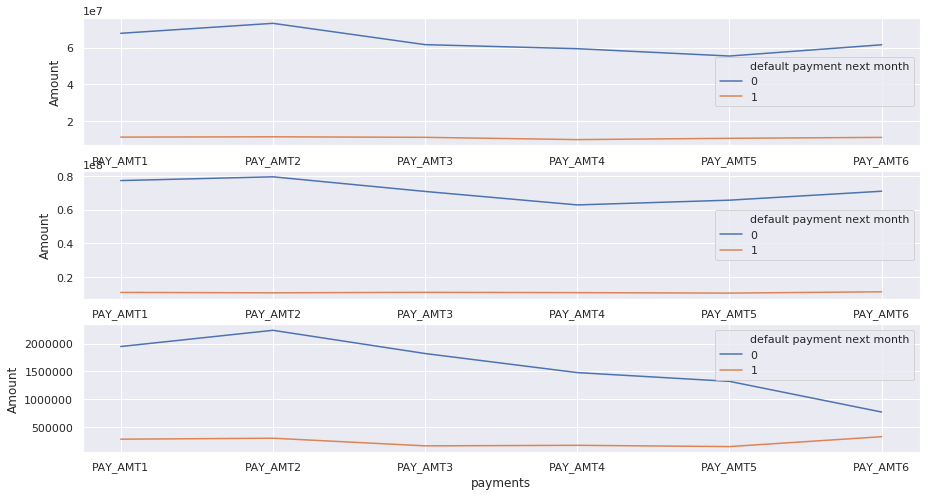

In [565]:
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(15,8))
sns.lineplot(x='payments', y='Amount', hue='default payment next month',ci=False, data=m, ax =ax[0])
sns.lineplot(x='payments', y='Amount', hue='default payment next month',ci=False, data=s, ax =ax[1])
sns.lineplot(x='payments', y='Amount', hue='default payment next month',ci=False, data=o, ax=ax[2])


In [566]:
melted_dt = dt[['AGE_BUCKET','default payment next month','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [567]:
melted_pay_dt = melted_dt.melt(id_vars=['AGE_BUCKET','default payment next month'],var_name='payments',value_name='Amount')
melted_pay_dt

,AGE_BUCKET,default payment next month,payments,Amount
0,21-30,1,PAY_AMT1,0
1,21-30,1,PAY_AMT1,0
2,31-40,0,PAY_AMT1,1518
3,31-40,0,PAY_AMT1,2000
4,51-60,0,PAY_AMT1,2000
5,31-40,0,PAY_AMT1,2500
6,21-30,0,PAY_AMT1,55000
7,21-30,0,PAY_AMT1,380
8,21-30,0,PAY_AMT1,3329
9,31-40,0,PAY_AMT1,0


In [568]:
summary = melted_pay_dt.groupby(by=['default payment next month','AGE_BUCKET','payments'])['Amount'].sum().reset_index()
summary

,default payment next month,AGE_BUCKET,payments,Amount
0,0,21-30,PAY_AMT1,47272564
1,0,21-30,PAY_AMT2,47604059
2,0,21-30,PAY_AMT3,40233330
3,0,21-30,PAY_AMT4,37883382
4,0,21-30,PAY_AMT5,39120744
5,0,21-30,PAY_AMT6,41219834
6,0,31-40,PAY_AMT1,58020097
7,0,31-40,PAY_AMT2,62524517
8,0,31-40,PAY_AMT3,54224641
9,0,31-40,PAY_AMT4,51099302


In [569]:
dt.AGE_BUCKET.value_counts()

21-30    10519
31-40    10144
41-50     5694
51-60     1891
60+        245
Name: AGE_BUCKET, dtype: int64

In [570]:
y = summary[summary['AGE_BUCKET']=='21-30']
a = summary[summary['AGE_BUCKET']=='31-40']
m = summary[summary['AGE_BUCKET']=='41-50']
o = summary[summary['AGE_BUCKET']=='51-50']
d = summary[summary['AGE_BUCKET']=='60+']



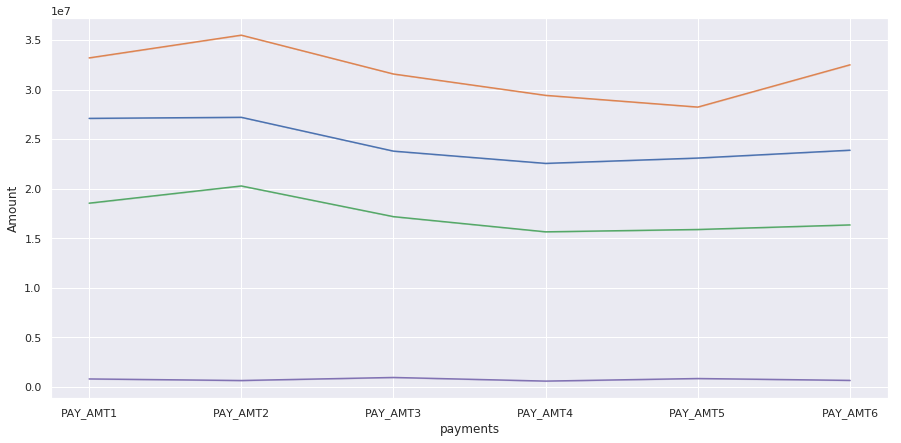

In [574]:
plt.figure(figsize=(15,7))
sns.lineplot(x='payments', y='Amount',ci=False, data=y)
sns.lineplot(x='payments', y='Amount',ci=False, data=a)
sns.lineplot(x='payments', y='Amount',ci=False, data=m)
sns.lineplot(x='payments', y='Amount',ci=False, data=o)
sns.lineplot(x='payments', y='Amount',ci=False, data=d)


------

In [625]:
pay_melted_dt = dt[['EDUCATION','default payment next month','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']]

In [626]:
pay_melted_dt = pay_melted_dt.melt(id_vars=['EDUCATION','default payment next month'],var_name='payments',value_name='Amount').reset_index()
pay_melted_dt

,index,EDUCATION,default payment next month,payments,Amount
0,0,2,1,PAY_AMT1,0
1,1,2,1,PAY_AMT1,0
2,2,2,0,PAY_AMT1,1518
3,3,2,0,PAY_AMT1,2000
4,4,2,0,PAY_AMT1,2000
5,5,1,0,PAY_AMT1,2500
6,6,1,0,PAY_AMT1,55000
7,7,2,0,PAY_AMT1,380
8,8,3,0,PAY_AMT1,3329
9,9,3,0,PAY_AMT1,0


In [627]:
bills_melted_dt = dt[['EDUCATION','default payment next month','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']]

In [628]:
bills_melted_dt = bills_melted_dt.melt(id_vars=['EDUCATION','default payment next month'],var_name='bills',value_name='Amount').reset_index()
bills_melted_dt

,index,EDUCATION,default payment next month,bills,Amount
0,0,2,1,BILL_AMT1,3913
1,1,2,1,BILL_AMT1,2682
2,2,2,0,BILL_AMT1,29239
3,3,2,0,BILL_AMT1,46990
4,4,2,0,BILL_AMT1,8617
5,5,1,0,BILL_AMT1,64400
6,6,1,0,BILL_AMT1,367965
7,7,2,0,BILL_AMT1,11876
8,8,3,0,BILL_AMT1,11285
9,9,3,0,BILL_AMT1,0


In [629]:
merged_dt_bills_payments = bills_melted_dt

In [630]:
merged_dt_bills_payments['payments'] = pay_melted_dt['payments']

In [631]:
merged_dt_bills_payments['pay_amount'] = pay_melted_dt['Amount']

In [633]:
summary = merged_dt_bills_payments.groupby(by=['EDUCATION','default payment next month','bills','payments'])['Amount','pay_amount'].sum().reset_index()
summary

,EDUCATION,default payment next month,bills,payments,Amount,pay_amount
0,0,0,BILL_AMT1,PAY_AMT1,157291,83241
1,0,0,BILL_AMT2,PAY_AMT2,140794,182433
2,0,0,BILL_AMT3,PAY_AMT3,245300,123552
3,0,0,BILL_AMT4,PAY_AMT4,186903,50688
4,0,0,BILL_AMT5,PAY_AMT5,103727,35584
5,0,0,BILL_AMT6,PAY_AMT6,73821,42101
6,1,0,BILL_AMT1,PAY_AMT1,417915210,64390712
7,1,0,BILL_AMT2,PAY_AMT2,404748317,69561949
8,1,0,BILL_AMT3,PAY_AMT3,393619491,61288368
9,1,0,BILL_AMT4,PAY_AMT4,368770455,53707905


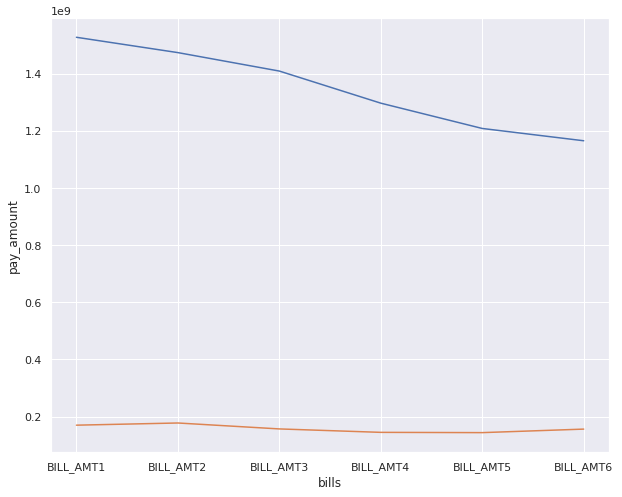

In [604]:
plt.figure(figsize=(10,8))
sns.lineplot(x='bills',y='Amount', data=summary)
sns.lineplot(x='bills',y='pay_amount', data=summary)

In [635]:
graudates = summary[summary['EDUCATION']==1]
univeristy = summary[summary['EDUCATION']==2]
high_school = summary[summary['EDUCATION']==3]
others = summary[summary['EDUCATION']==4]

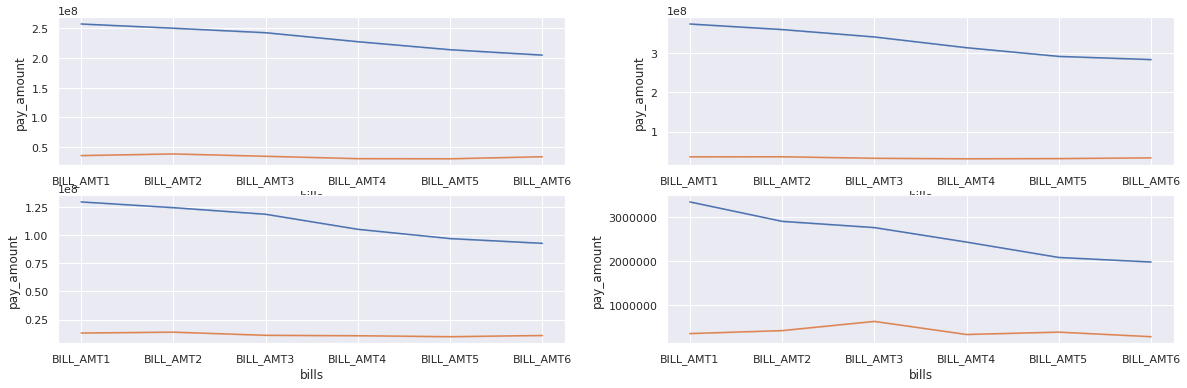

In [638]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,6))
sns.lineplot(x='bills',y='Amount', data=graudates, ax=ax[0,0], ci=False)
sns.lineplot(x='bills',y='pay_amount', data=graudates, ax=ax[0,0], ci=False) 

sns.lineplot(x='bills',y='Amount', data=univeristy, ax=ax[0,1], ci=False)
sns.lineplot(x='bills',y='pay_amount', data=univeristy, ax=ax[0,1], ci=False)

sns.lineplot(x='bills',y='Amount', data=high_school, ax=ax[1,0], ci=False)
sns.lineplot(x='bills',y='pay_amount', data=high_school, ax=ax[1,0], ci=False) 

sns.lineplot(x='bills',y='Amount', data=others, ax=ax[1,1], ci=False)
sns.lineplot(x='bills',y='pay_amount', data=others, ax=ax[1,1], ci=False)

----------

In [616]:
summary

,default payment next month,bills,payments,Amount,pay_amount
0,0,BILL_AMT1,PAY_AMT1,1207625291,147357930
1,0,BILL_AMT2,PAY_AMT2,1160787250,155041166
2,0,BILL_AMT3,PAY_AMT3,1109942529,134424700
3,0,BILL_AMT4,PAY_AMT4,1018455773,123830007
4,0,BILL_AMT5,PAY_AMT5,946505171,122456249
5,0,BILL_AMT6,PAY_AMT6,911875703,133326053
6,1,BILL_AMT1,PAY_AMT1,319282891,22542785
7,1,BILL_AMT2,PAY_AMT2,312485725,22487079
8,1,BILL_AMT3,PAY_AMT3,298784130,22345745
9,1,BILL_AMT4,PAY_AMT4,277951248,20940739


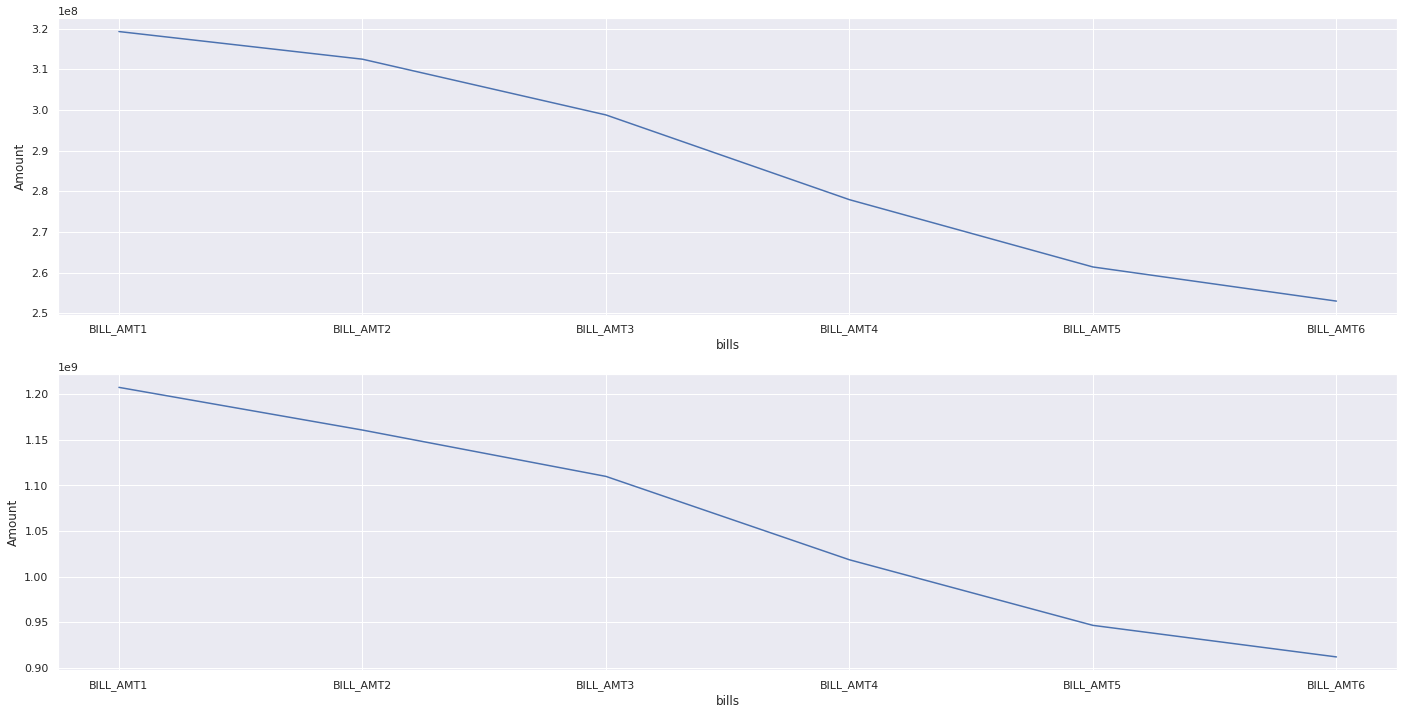

In [624]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(24,12))
sns.lineplot(x='bills',y='Amount', data=f, ci=False, ax=ax[0])
sns.lineplot(x='bills',y='Amount', data=n, ci=False ,ax=ax[1])

---------------

In [658]:
age_analysis = dt.groupby(by=['MARRIAGE','default payment next month','AGE_BUCKET'])['AGE_BUCKET'].count().rename(columns={'AGE_BUCKET':'population'}).reset_index()
age_analysis

,MARRIAGE,default payment next month,AGE_BUCKET,0
0,0,0,21-30,9
1,0,0,31-40,20
2,0,0,41-50,11
3,0,0,51-60,4
4,0,1,21-30,2
5,0,1,41-50,3
6,1,0,21-30,1343
7,1,0,31-40,4262
8,1,0,41-50,3179
9,1,0,51-60,1034


In [694]:
age_analysis['default payment next month'] = np.where(age_analysis['default payment next month']==1, 'Defaulters','Non-defaulters')

In [695]:
m = age_analysis[age_analysis['MARRIAGE']==1]
s = age_analysis[age_analysis['MARRIAGE']==2]
o = age_analysis[age_analysis['MARRIAGE']==3]

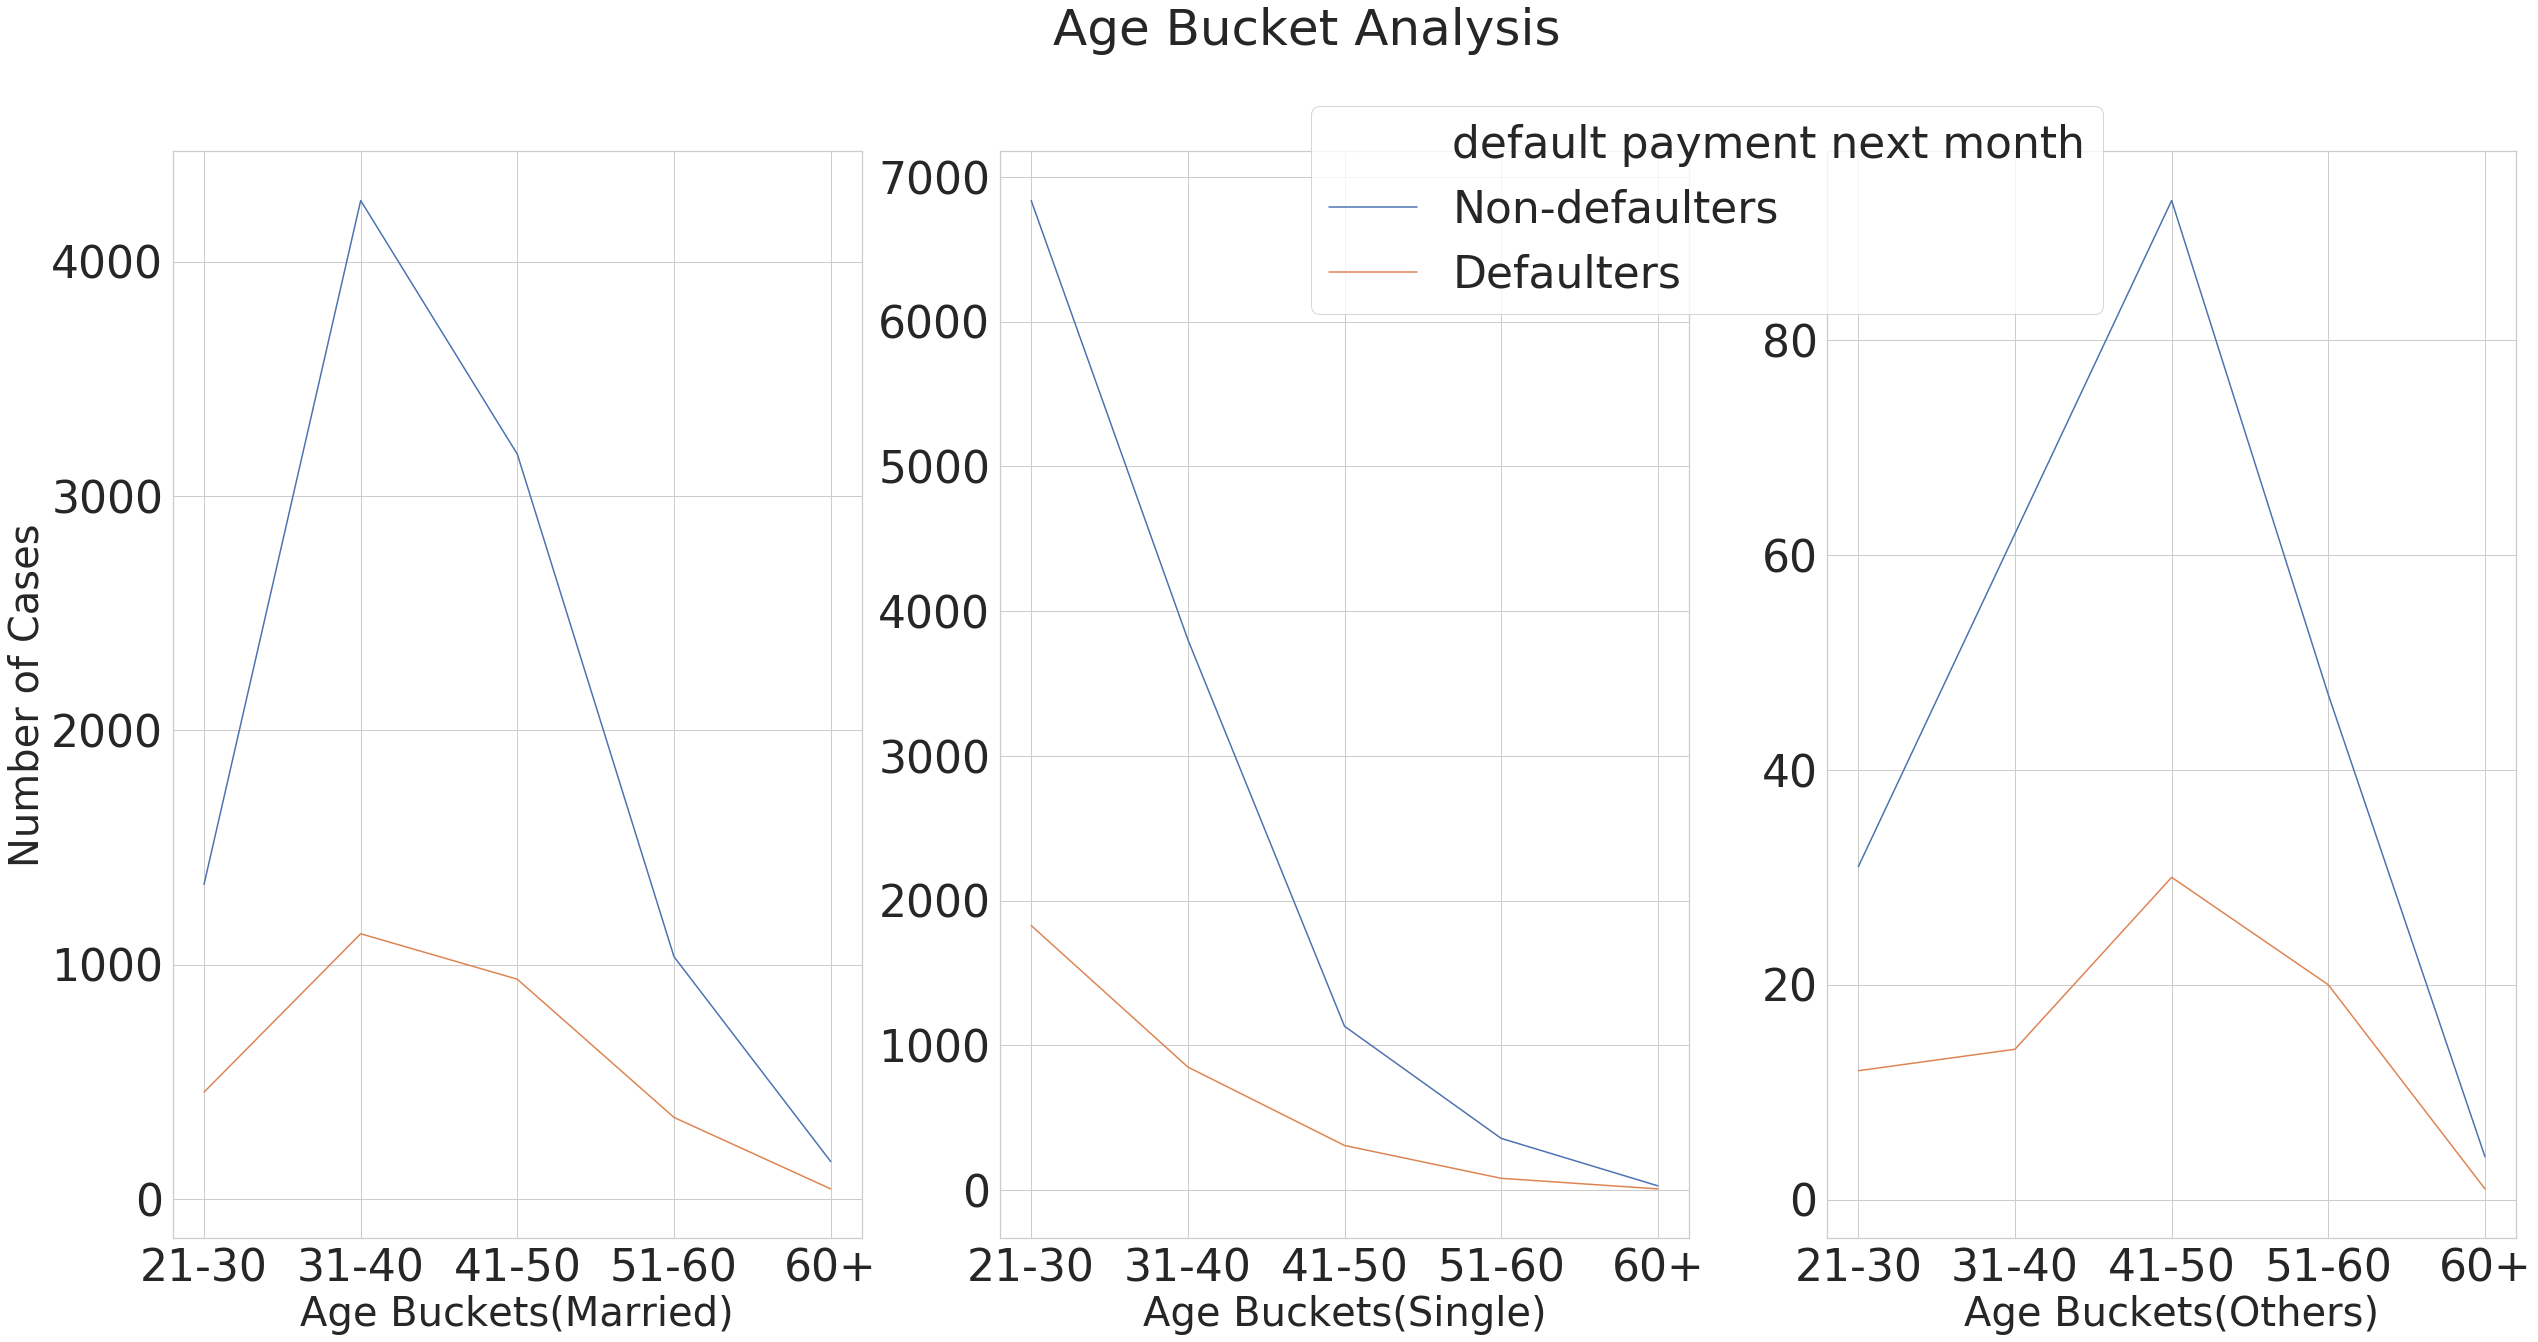

In [769]:
fig, ax = plt.subplots(ncols=3,nrows=1, figsize=(42,20))
sns.set(font_scale=4)
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(x='AGE_BUCKET', y=0,hue='default payment next month'  ,data=m, ax=ax[0],legend=False)
ax[0].set_ylabel('Number of Cases',fontsize=40)
ax[0].set_xlabel('Age Buckets(Married)',fontsize=40)
sns.lineplot(x='AGE_BUCKET', y=0,hue='default payment next month'  ,data=s, ax=ax[1], legend=False)
ax[1].set_ylabel('',fontsize=30)
ax[1].set_xlabel('Age Buckets(Single)',fontsize=40)
sns.lineplot(x='AGE_BUCKET', y=0,hue='default payment next month'  ,data=o, ax=ax[2])
ax[2].set_ylabel('',fontsize=30)
ax[2].set_xlabel('Age Buckets(Others)',fontsize=40)
fig.suptitle('Age Bucket Analysis',fontsize=50)
plt.legend(bbox_to_anchor=(0.4, 0.85), loc=4, borderaxespad=0.)
fig.savefig('/home/sehan/Desktop/Playing_area/Fraud_detection/static/img/home/Vis3.png',transparent=True)